In [13]:
import os 
os.chdir('../')
import pandas as pd

In [22]:
dataframe = pd.read_csv('Work/chelombus/data/10M_ZINC_id_Sim_mqn.csv')

In [42]:
s = 'Work/chelombus/data/10M_ZINC_id_Sim_mqn.csv'


s.split('.')[-1]

'csv'

In [4]:
from src.data_handler import DataHandler
data_handler = DataHandler()
smiles_list, features = data_handler.extract_smiles_and_features(dataframe)

In [5]:
features

array([[' Enzyme ', ' Bacteria ', ' SINGLE PROTEIN '],
       [' Enzyme ', ' Bacteria ', ' SINGLE PROTEIN '],
       [' Enzyme ', ' Bacteria ', ' SINGLE PROTEIN '],
       ...,
       [' Enzyme ', ' Eukaryotes ', ' SINGLE PROTEIN '],
       [' Enzyme ', ' Eukaryotes ', ' SINGLE PROTEIN '],
       [' Enzyme ', ' Eukaryotes ', ' SINGLE PROTEIN ']], dtype=object)

In [6]:
from src.fingerprint_calculator import FingerprintCalculator
fp_calculator = FingerprintCalculator()

fingerprints = fp_calculator.calculate_fingerprints(smiles_list)

In [ ]:
from rdkit.Chem import rdMolDescriptors    
from rdkit import Chem

m = Chem.MolFromSmiles('CO[C@@H]1[C@@H](OC(N)=O)[C@@H](O)[C@H](Oc2ccc3c(O)c(NC(=O)c4ccc(O)c(CC=C(C)C)c4)c(=O)oc3c2C)OC1(C)C')

ds = rdMolDescriptors.MQNs_(m)                                                                    

len(ds)

In [9]:
fingerprints.shape

(38370, 42)

In [10]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn import preprocessing


def estimate_components(data_sample):
    # Assume data_sample is a NumPy array of shape (n_samples, n_features)
    
    # Step 2: Fit PCA without reducing dimensions
    pca = PCA(n_components=len(fingerprints[1]))
    pca.fit(data_sample)
    
    # Step 3: Calculate cumulative explained variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    
    # Step 4: Determine the number of components to retain desired variance
    threshold = 0.95  # For 95% variance
    n_components = np.argmax(cumulative_variance >= threshold) + 1
    print(f"Number of components to retain {threshold*100}% of variance: {n_components}")
    
    # Optional: Plot cumulative explained variance
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Explained Variance vs. Number of Components')
    plt.grid(True)
    plt.show()
    
    return n_components


Number of components to retain 95.0% of variance: 3


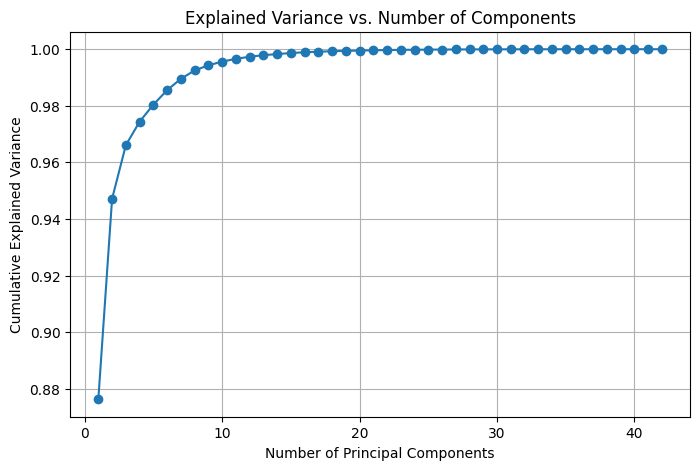

3

In [11]:
estimate_components(fingerprints)

Not good, should look into other FP that can reduce the number of dimensions and still conserve the variance

In [18]:
dataframe = dataframe.drop(columns= ['target_id', 'standard_type', 'target_name', 'standard_relation', 'standard_value', 'standard_units', 'target_organism'])

In [19]:
dataframe.to_csv('data/cleaned_dataset.csv', index = False)

In [1]:
import csv
import itertools
from math import sqrt

def euclidean_distance(p1, p2):
    return sqrt(sum((a - b) ** 2 for a, b in zip(p1, p2)))

def find_most_similar_points(filename):
    points = []
    with open(filename, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            points.append((float(row['x']), float(row['y']), float(row['z'])))

    min_distance = float('inf')
    most_similar = None

    for combo in itertools.combinations(range(len(points)), 10):
        p1, p2, p3 = [points[i] for i in combo]
        dist = (euclidean_distance(p1, p2) + 
                euclidean_distance(p2, p3) + 
                euclidean_distance(p3, p1))
        if dist < min_distance:
            min_distance = dist
            most_similar = (p1, p2, p3)

    return most_similar

# Usage
filename = '/home/afloresep/work/chelombus/data/output/batch_data_0.csv'
result = find_most_similar_points(filename)
print("The 3 most similar points are:", result)

The 3 most similar points are: ((1.7721422125559418, 1.3703430100724014, 1.9155553450241183), (1.7721422125559418, 1.3703430100724014, 1.9155553450241183), (1.7721422125559418, 1.3703430100724014, 1.9155553450241183))


This proves that same molecules are given the same coordinates

In [3]:
import csv
import itertools
from math import sqrt
from collections import defaultdict

def euclidean_distance(p1, p2):
    return sqrt(sum((a - b) ** 2 for a, b in zip(p1, p2)))

def find_most_similar_points(filename):
    points = defaultdict(list)
    with open(filename, 'r') as f:
        reader = csv.DictReader(f)
        for i, row in enumerate(reader):
            point = (float(row['x']), float(row['y']), float(row['z']))
            points[point].append(i)

    unique_points = list(points.keys())
    
    if len(unique_points) < 3:
        return "Not enough unique points to find 3 most similar."

    min_distance = float('inf')
    most_similar = None

    for combo in itertools.combinations(range(len(unique_points)), 3):
        p1, p2, p3 = [unique_points[i] for i in combo]
        dist = (euclidean_distance(p1, p2) + 
                euclidean_distance(p2, p3) + 
                euclidean_distance(p3, p1))
        if dist < min_distance:
            min_distance = dist
            most_similar = (p1, p2, p3)

    return most_similar, min_distance

# Usage
filename = '/home/afloresep/work/chelombus/data/output/batch_data_0.csv'
result, distance = find_most_similar_points(filename)
print("The 3 most similar non-duplicate points are:", result)
print("Total distance between these points:", distance)

The 3 most similar non-duplicate points are: ((-1.4071302858277, 1.607233773614834, 1.0548155160181296), (-1.4168149250207485, 1.3376908007358967, 1.1341862100403879), (-1.5213659397180634, 1.5002080079195448, 1.1530337775164536))
Total distance between these points: 0.6601127597000824


In [ ]:
import csv
import itertools
from math import sqrt
from collections import defaultdict
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem

def euclidean_distance(p1, p2):
    return sqrt(sum((a - b) ** 2 for a, b in zip(p1, p2)))

def find_most_similar_points(filename, n=10):
    points = defaultdict(list)
    smiles_dict = {}
    with open(filename, 'r') as f:
        reader = csv.DictReader(f)
        for i, row in enumerate(reader):
            point = (float(row['x']), float(row['y']), float(row['z']))
            points[point].append(i)
            smiles_dict[point] = row['smiles']

    unique_points = list(points.keys())
    
    if len(unique_points) < n:
        return f"Not enough unique points to find {n} most similar."

    distances = []
    for combo in itertools.combinations(range(len(unique_points)), n):
        combo_points = [unique_points[i] for i in combo]
        dist = sum(euclidean_distance(p1, p2) 
                   for p1, p2 in itertools.combinations(combo_points, 2))
        distances.append((dist, combo_points))

    distances.sort(key=lambda x: x[0])
    return distances[0]

def plot_smiles(smiles_list):
    mols = [Chem.MolFromSmiles(smile) for smile in smiles_list]
    
    for mol in mols:
        AllChem.Compute2DCoords(mol)
    
    rows = (len(smiles_list) + 4) // 5  # 5 molecules per row
    fig, axes = plt.subplots(rows, 5, figsize=(20, 4*rows))
    fig.suptitle("2D Structures of 10 Most Similar Molecules", fontsize=16)

    axes = axes.flatten()  # Flatten the 2D array of axes

    for i, (mol, ax) in enumerate(zip(mols, axes)):
        img = Draw.MolToImage(mol)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"Structure {i+1}", fontsize=10)

    # Hide any unused subplots
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Usage
filename = '/home/afloresep/work/chelombus/data/output/batch_data_19531.csv'
result, distance = find_most_similar_points(filename)


In [ ]:
data_handler = DataHandler()

data_handler.find_input_type(file_path='test.csv')



In [ ]:
from tqdm import tqdm
import pickle


# Load all fingerprints with tqdm progress bar
fingerprints, smiles_list, features = [], [], []
for idx in tqdm(range(75), desc="Loading Fingerprints"):
    with open(f'data/fingerprints_chunk_{idx}.pkl', 'rb') as f:
        fps_chunk, smiles_chunk, features_chunk = pickle.load(f)
        fingerprints.extend(fps_chunk)
        smiles_list.extend(smiles_chunk)
        features.extend(features_chunk)

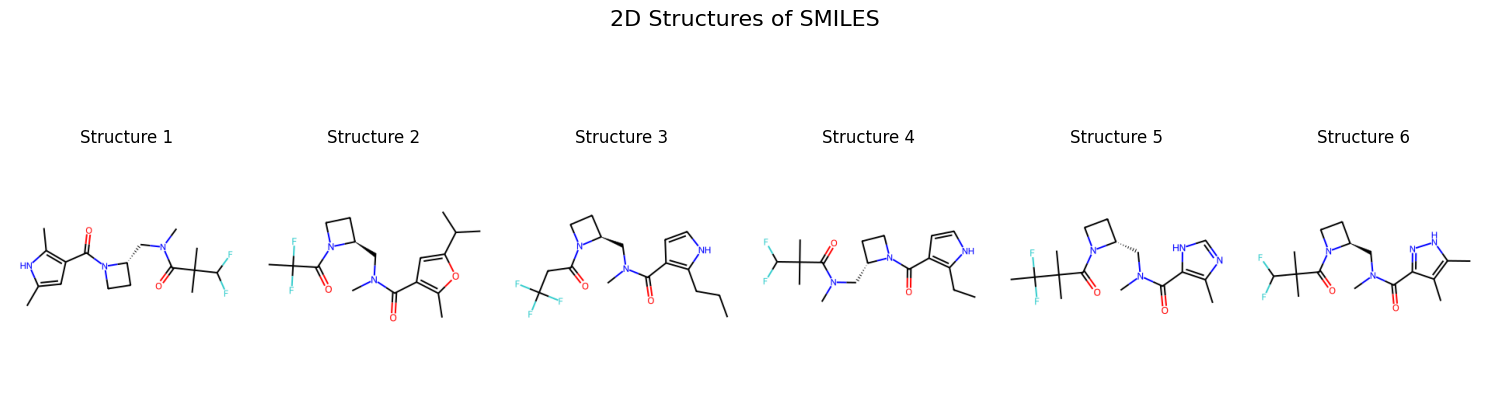

In [20]:
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem

def plot_smiles(smiles_list):
    mols = [Chem.MolFromSmiles(smile) for smile in smiles_list]
    
    # Generate 2D coordinates for each molecule
    for mol in mols:
        AllChem.Compute2DCoords(mol)
    
    # Create a 1x3 subplot
    fig, axes = plt.subplots(1, 6, figsize=(15, 5))
    fig.suptitle("2D Structures of SMILES", fontsize=16)

    for i, (mol, ax) in enumerate(zip(mols, axes)):
        img = Draw.MolToImage(mol)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"Structure {i+1}", fontsize=12)

    plt.tight_layout()
    plt.show()

# SMILES strings
smiles = ['Cc1cc(C(=O)N2CC[C@H]2CN(C)C(=O)C(C)(C)C(F)F)c(C)[nH]1','Cc1oc(C(C)C)cc1C(=O)N(C)C[C@@H]1CCN1C(=O)C(C)(F)F',
'CCCc1[nH]ccc1C(=O)N(C)C[C@@H]1CCN1C(=O)CC(F)(F)F',
'CCc1[nH]ccc1C(=O)N1CC[C@H]1CN(C)C(=O)C(C)(C)C(F)F',
'Cc1nc[nH]c1C(=O)N(C)C[C@H]1CCN1C(=O)C(C)(C)C(C)(F)F',
'Cc1[nH]nc(C(=O)N(C)C[C@@H]2CCN2C(=O)C(C)(C)C(F)F)c1C',
'Cc1nn(C(C)C)cc1C(=O)N(C)C[C@@H]1CCN1C(=O)C(C)(F)F']

plot_smiles(smiles)



In [5]:
import pandas as pd

df = pd.read_csv('/home/afloresep/work/chelombus/data/10M_ZINC_id_Sim_mqn.csv', nrows=1000000)

In [48]:
import rdkit
from rdkit import Chem

file_path = '/home/afloresep/work/chelombus/data/Enamine_REAL_HAC_29_38_1.3B_Part_2_CXSMILES.cxsmiles'

cxsmiles_batch = []
with open(file_path, 'r') as file:
    for i, line in enumerate(file):
        pass
print(i)

664075400


In [52]:
def get_total_chunks(file_path, chunksize):
    """ Calculate number of chunks based on chunksize. For tqdm """
    total_lines = sum(1 for _ in open(file_path)) - 1  # Subtract 1 for header
    total_chunks = (total_lines + chunksize - 1) // chunksize
    return total_chunks

In [53]:
get_total_chunks(file_path, chunksize=20000)

33204

In [5]:
import os
# os.chdir('../')
import time
import sys
import pickle
from config import DATA_FILE_PATH, CHUNKSIZE
from tqdm import tqdm 
from sklearn.decomposition import IncrementalPCA

from src.data_handler import DataHandler, get_total_chunks
from src.fingerprint_calculator import FingerprintCalculator
from src.output_generator import OutputGenerator

# Initialize classes
data_handler = DataHandler(DATA_FILE_PATH, CHUNKSIZE)
output_gen = OutputGenerator()
fp_calculator = FingerprintCalculator()
# Load data in chunks
start = time.time()
data_chunks, total_chunks = data_handler.load_data()
# Process chunks with tqdm progress bar
num_chunks = 0
for idx, chunk in enumerate(tqdm(data_chunks, total=18295, desc="Processing Chunks")):
    num_chunks += 1
    chunk

Processing Chunks:   0%|          | 40/18295 [00:02<18:03, 16.85it/s]


KeyboardInterrupt: 

In [20]:
with open('data/Enamine_REAL_HAC_29_38_1.3B_Part_2_CXSMILES.cxsmiles', 'r', encoding='utf-8') as f:
            while True:
                smiles = []
                features = [] 
                for _ in range(100):
                        line = f.readline().split()

KeyboardInterrupt: 

In [29]:
with open('data/Enamine_REAL_HAC_29_38_1.3B_Part_2_CXSMILES.cxsmiles', 'r', encoding='utf-8') as f:
    for _ in range (1000):
        smiles_entry = line.strip().split('\t')[1:]
        print(smiles_entry)

['s_188690____14588592____7313982', '434.489', '30', '2.707', '5', '3', '10', '0.286', '104.730', 'True', '', '', '', '', '', 'S', 'UYEXGFCTRPSJFD-UHFFFAOYSA-N']
['s_188690____14588592____7313982', '434.489', '30', '2.707', '5', '3', '10', '0.286', '104.730', 'True', '', '', '', '', '', 'S', 'UYEXGFCTRPSJFD-UHFFFAOYSA-N']
['s_188690____14588592____7313982', '434.489', '30', '2.707', '5', '3', '10', '0.286', '104.730', 'True', '', '', '', '', '', 'S', 'UYEXGFCTRPSJFD-UHFFFAOYSA-N']
['s_188690____14588592____7313982', '434.489', '30', '2.707', '5', '3', '10', '0.286', '104.730', 'True', '', '', '', '', '', 'S', 'UYEXGFCTRPSJFD-UHFFFAOYSA-N']
['s_188690____14588592____7313982', '434.489', '30', '2.707', '5', '3', '10', '0.286', '104.730', 'True', '', '', '', '', '', 'S', 'UYEXGFCTRPSJFD-UHFFFAOYSA-N']
['s_188690____14588592____7313982', '434.489', '30', '2.707', '5', '3', '10', '0.286', '104.730', 'True', '', '', '', '', '', 'S', 'UYEXGFCTRPSJFD-UHFFFAOYSA-N']
['s_188690____14588592____73

In [1]:
list = ['CCOC(=O)C1=C(C)N=C(CNC(C2=CC(C)=CC=C2)C2=NN=NN2C(C)(C)C)O1', 'm_281630____20791298____21626834____20772848', '412.494', '30', '3.089', '9', '1', '7', '0.476', '107.960', 'True', '', '', '', 'True', '', 'M', 'VZHDHOYOOHWDCC-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CC(C)=CC=C2)C2=NN=NN2C2COC2)O1', 'm_281630____20791298____21626834____25335388', '412.450', '30', '1.905', '10', '1', '8', '0.450', '117.190', '', '', '', '', 'True', '', 'M', 'SJRDXFZKWVBDTJ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CC(C)=CC=C2)C2=NN=NN2CC2CC2)O1', 'm_281630____20791298____21626834____20772842', '410.478', '30', '2.744', '9', '1', '9', '0.476', '107.960', 'True', '', '', '', 'True', '', 'M', 'WCWHWWXCEKYUKF-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CSC=C2)C2=NN=NN2C2=CC=CC=C2)O1', 'm_281630____20791298____21626838____20648558', '424.486', '30', '3.076', '10', '1', '8', '0.250', '107.960', '', '', '', '', '', '', 'M', 'RHWQFHCJUYMJDO-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CSC=C2)C2=NN=NN2C2CCCCC2)O1', 'm_281630____20791298____21626838____20648564', '430.534', '30', '3.592', '10', '1', '8', '0.550', '107.960', '', '', '', '', 'True', '', 'M', 'YPTQPDFXLWNEAW-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C)(C2=NN=NN2C2CCCCCC2)C(C)C)O1', 'm_281630____20791298____21626842____20772980', '418.542', '30', '3.703', '9', '1', '8', '0.762', '107.960', 'True', '', '', '', 'True', '', 'M', 'BGEAYDMZKGFJHJ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=C(C)C=C(C)C=C2C)C2=NN=NN2CC)O1', 'm_281630____20791298____21626850____20648542', '412.494', '30', '2.971', '9', '1', '8', '0.476', '107.960', 'True', '', '', '', 'True', '', 'M', 'IBELWEKHEAAUQQ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=CC=C2N2CCCCC2)O1', 's_2718____18903932____867228', '414.462', '30', '2.405', '7', '2', '6', '0.429', '113.770', 'True', '', '', '', 'True', '', 'S', 'UKEKUVBIPOIWDT-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CC2=CC=C(S(=O)(=O)N3CCOCC3)S2)O1', 's_22____18903922____59061', '457.530', '30', '1.101', '9', '1', '8', '0.500', '128.040', 'True', '', '', '', 'True', '', 'S', 'HLDHVNNGEKJIFZ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC(C3=CC=CS3)=NC3=CC=CC=C23)O1', 's_11____22176648____53678', '421.478', '30', '4.366', '7', '1', '6', '0.182', '94.320', '', '', '', '', '', '', 'S', 'KFOSIQCVDZZWOP-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=CC=C(S(=O)(=O)NC3=CC=CC=C3F)C=C2)=N1', 's_188690____21771246____7312656', '433.417', '30', '2.551', '6', '3', '7', '0.105', '138.600', 'True', '', '', '', '', '', 'S', 'VFGQJTKVEYJRSK-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=CC=C(Cl)C(S(=O)(=O)N3CCCCCC3)=C2)=N1', 's_188690____21771246____7312662', '455.920', '30', '2.829', '6', '2', '6', '0.421', '129.810', 'True', '', '', '', 'True', '', 'S', 'BNSAFPHTKFPJLV-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=CC=C(NS(=O)(=O)C3=CC=C(Br)C=C3)C=C2)=N1', 's_188690____21771246____7312664', '494.323', '30', '3.175', '6', '3', '7', '0.105', '138.600', '', '', '', '', '', '', 'S', 'APCZJOYDBBCUBC-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=C3C=CC=CC3=NC(C3=CC=CC=C3Cl)=C2)=N1', 's_188690____21771246____13231424', '421.840', '30', '4.480', '5', '2', '5', '0.091', '105.320', '', '', '', '', '', '', 'S', 'YTVWSTNKQVAEIO-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC3=C(S2)N(C2=CC=CC=C2)N=C3C)O1', 's_11____22176648____53698', '424.482', '30', '3.799', '8', '1', '6', '0.238', '99.250', 'True', '', '', '', '', '', 'S', 'MMBITSCGDLEQJI-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=C(S(=O)(=O)N3CCOCC3)C=C2)O1', 's_11____22176648____53707', '437.474', '30', '1.111', '8', '1', '7', '0.421', '128.040', 'True', '', '', '', 'True', '', 'S', 'JYWWPGXBOFXYRE-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCN(CC=CC3=CC=CC=C3)CC2)O1', 's_2708____23847410____909482', '412.490', '30', '2.700', '6', '1', '7', '0.409', '87.910', 'True', '', '', '', 'True', '', 'S', 'DOGMXXYLYHAELB-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CC=C(C)C=C2C)C2=NN=NN2C(C)C)O1', 'm_281630____20791298____21627518____20772828', '412.494', '30', '3.223', '9', '1', '8', '0.476', '107.960', 'True', '', '', '', 'True', '', 'M', 'OEURLGGQKIGFOS-UHFFFAOYSA-N'], ['CC1=CC=C(NS(=O)(=O)C2=CC=CC(C(=O)NCC3=NC(C)=C(C(=O)O)O3)=C2)C=C1', 's_188690____21771246____7312724', '429.454', '30', '2.720', '6', '3', '7', '0.150', '138.600', 'True', '', '', '', '', '', 'S', 'WPOMXKVSZHYBNN-UHFFFAOYSA-N'], ['CC1=CC=C(C2=CC(C(=O)NCC3=NC(C)=C(C(=O)O)O3)=C3C=CC=CC3=N2)C=C1', 's_188690____21771246____9348882', '401.422', '30', '4.135', '5', '2', '5', '0.130', '105.320', 'True', '', '', '', '', '', 'S', 'PBXQMHJODPWNHZ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=CC=C2NC2=C(C)C(C)=CC=C2)O1', 's_11____22176648____53741', '407.470', '30', '4.450', '6', '2', '7', '0.261', '93.460', '', '', '', '', '', '', 'S', 'LDWAYQOBDVGWBY-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=CC=C2SC2=CC=CC=C2C#N)O1', 's_11____22176648____53752', '421.478', '30', '4.113', '7', '1', '7', '0.182', '105.220', 'True', '', '', '', '', '', 'S', 'HBOHTILOEKXSQX-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC(C(C)(C)C)=CC=C2OC)O1', 's_2718____18903932____867318', '417.462', '30', '2.721', '7', '2', '6', '0.429', '119.760', 'True', '', '', '', '', '', 'S', 'LOWOZQAZPAIQKZ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2(C3=NN=NN3CCCOC)CCCC(C)C2)O1', 'm_281630____20791298____21627528____20772946', '420.514', '30', '2.378', '10', '1', '10', '0.750', '117.190', '', '', '', '', 'True', '', 'M', 'VERQBNDRQBECEQ-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=CC=CC=C2NC2=CC(C(F)(F)F)=CC=C2)=N1', 's_188690____21771246____9348888', '419.359', '30', '4.374', '5', '3', '6', '0.150', '104.460', '', '', '', '', '', '', 'S', 'ZGMXUGQDYVHZFK-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=CC(S(=O)(=O)N(C)C3=CC=CC=C3)=CC=C2)=N1', 's_188690____21771246____7312766', '429.454', '30', '2.436', '6', '2', '7', '0.150', '129.810', 'True', '', '', '', '', '', 'S', 'MNUQSXGLSMFOJJ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC(C)=NN2C2=CC=CC=C2)O1', 's_2718____18903932____7592446', '411.418', '30', '1.909', '8', '2', '6', '0.250', '128.350', 'True', '', '', '', '', '', 'S', 'YZSVEXXSQYPGRA-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=C3C=CC=CC3=NC(C3=CC=C(Br)C=C3)=C2)=N1', 's_188690____21771246____21753870', '466.291', '30', '4.589', '5', '2', '5', '0.091', '105.320', '', '', '', '', '', '', 'S', 'KKIJROLNGMGWDQ-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=CC(S(=O)(=O)NC3=CC=C(Br)C=C3)=CC=C2)=N1', 's_188690____21771246____21770844', '494.323', '30', '3.175', '6', '3', '7', '0.105', '138.600', '', '', '', '', '', '', 'S', 'HTZJXSLZNUSSQD-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=CC=C(N3CC(C)CC(C)C3)C([N+](=O)[O-])=C2)=N1', 's_188690____21771246____8286982', '416.434', '30', '3.002', '7', '2', '6', '0.450', '138.810', 'True', '', '', '', 'True', '', 'S', 'LJHVOAKBTOFNQI-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=C3C=CC=CC3=NC(C3=CC=CC=C3)=C2C)=N1', 's_188690____21771246____21665080', '401.422', '30', '4.135', '5', '2', '5', '0.130', '105.320', 'True', '', '', '', '', '', 'S', 'GCFAMZUMBLEWFZ-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=C3C=CC=CC3=NC(C3=CC(Br)=CC=C3)=C2)=N1', 's_188690____21771246____21665952', '466.291', '30', '4.589', '5', '2', '5', '0.091', '105.320', '', '', '', '', '', '', 'S', 'ZDPZQFJMHMCEJX-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NNC(=O)C2=C3C=CC=CC3=NC(C)=C2)O1', 's_2708____23847410____909708', '411.418', '30', '2.161', '7', '3', '5', '0.250', '135.450', 'True', '', '', '', '', '', 'S', 'GRWNWDLXSXJSKQ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=CC=C2OCC2=CC=C(Cl)C=C2)O1', 's_11____22176648____53884', '428.872', '30', '4.322', '6', '1', '8', '0.227', '90.660', '', '', '', '', '', '', 'S', 'FKLVXMMDMSGWIE-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=CC=C2OCC2=CC=CC=C2Cl)O1', 's_11____22176648____53886', '428.872', '30', '4.322', '6', '1', '8', '0.227', '90.660', '', '', '', '', '', '', 'S', 'DQKOOTRBCYKRPO-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=CC=C2OCC2=CC=C(F)C=C2)O1', 's_11____22176648____53894', '412.417', '30', '3.808', '6', '1', '8', '0.227', '90.660', 'True', '', '', '', '', '', 'S', 'JCRSDZTZTORLIH-UHFFFAOYSA-N'], ['CCCC1=NC2=CC=CC=C2C(C(=O)NCC2=NC(C)=C(C(=O)OCC)O2)=C1CC', 's_22____18903922____16783978', '409.486', '30', '4.153', '6', '1', '8', '0.391', '94.320', 'True', '', '', '', '', '', 'S', 'IAJMWOCMAYESRJ-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=CC=C(Cl)C=C2NC(=O)C2=CC=C(F)C=C2)=N1', 's_188690____21771246____25753608', '431.807', '30', '3.656', '5', '3', '6', '0.100', '121.530', 'True', '', '', '', '', '', 'S', 'WJAMCJURUQXLDJ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)COC2=CC=CC=C2CC2=CC=CC=C2)O1', 's_11____22176648____53978', '408.454', '30', '3.446', '6', '1', '9', '0.261', '90.660', 'True', '', '', '', '', '', 'S', 'HJWFEGKIGQQRIY-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=CC(NS(=O)(=O)C3=CC=C(Br)C=C3)=CC=C2)=N1', 's_188690____21771246____7312976', '494.323', '30', '3.175', '6', '3', '7', '0.105', '138.600', '', '', '', '', '', '', 'S', 'VBGPARNGPFIEFL-UHFFFAOYSA-N'], ['CC1=CC=CC=C1NS(=O)(=O)C1=CC=C(C(=O)NCC2=NC(C)=C(C(=O)O)O2)C=C1', 's_188690____21771246____7313012', '429.454', '30', '2.720', '6', '3', '7', '0.150', '138.600', 'True', '', '', '', '', '', 'S', 'GEDRKXYVDSIEDX-UHFFFAOYSA-N'], ['CCCOC1=CC=C(C(F)(F)F)C=C1NC(=O)NCC1=NC(C)=C(C(=O)OCC)O1', 's_2708____23847410____909820', '429.395', '30', '4.289', '6', '2', '8', '0.421', '102.690', '', '', '', '', '', '', 'S', 'GPLCWDQCGYYTCY-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2=C(Cl)C(=O)N(C3=NC4=CC=CC=C4N3)N=C2)O1', 's_27____18903924____102860', '428.836', '30', '2.847', '9', '2', '6', '0.211', '127.930', 'True', '', '', '', '', '', 'S', 'IMODAXLDHQJTGT-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CSC2=CC=C(C(F)(F)F)C=C2[N+](=O)[O-])O1', 's_11____22176648____54107', '447.391', '30', '3.495', '8', '1', '8', '0.353', '124.570', 'True', '', '', '', '', '', 'S', 'GLEKZPPMMZXOMD-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2CCCCN2S(=O)(=O)C2=CC=CC=C2)O1', 's_11____22176648____54139', '435.502', '30', '2.019', '7', '1', '7', '0.450', '118.810', 'True', '', '', '', 'True', '', 'S', 'AEORKGNURSUWAZ-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=CC=CC(N3C(=O)C4=CC=CC=C4C3=O)=C2)=N1', 's_188690____21771246____21600842', '405.366', '30', '2.412', '6', '2', '5', '0.095', '129.810', 'True', '', '', '', '', '', 'S', 'UHYLFNXOCQVLEM-UHFFFAOYSA-N'], ['COC1=CC(C(=O)NCC2=NC(C)=C(C(=O)O)O2)=CC=C1OCC1=CC=CC=C1Cl', 's_188690____21771246____7313122', '430.844', '30', '3.852', '6', '2', '8', '0.190', '110.890', 'True', '', '', '', '', '', 'S', 'WWVVZYCIFGKHBX-UHFFFAOYSA-N'], ['COC1=CC(OC)=CC(C(=O)NC(C(=O)NCC2=NC(C)=C(C(=O)O)O2)C(C)C)=C1', 's_188690____21771246____7313138', '419.434', '30', '1.769', '7', '3', '9', '0.400', '139.990', 'True', '', '', '', '', '', 'S', 'SBVOHDIURZMQGE-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(NS(=O)(=O)C2=CC=C(C)C=C2)C(C)C)O1', 's_11____22176648____26251220', '437.518', '30', '2.087', '7', '2', '9', '0.450', '127.600', 'True', '', '', '', '', '', 'S', 'VYOJPDFNFASJLN-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(CC(C)C)NC(=O)C2=CC=CC=C2C)O1', 's_11____22176648____54237', '415.490', '30', '2.929', '6', '2', '9', '0.455', '110.530', 'True', '', '', '', '', '', 'S', 'JURWWDFWENUSRG-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CNC2=CC=C(C(F)(F)F)C=C2[N+](=O)[O-])O1', 's_11____22176648____54239', '430.339', '30', '2.815', '8', '2', '8', '0.353', '136.600', 'True', '', '', '', '', '', 'S', 'CDSKKTSBTPSCJY-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)CC(NC(=O)C2=CC=CC=C2)C2=CC=CC=C2)=N1', 's_188690____21771246____7313210', '407.426', '30', '2.859', '5', '3', '8', '0.182', '121.530', 'True', '', '', '', '', '', 'S', 'PDPBFCFWYZPSMS-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N(C)C(C2=CC=CC=C2)C2=CC=CC=C2)O1', 's_2708____23847410____909930', '407.470', '30', '4.091', '5', '1', '7', '0.261', '84.670', 'True', '', '', '', '', '', 'S', 'SYQCVIQSDFNJDK-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CSC2=NN=NN2C2=CC(C)=CC=C2C)O1', 's_11____22176648____54338', '430.490', '30', '2.161', '10', '1', '8', '0.368', '125.030', '', '', '', '', 'True', '', 'S', 'IDGCUUSRZNYOEI-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC(OCC3=C(C)ON=C3C)=CC=C2)O1', 's_11____22176648____54410', '413.430', '30', '3.274', '8', '1', '8', '0.333', '116.690', 'True', '', '', '', '', '', 'S', 'KYHVODKVJZVOST-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=CC=C2SCC2=C(C)ON=C2C)O1', 's_22____18903922____337088', '429.498', '30', '3.987', '8', '1', '8', '0.333', '107.460', 'True', '', '', '', '', '', 'S', 'QOXJHMYWMABCGW-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNS(=O)(=O)C2=CC=C(S(=O)(=O)N(CC)CC)C=C2)O1', 's_40____18903926____79376', '459.546', '30', '1.669', '8', '1', '10', '0.444', '135.880', 'True', '', '', '', '', '', 'S', 'HLLZHVFBKFZXBQ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CSC2=NN=C(C3=CC=C(OC)C=C3)O2)O1', 's_22____18903922____335786', '432.458', '30', '2.627', '10', '1', '9', '0.316', '129.580', '', '', '', '', '', '', 'S', 'LLPSBLDNURCVES-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2CC3=CC=CC=C3CN2C(=O)C2=CC=CO2)=N1', 's_188690____21771246____7313352', '409.398', '30', '2.158', '6', '2', '5', '0.238', '125.880', 'True', '', '', '', '', '', 'S', 'VZKAYQGMCHEKAK-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=CC3=C(S2)N(CC2=CC=C(Cl)C=C2)N=C3C)=N1', 's_188690____21771246____7313378', '444.900', '30', '4.033', '7', '2', '6', '0.200', '110.250', 'True', '', '', '', '', '', 'S', 'QWUTWLIIPMGNQY-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC([N+](=O)[O-])=CC=C2N2CCOCC2)O1', 's_11____22176648____54505', '418.406', '30', '1.835', '9', '1', '7', '0.421', '137.040', 'True', '', '', '', 'True', '', 'S', 'VYLNMDDNGWPFDQ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(CCSC)NC(=O)C2=CC=CC=C2Cl)O1', 's_11____22176648____54513', '453.948', '30', '2.981', '7', '2', '10', '0.400', '110.530', 'True', '', '', '', '', '', 'S', 'JVZUKJOBGLMCIX-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2CC(=O)N(C3=CC=C(OCC)C=C3)C2)O1', 's_11____22176648____54532', '415.446', '30', '2.228', '7', '1', '8', '0.429', '110.970', 'True', '', '', '', 'True', '', 'S', 'YOPHVDADBUNJHJ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(C)N2C(=O)C3=CC(Cl)=C(Cl)C=C3C2=O)O1', 's_22____18903922____16783998', '454.266', '30', '2.767', '7', '1', '6', '0.316', '118.810', 'True', '', '', '', '', '', 'S', 'OABVQCVNCDDNNZ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CCCNS(=O)(=O)C2=CC=C(Cl)C(Cl)=C2)O1', 's_11____22176648____54578', '478.354', '30', '2.841', '7', '2', '10', '0.389', '127.600', '', '', '', '', '', '', 'S', 'VJRKTDQFJBHJDI-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2CCN(C(=O)C3=CC=C(Cl)C=C3)CC2)O1', 's_11____22176648____54590', '433.892', '30', '2.982', '6', '1', '6', '0.429', '101.740', 'True', '', '', '', 'True', '', 'S', 'WFCYNDQFUYKUGG-UHFFFAOYSA-N'], ['CC1=CC=C2N=C(C3=CC=CC=C3)C=C(C(=O)NCC3=NC(C)=C(C(=O)O)O3)C2=C1', 's_188690____21771246____21604504', '401.422', '30', '4.135', '5', '2', '5', '0.130', '105.320', 'True', '', '', '', '', '', 'S', 'DSWVMMVWZJLZIM-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(CCSC)NC(=O)C2=CC=CC=C2Br)O1', 's_22____18903922____60034', '498.399', '30', '3.090', '7', '2', '10', '0.400', '110.530', '', '', '', '', '', '', 'S', 'AKNWZSGFZGCHGN-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(CCSC)NC(=O)C2=CC=CC(C)=C2)O1', 's_11____22176648____54632', '433.530', '30', '2.636', '7', '2', '10', '0.429', '110.530', 'True', '', '', '', '', '', 'S', 'ZPVZZXIKWQKPLD-UHFFFAOYSA-N'], ['CSCCC(NS(=O)(=O)C1=CC=C(Cl)C(Cl)=C1)C(=O)NCC1=NC(C)=C(C(=O)O)O1', 's_188690____21771246____7313480', '496.394', '30', '2.704', '7', '3', '10', '0.353', '138.600', '', '', '', '', '', '', 'S', 'DUZJDGSRXNPPDT-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(NC(=O)C2=CC=CC=C2OC)C(C)C)O1', 's_22____18903922____129465', '417.462', '30', '2.239', '7', '2', '9', '0.429', '119.760', 'True', '', '', '', '', '', 'S', 'LHBDBLIKPAOHSM-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(NC(=O)COC2=CC=CC=C2)C(C)C)O1', 's_11____22176648____54644', '417.462', '30', '1.996', '7', '2', '10', '0.429', '119.760', 'True', '', '', '', '', '', 'S', 'GXEGJAVGMHJXTP-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(NS(=O)(=O)C2=CC=CC=C2F)C(C)C)O1', 's_11____22176648____26270348', '441.481', '30', '1.918', '7', '2', '9', '0.421', '127.600', 'True', '', '', '', '', '', 'S', 'NUEONTFQRRKCIM-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CNS(=O)(=O)C2=CC(C(F)(F)F)=CC=C2)O1', 's_11____22176648____54656', '449.407', '30', '1.773', '7', '2', '8', '0.353', '127.600', 'True', '', '', '', '', '', 'S', 'OENUVDQBUZURPS-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=NN(C3=CC=CC=C3)C(C3=CC=CC=C3)=N2)=N1', 's_188690____21771246____7313504', '403.398', '30', '2.859', '7', '2', '6', '0.095', '123.140', 'True', '', '', '', '', '', 'S', 'OUWFHXGEYWKKLT-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CC=CN2C)C2=NN=NN2C2CCCC2)O1', 'm_281630____20791298____21627840____20772868', '413.482', '30', '2.479', '10', '1', '8', '0.550', '112.890', '', '', '', '', 'True', '', 'M', 'AXAHWAIYCZGKFS-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(CC2=CNC3=CC=CC=C23)NC(C)=O)O1', 's_11____22176648____91547', '412.446', '30', '2.005', '6', '3', '8', '0.333', '126.320', 'True', '', '', '', '', '', 'S', 'KYIYCCMNNKWQOX-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=NN(CC(C)C)C(=O)C3=CC=CC=C23)O1', 's_11____22176648____54696', '412.446', '30', '2.456', '8', '1', '7', '0.381', '116.320', 'True', '', '', '', 'True', '', 'S', 'HOZLWZZKRNFQHB-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2CC(=O)N(C3=CC=CC=C3OCC)C2)O1', 's_11____22176648____54701', '415.446', '30', '2.228', '7', '1', '8', '0.429', '110.970', 'True', '', '', '', 'True', '', 'S', 'LJEFPYPPZATKTG-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CSC2=NN=C(C3=CC=C(Cl)C=C3Cl)N2)O1', 's_22____18903922____16784008', '470.338', '30', '3.660', '8', '2', '8', '0.278', '123.000', '', '', '', '', '', '', 'S', 'KRUQYGXPWPODCP-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC2=CC=C(OC3=CC(C)=CC=C3)C=C2)O1', 's_2708____23847410____910172', '409.442', '30', '4.582', '6', '2', '7', '0.227', '102.690', '', '', '', '', '', '', 'S', 'CITLYUISEHQAHT-UHFFFAOYSA-N'], ['COC1=CC(C(=O)NCC2=NC(C)=C(C(=O)O)O2)=CC=C1OCC1=C(C)ON=C1C', 's_188690____21771246____7313546', '415.402', '30', '2.804', '8', '2', '8', '0.300', '136.920', 'True', '', '', '', '', '', 'S', 'AZJWPUCLGAEZRJ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2=C3C(C)=C(C)SC3=NC(C3=CC=CN=C3)=N2)O1', 's_27____18903924____60978', '423.498', '30', '4.455', '9', '1', '6', '0.286', '103.030', '', '', '', '', '', '', 'S', 'HJPUNIRNLZZZJS-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2(C3=CC=CC=C3)CCN(C(C)=O)CC2)O1', 's_22____18903922____647510', '413.474', '30', '2.356', '6', '1', '6', '0.455', '101.740', 'True', '', '', '', 'True', '', 'S', 'RTCRHRNSIPPNHD-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)COC2=C(Cl)C=C(Cl)C3=CC=C(C)N=C23)O1', 's_11____22176648____54789', '452.294', '30', '4.018', '7', '1', '7', '0.300', '103.550', 'True', '', '', '', '', '', 'S', 'RWNYGBONSAMFQF-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=CC(S(=O)(=O)N(C)C3CCCCC3)=CC=C2)=N1', 's_188690____21771246____9748166', '435.502', '30', '2.564', '6', '2', '7', '0.450', '129.810', 'True', '', '', '', 'True', '', 'S', 'KSBVYXSIEUGGMD-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNS(=O)(=O)C2=CC(C(F)(F)F)=CC(C(F)(F)F)=C2)O1', 's_40____18903926____79393', '460.352', '30', '3.676', '6', '1', '6', '0.375', '98.500', '', '', '', '', '', '', 'S', 'DZWLMVHNOJWDQE-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N(CC2=CC=CO2)CC2=CC=CC=C2O)O1', 's_2708____23847410____2687960', '413.430', '30', '3.370', '7', '2', '8', '0.286', '118.040', 'True', '', '', '', '', '', 'S', 'VSOBBHDPPVBQPV-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N(CC2=CC=CC=C2O)CC2CCCO2)O1', 's_2708____23847410____910270', '417.462', '30', '2.756', '7', '2', '8', '0.476', '114.130', 'True', '', '', '', 'True', '', 'S', 'IVJXPXHDKNBPPJ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NNC(=O)C(C)OC2=CC=CC(C)=C2C)O1', 's_2708____23847410____910286', '418.450', '30', '2.074', '7', '3', '7', '0.400', '131.790', 'True', '', '', '', '', '', 'S', 'LXMGNCDIGPVGIZ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=C(C)C(S(=O)(=O)N(CC)CC)=C2)O1', 's_11____22176648____54873', '437.518', '30', '2.429', '7', '1', '9', '0.450', '118.810', 'True', '', '', '', '', '', 'S', 'BZMGVFQMVFGUNY-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCN(C3=CC=CC=C3[N+](=O)[O-])CC2)O1', 's_2708____23847410____910394', '417.422', '30', '2.100', '8', '1', '6', '0.421', '131.050', 'True', '', '', '', 'True', '', 'S', 'PJHZKULQPZMPPM-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2CCN(C(=O)NC3=CC=CC=C3)CC2)O1', 's_22____18903922____60238', '414.462', '30', '2.720', '6', '2', '6', '0.429', '113.770', 'True', '', '', '', 'True', '', 'S', 'RJLRILCCYJPVRU-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=C3CCCCC3=NC3=CC=C(Br)C=C23)O1', 's_22____18903922____16784010', '472.339', '30', '4.279', '6', '1', '5', '0.364', '94.320', '', '', '', '', '', '', 'S', 'UJODTQYKUUOCFX-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NNC2=NC3=CC(OC)=CC=C3C(C)=C2)O1', 's_2708____23847410____24023542', '413.434', '30', '2.851', '8', '3', '7', '0.300', '127.610', 'True', '', '', '', '', '', 'S', 'AVRGYXIDXXLVIE-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CSC2CC(=O)N(C3=CC=CC=C3)C2=O)O1', 's_22____18903922____321528', '431.470', '30', '1.841', '8', '1', '8', '0.350', '118.810', 'True', '', '', '', '', '', 'S', 'AEOHPJKLIKWUCD-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N(C)CC2=CC=C(OC(F)F)C(OC)=C2)O1', 's_2708____23847410____910536', '427.404', '30', '3.111', '7', '1', '9', '0.421', '103.130', 'True', '', '', '', '', '', 'S', 'GRDGVSZSFRKTTR-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=C(Cl)N(CC3=CC=C(C)C=C3)N=C2C)O1', 's_11____22176648____55066', '430.892', '30', '3.605', '7', '1', '7', '0.333', '99.250', 'True', '', '', '', '', '', 'S', 'BNEMIGAMGLTNCD-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2CCN(S(=O)(=O)C3=CC=CC=C3)CC2)O1', 's_11____22176648____55102', '435.502', '30', '1.877', '7', '1', '7', '0.450', '118.810', 'True', '', '', '', 'True', '', 'S', 'QPYDPHCJMMDPSC-UHFFFAOYSA-N'], ['COC1=CC=C(S(=O)(=O)N2CCC(C(=O)NCC3=NC(C)=C(C(=O)O)O3)CC2)C=C1', 's_188690____21771246____7313764', '437.474', '30', '1.407', '7', '2', '7', '0.421', '139.040', 'True', '', '', '', 'True', '', 'S', 'JGIOYVFFQHUMQL-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=C(C3=CC(C(F)(F)F)=CC=C3)O2)O1', 's_11____22176648____55111', '422.359', '30', '4.369', '6', '1', '6', '0.250', '94.570', '', '', '', '', '', '', 'S', 'HITXCYCTWSYGBU-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CNC(=O)CC23CC4CC(CC(C4)C2)C3)O1', 's_11____22176648____22137194', '417.506', '30', '2.499', '6', '2', '8', '0.727', '110.530', '', '', '', '', 'True', '', 'S', 'HMGYBRZBLWPOSB-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCC(C3=NC4=CC=CC=C4O3)CC2)O1', 's_2708____23847410____910608', '412.446', '30', '3.390', '7', '1', '5', '0.429', '110.700', 'True', '', '', '', 'True', '', 'S', 'CVXJMWLGALIYRH-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=CC=C(COC3=CC=C4C=CC=CC4=C3)O2)=N1', 's_188690____21771246____7313790', '406.394', '30', '3.936', '6', '2', '7', '0.136', '114.800', 'True', '', '', '', '', '', 'S', 'KBBUVTPNGZYWBZ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NNC(=O)C2=CC3=C(CCCCCC3)S2)O1', 's_2708____23847410____910664', '434.518', '30', '3.024', '7', '3', '5', '0.500', '122.560', 'True', '', '', '', 'True', '', 'S', 'JPESCRNHWSZIEL-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CSC(C2=CC=CC=C2)C2=CC=CC=C2)O1', 's_11____22176648____55177', '424.522', '30', '4.299', '6', '1', '9', '0.261', '81.430', '', '', '', '', '', '', 'S', 'IIOFKTQVNJFQJP-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=CC=C2OCC2=C(C)ON=C2C)O1', 's_11____22176648____55182', '413.430', '30', '3.274', '8', '1', '8', '0.333', '116.690', 'True', '', '', '', '', '', 'S', 'HEAMVELWAQNHGV-UHFFFAOYSA-N'], ['CCCN(CC1COC2=CC=CC=C2O1)C(=O)NCC1=NC(C)=C(C(=O)OCC)O1', 's_2708____23847410____13420246', '417.462', '30', '2.921', '7', '1', '8', '0.476', '103.130', 'True', '', '', '', 'True', '', 'S', 'SAGCXKISHZHIFJ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=CC=C2OCC2=CC=CC=C2C)O1', 's_11____22176648____55208', '408.454', '30', '3.977', '6', '1', '8', '0.261', '90.660', 'True', '', '', '', '', '', 'S', 'AHJWVKWSJPNYCO-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=CC=C2OCC2=CC(Br)=CC=C2)O1', 's_11____22176648____55244', '473.323', '30', '4.431', '6', '1', '8', '0.227', '90.660', '', '', '', '', '', '', 'S', 'PORMWFDPNKPHPI-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=CN=C2SC2=CC=C(C)C=C2C)O1', 's_11____22176648____55293', '425.510', '30', '4.253', '7', '1', '7', '0.273', '94.320', '', '', '', '', '', '', 'S', 'DHRICCZDEKDKTQ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=C(SCCC(C)C)C([N+](=O)[O-])=C2)O1', 's_11____22176648____55309', '435.502', '30', '4.136', '8', '1', '10', '0.450', '124.570', 'True', '', '', '', '', '', 'S', 'VNMIOQIIKFSUGY-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(NC(=O)C(C)C)C=C2)O1', 's_2718____18903932____867646', '416.434', '30', '2.009', '7', '3', '7', '0.350', '139.630', 'True', '', '', '', '', '', 'S', 'ADOHBCLOBJMQAB-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC3=C(S2)C2=CC=C(OC)C=C2CC3)O1', 's_11____22176648____55362', '426.494', '30', '3.925', '7', '1', '6', '0.318', '90.660', 'True', '', '', '', '', '', 'S', 'JSNMFRCGZKBTEJ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC(Cl)=C(OCCC(C)C)C(OC)=C2)O1', 's_11____22176648____55370', '438.908', '30', '4.177', '7', '1', '10', '0.476', '99.890', 'True', '', '', '', '', '', 'S', 'HNSHWPLIEBEAES-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CN2C(=O)NC(C)(C3=CC=CC=C3)C2=O)O1', 's_11____22176648____55384', '414.418', '30', '1.243', '7', '2', '7', '0.350', '130.840', 'True', '', '', '', '', '', 'S', 'KGFAHKZATPNYJP-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(N3CCCC3)C=C2C)O1', 's_2718____18903932____867662', '414.462', '30', '2.323', '7', '2', '6', '0.429', '113.770', 'True', '', '', '', 'True', '', 'S', 'HLBUREINZXEBBE-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCC(C3=NC4=CC=CC=C4S3)CC2)O1', 's_2708____23847410____910900', '428.514', '30', '3.859', '7', '1', '5', '0.429', '97.560', 'True', '', '', '', 'True', '', 'S', 'NNZSUKOHZLVDOA-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NNC(=O)CNC2=C(C)C=C(C)C=C2C)O1', 's_2708____23847410____23979752', '417.466', '30', '2.027', '7', '4', '7', '0.400', '134.590', 'True', '', '', '', '', '', 'S', 'RSYMFKVBDWMINZ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N(C)CC(=O)NC2=C(C)C=C(C)C=C2C)O1', 's_2708____23847410____910924', '416.478', '30', '2.865', '6', '2', '7', '0.429', '113.770', 'True', '', '', '', '', '', 'S', 'YKAOHOUWGCYQFE-UHFFFAOYSA-N'], ['CC1=CC=C(S(=O)(=O)N2CCC(C(=O)NCC3=NC(C)=C(C(=O)O)O3)CC2)C(C)=C1', 's_188690____21771246____7313962', '435.502', '30', '2.015', '6', '2', '6', '0.450', '129.810', 'True', '', '', '', 'True', '', 'S', 'LXONDKOIFHAHBI-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(C(=O)OC(C)C)C=C2)O1', 's_2718____18903932____867674', '417.418', '30', '1.980', '8', '2', '7', '0.350', '136.830', 'True', '', '', '', '', '', 'S', 'XUUTYFFNHQJXIY-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC(C(C)(C)C)=C(O)C(C(C)(C)C)=C2)O1', 's_22____18903922____60613', '416.518', '30', '4.390', '6', '2', '5', '0.522', '101.660', '', '', '', '', '', '', 'S', 'XUQPULAFOSENIN-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CCC(=O)C2=CC=C3OCCCOC3=C2)O1', 's_11____22176648____22009198', '416.430', '30', '2.600', '8', '1', '8', '0.429', '116.960', 'True', '', '', '', 'True', '', 'S', 'NEPDDZFBAOPUAI-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N(CC2=CC=CC=C2)C2CCS(=O)(=O)C2)O1', 's_2708____23847410____23979780', '435.502', '30', '2.059', '7', '1', '7', '0.450', '118.810', 'True', '', '', '', 'True', '', 'S', 'ONUQVAUAFICENV-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC(S(=O)(=O)N3CCCC3)=CC=C2C)O1', 's_11____22176648____55491', '435.502', '30', '2.183', '7', '1', '7', '0.450', '118.810', 'True', '', '', '', 'True', '', 'S', 'HZQVTWLAFVICGC-UHFFFAOYSA-N'], ['CC1=CC=C(S(=O)(=O)N2CCCCC2C)C=C1C(=O)NCC1=NC(C)=C(C(=O)O)O1', 's_188690____21771246____7314044', '435.502', '30', '2.483', '6', '2', '6', '0.450', '129.810', 'True', '', '', '', 'True', '', 'S', 'GKKCMRXCSBAQGS-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC(S(=O)(=O)NC(C)(C)C)=CC=C2C)O1', 's_11____22176648____55494', '437.518', '30', '2.475', '7', '2', '7', '0.450', '127.600', 'True', '', '', '', '', '', 'S', 'KPGBZLBGINSMBH-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC(S(=O)(=O)NCCOC)=CC=C2Cl)O1', 's_11____22176648____26251276', '459.908', '30', '1.668', '8', '2', '10', '0.389', '136.830', 'True', '', '', '', '', '', 'S', 'RVFACZBGFGITQL-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC(S(=O)(=O)NCCOC)=CC=C2C)O1', 's_11____22176648____26251278', '439.490', '30', '1.323', '8', '2', '10', '0.421', '136.830', 'True', '', '', '', '', '', 'S', 'SVHSMEMVCMGHIA-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=C(O)C(C(C)(C)C)=CC(C(C)(C)C)=C2)O1', 's_22____18903922____467396', '416.518', '30', '4.390', '6', '2', '5', '0.522', '101.660', '', '', '', '', '', '', 'S', 'QYEWQXYCWQHEKR-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2CSC3(C4=CC=CC=C4)CCC(=O)N23)O1', 's_11____22176648____55522', '429.498', '30', '2.367', '7', '1', '6', '0.429', '101.740', 'True', '', '', '', 'True', '', 'S', 'YZXNWVHJTGWINV-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2(C3=NN=NN3CCCC3CC3)CCSCC2)O1', 'm_281630____20791298____21622214____25335396', '434.566', '30', '2.849', '10', '1', '10', '0.750', '107.960', '', '', '', '', 'True', '', 'M', 'GIMORMDJNUSIOI-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=CN(CC3=CC=CC=C3)N=C2C2=CC=CS2)=N1', 's_188690____21771246____7314148', '422.466', '30', '3.585', '7', '2', '7', '0.143', '110.250', 'True', '', '', '', '', '', 'S', 'GDJKINZDGQQTLX-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=C3C=CC=CC3=NC(C3=CC=C(O)C=C3)=C2)=N1', 's_188690____21771246____21683376', '403.394', '30', '3.532', '6', '3', '5', '0.091', '125.550', 'True', '', '', '', '', '', 'S', 'JDOUSIGYXZHOBE-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNS(=O)(=O)C2=CC=C(C(=O)NCC(F)(F)F)C=C2)O1', 's_40____18903926____79433', '449.407', '30', '1.930', '7', '2', '8', '0.353', '127.600', 'True', '', '', '', '', '', 'S', 'HZRXDDJQUHHZPY-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCCC2C2=CC=C3OCCOC3=C2)O1', 's_2708____23847410____911152', '415.446', '30', '2.978', '7', '1', '5', '0.476', '103.130', 'True', '', '', '', 'True', '', 'S', 'ZHPNZLHTFAKWFE-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=NC=C(CC3=CC=CC=C3)S2)O1', 's_2718____18903932____9099398', '428.470', '30', '2.462', '8', '2', '7', '0.250', '123.420', 'True', '', '', '', '', '', 'S', 'NOOUSWMRNNQLMF-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC(S(=O)(=O)N(C)C(C)C)=CC=C2Cl)O1', 's_11____22176648____55648', '457.936', '30', '2.772', '7', '1', '8', '0.421', '118.810', 'True', '', '', '', '', '', 'S', 'SKAGTJAPAXDNIU-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NNC2=NC3=C(C)C(C)=CC=C3C(C)=C2)O1', 's_2708____23847410____23930230', '411.462', '30', '3.459', '7', '3', '6', '0.333', '118.380', 'True', '', '', '', '', '', 'S', 'HSNLAXKNGUHYEV-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2CC(=O)N(C3=CC(C)=CC=C3OC)C2)O1', 's_11____22176648____55657', '415.446', '30', '2.146', '7', '1', '7', '0.429', '110.970', 'True', '', '', '', 'True', '', 'S', 'DTGBVKYKWUDKTH-UHFFFAOYSA-N'], ['COC1=CC(OC)=C(N2CC(C(=O)NCC3=NC(C)=C(C(=O)O)O3)CC2=O)C=C1Cl', 's_188690____21771246____7314206', '437.836', '30', '2.021', '7', '2', '7', '0.368', '131.200', 'True', '', '', '', 'True', '', 'S', 'GGOFLSLSFGCHAD-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=CC=C2NS(=O)(=O)C2=CC=CS2)O1', 's_22____18903922____24348002', '449.510', '30', '2.952', '8', '2', '8', '0.211', '127.600', 'True', '', '', '', '', '', 'S', 'PTGKFESPEKJGGE-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)COC2=CC=C3OC4=CC=CC=C4C3=C2)O1', 's_22____18903922____4713094', '408.410', '30', '3.754', '7', '1', '7', '0.227', '103.800', 'True', '', '', '', '', '', 'S', 'CVHBMKDULQVWLM-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CCCNS(=O)(=O)C2=CC=C(F)C=C2F)O1', 's_22____18903922____92542', '445.444', '30', '1.813', '7', '2', '10', '0.389', '127.600', 'True', '', '', '', '', '', 'S', 'RWJMSAXIHCNJSB-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CCNC(=O)C23CC4CC(CC(C4)C2)C3)O1', 's_11____22176648____92896', '417.506', '30', '2.499', '6', '2', '8', '0.727', '110.530', '', '', '', '', 'True', '', 'S', 'IVHWHXLVXATOOS-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CSC2=NN=C(C)N2C2=CC=C(C)C=C2)O1', 's_11____22176648____22157756', '429.502', '30', '2.766', '9', '1', '8', '0.350', '112.140', 'True', '', '', '', '', '', 'S', 'SRYADIWFVDOLNF-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCN(CC3=C(Cl)C=CC=C3F)CC2)O1', 's_2708____23847410____911246', '438.887', '30', '2.980', '6', '1', '6', '0.450', '87.910', 'True', '', '', '', 'True', '', 'S', 'LBRQYJHAQIRUFX-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N(CC2=CC=C(F)C=C2)C2CCCCC2)O1', 's_2708____23847410____5730020', '417.481', '30', '4.343', '5', '1', '7', '0.500', '84.670', '', '', '', '', '', '', 'S', 'LTSIKLBHBFXSOI-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCN(CCOC3=CC=CC=C3)CC2)O1', 's_2708____23847410____911296', '416.478', '30', '2.066', '7', '1', '8', '0.476', '97.140', 'True', '', '', '', 'True', '', 'S', 'VAYOKMXJQOPOFI-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC(C3=CSC(C)=N3)=CC=C2)O1', 's_2718____18903932____867752', '428.470', '30', '2.847', '8', '2', '6', '0.250', '123.420', 'True', '', '', '', '', '', 'S', 'CXWJHUUBEQFLLJ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CSC2=NC=CN2C2=CC=C(C)C(C)=C2)O1', 's_11____22176648____22009236', '428.514', '30', '3.371', '8', '1', '8', '0.333', '99.250', 'True', '', '', '', '', '', 'S', 'YYQYHPFJTLCOGM-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=C3C=NN(C(C)C)C3=NC(C3CC3)=C2)O1', 's_11____22176648____94085', '411.462', '30', '3.293', '8', '1', '7', '0.476', '112.140', 'True', '', '', '', 'True', '', 'S', 'XEAPAVIDVYLPFF-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=NN2CC2=CC(Br)=CS2)O1', 's_2718____18903932____8164116', '496.343', '30', '2.483', '9', '2', '7', '0.278', '128.350', '', '', '', '', '', '', 'S', 'UDVLXYWHGILBKT-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CSC2=NC=CN2C2=C(C)C(C)=CC=C2)O1', 's_11____22176648____22009448', '428.514', '30', '3.371', '8', '1', '8', '0.333', '99.250', 'True', '', '', '', '', '', 'S', 'BQUVHFTYUDTEKC-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CSC2=NC=CN2C2=CC(C)=CC=C2C)O1', 's_11____22176648____22009450', '428.514', '30', '3.371', '8', '1', '8', '0.333', '99.250', 'True', '', '', '', '', '', 'S', 'HBPWPMQXDJLWQY-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=NN2CC2=CC=C(Br)S2)O1', 's_2718____18903932____8164118', '496.343', '30', '2.483', '9', '2', '7', '0.278', '128.350', '', '', '', '', '', '', 'S', 'MWHGHTGLRKUDPE-UHFFFAOYSA-N'], ['CC1=CSC(SCC2=C(C(=O)NCC3=NC(C)=C(C(=O)O)O3)OC3=CC=CC=C23)=N1', 's_188690____21771246____21604276', '443.506', '30', '4.415', '8', '2', '7', '0.200', '118.460', '', '', '', '', '', '', 'S', 'HWTKZEKIPVAJBL-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CSC2=NC=CN2C2=CC=CC(Cl)=C2C)O1', 's_11____22176648____22009458', '448.932', '30', '3.716', '8', '1', '8', '0.300', '99.250', 'True', '', '', '', '', '', 'S', 'IVLQMJZGPPREJG-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)CCC2=NC3=C(C4=C(CC(C)CC4)S3)C(=O)N2)=N1', 's_188690____21771246____21726364', '430.486', '30', '2.353', '7', '3', '6', '0.450', '138.180', 'True', '', '', '', 'True', '', 'S', 'YBZOBLGKBZELFV-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=CC=C(N3C=NC4=CC=CC=C4C3=O)C=C2)=N1', 's_188690____21771246____7314370', '404.382', '30', '2.310', '7', '2', '5', '0.095', '127.320', 'True', '', '', '', '', '', 'S', 'ZJMPHBSPTMOCKM-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=C(C)N=C(NCCC3=CC=CC=C3)S2)O1', 's_22____18903922____138876', '428.514', '30', '3.509', '8', '2', '9', '0.333', '106.350', 'True', '', '', '', '', '', 'S', 'GAGWDKLOXDHARW-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(OC)C(C(F)(F)F)=C2)O1', 's_2718____18903932____5176038', '429.351', '30', '2.442', '7', '2', '6', '0.333', '119.760', 'True', '', '', '', '', '', 'S', 'HPNYPODKVYFJTA-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)CC2(CC3=NC4=CC=CC=C4S3)CCCCC2)=N1', 's_188690____21771246____8287186', '427.526', '30', '4.490', '6', '2', '7', '0.455', '105.320', '', '', '', '', '', '', 'S', 'WAWBLGYZAPNHLN-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2CCCCC2C2=NC3=CC=CC=C3S2)O1', 's_22____18903922____304036', '427.526', '30', '4.360', '7', '1', '6', '0.455', '94.320', '', '', '', '', '', '', 'S', 'KFUBCRHAHRWFLD-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CCCN2C(=O)C3=CC=C(Br)C=C3C2=O)O1', 's_11____22176648____105480', '478.299', '30', '2.615', '7', '1', '8', '0.350', '118.810', '', '', '', '', '', '', 'S', 'VJIDNAXYAFCXNU-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=NN2CC2=CC=C(C)S2)O1', 's_2718____18903932____7592470', '431.474', '30', '2.029', '9', '2', '7', '0.316', '128.350', 'True', '', '', '', '', '', 'S', 'MELFSHYVXVRKLM-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=C(C)N(C3=CC=C(OC)C=C3)C(C)=C2)O1', 's_22____18903922____159234', '411.458', '30', '3.506', '7', '1', '7', '0.318', '95.590', 'True', '', '', '', '', '', 'S', 'IGOZPBSCRZIZPT-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CC(C)(CC)CC2=NC3=CC=CC=C3S2)O1', 's_22____18903922____116946', '429.542', '30', '4.435', '7', '1', '9', '0.455', '94.320', '', '', '', '', '', '', 'S', 'BGPXBKITBIZZOX-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCCC2C2=CC(OC)=CC=C2OC)O1', 's_2708____23847410____911704', '417.462', '30', '3.224', '7', '1', '7', '0.476', '103.130', 'True', '', '', '', 'True', '', 'S', 'BISHBUTXSUCHFX-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=NN(C3=CC=C(Cl)C=C3)C(C)=CC2=O)O1', 's_11____22176648____117048', '430.848', '30', '2.597', '8', '1', '6', '0.250', '116.320', 'True', '', '', '', '', '', 'S', 'ZFZSHZLCTUQHHJ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N(CC2=CC=C(OC)C=C2)C(C)C2CC2)O1', 's_2708____23847410____4351452', '415.490', '30', '3.679', '6', '1', '9', '0.500', '93.900', 'True', '', '', '', 'True', '', 'S', 'GLECVKZUQRMKDT-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CCN2C(S)=NN=C2C2=CC(C)=CC=C2)O1', 's_22____18903922____6467356', '429.502', '30', '2.722', '9', '2', '8', '0.350', '112.140', 'True', '', '', '', '', '', 'S', 'BKZUMFPIOGXEQP-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCC(C3=NN=C4C=CC=CN34)CC2)O1', 's_2708____23847410____911806', '412.450', '30', '2.292', '8', '1', '5', '0.450', '114.860', 'True', '', '', '', 'True', '', 'S', 'AHPCKPMQBWKQFU-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=CC(N3CCCC3=O)=C2)O1', 's_2718____18903932____867810', '414.418', '30', '1.541', '7', '2', '6', '0.350', '130.840', 'True', '', '', '', '', '', 'S', 'IMDGEZBMAKFFBY-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=CC=CC=C2NC2=CC=C(OC(F)F)C=C2)=N1', 's_188690____21771246____7314672', '417.368', '30', '3.956', '6', '3', '8', '0.150', '113.690', 'True', '', '', '', '', '', 'S', 'GJQKYIQIIZUGPZ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=NC=CN=C2C2=NC3=CC=CC=C3S2)O1', 's_22____18903922____138836', '423.454', '30', '3.156', '9', '1', '6', '0.200', '120.100', 'True', '', '', '', '', '', 'S', 'QXGVABJJGLSBQP-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CSC2=C(C)N(C3=CC=CC=C3)N=C2C)O1', 's_11____22176648____22009000', '428.514', '30', '3.371', '8', '1', '8', '0.333', '99.250', 'True', '', '', '', '', '', 'S', 'BFVQWDQUDILOPJ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N(CCN(CC)CC)C2CCS(=O)(=O)C2)O1', 's_2708____23847410____23930298', '444.554', '30', '1.200', '8', '1', '10', '0.737', '122.050', 'True', '', '', '', '', '', 'S', 'HSBHHZQSTBFRPP-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CC2=C(C)N(C3=CC=C(C)C=C3)C(C)=C2)O1', 's_22____18903922____132767', '409.486', '30', '3.735', '6', '1', '7', '0.348', '86.360', 'True', '', '', '', '', '', 'S', 'WFHMOXGZGYFEGM-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=CC=CC=C2C2=NC=C(C3=CC=CC=C3)O2)=N1', 's_188690____21771246____7314732', '403.394', '30', '3.933', '6', '2', '6', '0.091', '118.460', 'True', '', '', '', '', '', 'S', 'NRBQXTAFOPSJEZ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCN(CC3=CC=C(OC)C=C3)CC2)O1', 's_2708____23847410____911910', '416.478', '30', '2.196', '7', '1', '7', '0.476', '97.140', 'True', '', '', '', 'True', '', 'S', 'HMPUMCZLWJUEAN-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCN(C(=O)CC3=NC(C)=CS3)CC2)O1', 's_2708____23847410____23881050', '435.506', '30', '1.521', '8', '1', '6', '0.526', '117.870', 'True', '', '', '', 'True', '', 'S', 'GYYYIJGYBGKUQN-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(C3=CSC(C)=N3)C=C2)O1', 's_2718____18903932____867826', '428.470', '30', '2.847', '8', '2', '6', '0.250', '123.420', 'True', '', '', '', '', '', 'S', 'BEFUXQZSQQXYNF-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2=C3SC(C4=CC=C(OC)C=C4)=CC3=NC=N2)O1', 's_27____18903924____135005', '424.482', '30', '4.452', '9', '1', '7', '0.238', '99.370', '', '', '', '', '', '', 'S', 'ZMOIVYNPUHNWCL-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2=NC3=CC=CC=C3C(=O)N2C2=CC=CC=C2)O1', 's_27____18903924____135091', '404.426', '30', '3.471', '8', '1', '6', '0.182', '99.250', 'True', '', '', '', '', '', 'S', 'IJXYIGOSAMILCQ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=C(CNC(=O)OC(C)(C)C)C=C2)O1', 's_11____22176648____135664', '417.462', '30', '3.114', '7', '2', '7', '0.429', '119.760', 'True', '', '', '', '', '', 'S', 'UTBDXTDPVLJYSH-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=C(Cl)C=C2NC(=O)C2=CC=CS2)O1', 's_22____18903922____136290', '447.900', '30', '4.057', '7', '2', '7', '0.200', '110.530', 'True', '', '', '', '', '', 'S', 'YFQRDZXPHCFXMV-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=CC=C(NC(=O)CSC3=NC=CN3C)C=C2)=N1', 's_188690____21771246____21684036', '429.458', '30', '2.076', '8', '3', '8', '0.211', '139.350', 'True', '', '', '', '', '', 'S', 'JSERDSKRFJUBOZ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)C2=C(C)N(C3=CC=CC=C3)N=C2C)O1', 's_11____22176648____138081', '410.430', '30', '2.461', '8', '1', '7', '0.286', '116.320', 'True', '', '', '', '', '', 'S', 'KWTIHZOXHAEFFD-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N(C)CC2CN(CC)C3=CC=CC=C3O2)O1', 's_2708____23847410____912058', '416.478', '30', '2.589', '7', '1', '7', '0.476', '97.140', 'True', '', '', '', 'True', '', 'S', 'OEVPXXOIVAQSIY-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC3=CC=CC=C3C=C2NS(C)(=O)=O)O1', 's_22____18903922____300486', '431.470', '30', '2.614', '7', '2', '7', '0.250', '127.600', 'True', '', '', '', '', '', 'S', 'UMSCXGXRAFQUSF-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=CC=CC=C2OCC2=CN3C=CC=CC3=N2)=N1', 's_188690____21771246____13232034', '406.398', '30', '2.838', '7', '2', '7', '0.143', '118.960', 'True', '', '', '', '', '', 'S', 'SDXSZSGCBIPXEJ-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=CC=CC(OCC3=CN4C=CC=CC4=N3)=C2)=N1', 's_188690____21771246____13232036', '406.398', '30', '2.838', '7', '2', '7', '0.143', '118.960', 'True', '', '', '', '', '', 'S', 'SFNBTORLPMVBOJ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCCCCC2C2=CC=C(OC)C=C2)O1', 's_2708____23847410____912178', '415.490', '30', '3.995', '6', '1', '6', '0.500', '93.900', 'True', '', '', '', 'True', '', 'S', 'IYGZMJOOSYKUNK-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)CCC2=C(C)N3N=C(C(F)(F)F)N=C3N=C2C)=N1', 's_188690____21771246____7314894', '426.355', '30', '2.004', '8', '2', '6', '0.412', '135.510', 'True', '', '', '', 'True', '', 'S', 'KZCDINQZHGORMB-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(CC)N2N=NC(C3=CC=C(Cl)C=C3)=N2)O1', 's_11____22176648____141478', '432.868', '30', '2.734', '9', '1', '8', '0.368', '125.030', 'True', '', '', '', 'True', '', 'S', 'ZKZPJRWDWXCNHN-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCN(CC(=O)N3CCCCC3)CC2)O1', 's_2708____23847410____912210', '421.498', '30', '0.999', '7', '1', '6', '0.700', '108.220', 'True', '', '', '', 'True', '', 'S', 'RIYZBWYTZMGTQY-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CCC2=NC(=O)C3=C(N2)SC2=C3CCC2)O1', 's_11____22176648____26270442', '430.486', '30', '2.195', '8', '2', '7', '0.450', '127.180', 'True', '', '', '', 'True', '', 'S', 'QFZWBGWUUOREFO-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2(C3=NN=NN3CCCSC)CC3CCC2C3)O1', 'm_281630____20791298____21623988____20772948', '434.566', '30', '2.704', '10', '1', '10', '0.750', '107.960', '', '', '', '', 'True', '', 'M', 'LONVCZJYGDTPGC-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCN(C(=O)C3CCS(=O)(=O)C3)CC2)O1', 's_2708____23847410____912246', '442.494', '30', '-0.052', '8', '1', '5', '0.667', '139.120', 'True', '', '', '', 'True', '', 'S', 'AFPZGBFKLOIEEJ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC2=CC=C(N3CCN(C)CC3)C(C)=C2)O1', 's_2708____23847410____912254', '415.494', '30', '2.542', '7', '2', '6', '0.476', '99.940', 'True', '', '', '', 'True', '', 'S', 'IWMRMMUHPPWRFT-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2(S(=O)(=O)C3=CC=C(Br)C=C3)CCCC2)O1', 's_11____22176648____147718', '499.383', '30', '3.325', '7', '1', '7', '0.450', '115.570', '', '', '', '', 'True', '', 'S', 'VOZBAQGYFPJUMT-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=C(C)N=C(COC3=CC=C(Cl)C=C3)S2)O1', 's_11____22176648____147723', '449.916', '30', '4.087', '8', '1', '8', '0.300', '103.550', 'True', '', '', '', '', '', 'S', 'JEQNYHWIXVBVSW-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=CC=C(OC3=CC=C(C(F)(F)F)C=N3)C=C2)=N1', 's_188690____21771246____9349100', '421.331', '30', '3.817', '6', '2', '6', '0.158', '114.550', 'True', '', '', '', '', '', 'S', 'XTVQNJVHTQZUHN-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CN2C(CS(C)(=O)=O)=NC3=CC=CC=C32)O1', 's_22____18903922____153786', '434.474', '30', '1.370', '9', '1', '8', '0.368', '133.390', 'True', '', '', '', 'True', '', 'S', 'RPXQHDWTYMXYKT-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC(S(=O)(=O)N3CCOCC3)=CN2C)O1', 's_11____22176648____148690', '440.478', '30', '0.449', '9', '1', '7', '0.500', '132.970', 'True', '', '', '', 'True', '', 'S', 'ZJEKEFBCBOFLPB-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=C(C)C3=C(OC)N=C(COC)N=C3S2)O1', 's_22____18903922____149912', '434.474', '30', '2.558', '10', '1', '8', '0.421', '125.670', '', '', '', '', 'True', '', 'S', 'HURKDSJVWOCPHL-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC2=CC=C(OC3=CC=CC=C3Cl)C=C2)O1', 's_2708____23847410____912328', '429.860', '30', '4.927', '6', '2', '7', '0.190', '102.690', '', '', '', '', '', '', 'S', 'NHMBYTYGMKEPIN-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=NN=NN2C2=CC=CC=C2)C2CCOC2)O1', 'm_281630____20791298____21624006____20648558', '412.450', '30', '2.003', '10', '1', '8', '0.450', '117.190', '', '', '', '', 'True', '', 'M', 'LLNAICQETPAKLD-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNS(=O)(=O)CCN(C)S(=O)(=O)C2=CC=C(F)C=C2)O1', 's_40____18903926____152057', '463.509', '30', '1.039', '8', '1', '10', '0.412', '135.880', '', '', '', '', '', '', 'S', 'OZAFAJUIIGQYQB-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2CCCN(C(=O)C3=CC=C(F)C=C3)C2)O1', 's_11____22176648____152052', '417.437', '30', '2.467', '6', '1', '6', '0.429', '101.740', 'True', '', '', '', 'True', '', 'S', 'MKMWVAFLEULHCL-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCN(CC(=O)C3=CC=CC=C3)CC2)O1', 's_2708____23847410____23931054', '414.462', '30', '1.870', '7', '1', '7', '0.429', '104.980', 'True', '', '', '', 'True', '', 'S', 'MUANLSOLAOMKDR-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCCN(CC3=CC=C(C)C=C3)CC2)O1', 's_2708____23847410____912406', '414.506', '30', '2.886', '6', '1', '6', '0.500', '87.910', 'True', '', '', '', 'True', '', 'S', 'NHWAHFVWEKIFAZ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2(C3=CC(C(F)(F)F)=CC=C3)CCCC2)O1', 's_11____22176648____159140', '424.419', '30', '4.307', '5', '1', '6', '0.476', '81.430', '', '', '', '', '', '', 'S', 'ANWZSTVBNLXWND-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CN(CC3=CC=CC=C3Cl)C(=O)C=C2)O1', 's_22____18903922____159283', '429.860', '30', '2.953', '7', '1', '7', '0.238', '103.430', 'True', '', '', '', '', '', 'S', 'OTUHXUBPIMQPEZ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2(S(=O)(=O)C3=CC=C(Cl)C=C3)CCCC2)O1', 's_11____22176648____159521', '454.932', '30', '3.216', '7', '1', '7', '0.450', '115.570', 'True', '', '', '', 'True', '', 'S', 'VTBIJTNHGGZCGG-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CC=C(Cl)C=C2OC)C2=NN=NN2CC)O1', 'm_281630____20791298____21628118____20648542', '434.884', '30', '2.707', '10', '1', '9', '0.421', '117.190', '', '', '', '', 'True', '', 'M', 'LEIYOGLVVRNDHW-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=C(CS(=O)(=O)C3=CC=CC=C3)C=CO2)O1', 's_11____22176648____159665', '432.454', '30', '2.657', '8', '1', '8', '0.250', '128.710', 'True', '', '', '', '', '', 'S', 'DFECAYDYQZWRMZ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC2=CC=C3OC4(CCCCC4)OC3=C2)O1', 's_2708____23847410____912456', '415.446', '30', '3.913', '7', '2', '5', '0.476', '111.920', 'True', '', '', '', 'True', '', 'S', 'QHQSDFXPSUKXNW-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=C(C(F)(F)F)N(C3=CC=CC=C3)N=C2)O1', 's_11____22176648____205386', '422.363', '30', '3.294', '7', '1', '6', '0.263', '99.250', 'True', '', '', '', '', '', 'S', 'NERNKZYEIYFBAG-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCCN(CC3=CC=C(F)C=C3)CC2)O1', 's_2708____23847410____912522', '418.469', '30', '2.716', '6', '1', '6', '0.476', '87.910', 'True', '', '', '', 'True', '', 'S', 'UEXSPDXUMGFDPR-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=C3C=NN(C(C)C)C3=NC(C3=CC=CO3)=C2)=N1', 's_188690____21771246____13232128', '409.402', '30', '3.197', '8', '2', '6', '0.250', '136.280', 'True', '', '', '', '', '', 'S', 'UPIUZZHYRFATSY-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CC2=NN(CCO)C(=O)C3=CC=CC=C23)O1', 's_22____18903922____16784062', '414.418', '30', '0.721', '9', '2', '8', '0.350', '136.550', 'True', '', '', '', '', '', 'S', 'YTUIQKQBQVGBOB-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CCC2=C(C)N3N=CC(C#N)=C3N=C2C)O1', 's_11____22176648____608536', '410.434', '30', '1.940', '9', '1', '7', '0.400', '135.410', 'True', '', '', '', 'True', '', 'S', 'ABARCZAWDZXDSM-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=CC([N+](=O)[O-])=CC=C2SC2=CC=CC=C2F)=N1', 's_188690____21771246____7315116', '431.401', '30', '3.810', '7', '2', '7', '0.105', '135.570', 'True', '', '', '', '', '', 'S', 'XJTHHIGBTDOGRS-UHFFFAOYSA-N'], ['CCCC(C)C(NCC1=NC(C)=C(C(=O)OCC)O1)C1=NN=NN1C1CCCCC1', 'm_281630____20791298____21627972____20648564', '418.542', '30', '3.919', '9', '1', '10', '0.762', '107.960', 'True', '', '', '', 'True', '', 'M', 'ZSPHFKKDCZBINF-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NNC(=O)C2=C(Cl)C3=CC=C(F)C=C3S2)O1', 's_2708____23847410____23931174', '454.867', '30', '3.311', '7', '3', '5', '0.222', '122.560', 'True', '', '', '', '', '', 'S', 'JAXNPQOLALTGAA-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=C3C(C)=NOC3=NC(C3=CC=C(F)C=C3)=C2)=N1', 's_188690____21771246____9349154', '410.361', '30', '3.262', '7', '2', '5', '0.150', '131.350', 'True', '', '', '', '', '', 'S', 'AVTVBKALBAUOID-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=C(Cl)N(CC3=CC=C(F)C=C3)N=C2C)O1', 's_11____22176648____215826', '434.855', '30', '3.435', '7', '1', '7', '0.300', '99.250', 'True', '', '', '', '', '', 'S', 'HGVJLMHBKQEPLJ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCC(C3=NC4=CC=CC=C4N3)CC2)O1', 's_2708____23847410____912676', '411.462', '30', '3.125', '6', '2', '5', '0.429', '113.350', 'True', '', '', '', 'True', '', 'S', 'UITXJOHYHWUBKI-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(N3CCOCC3)N=C2)O1', 's_2718____18903932____1008672', '417.422', '30', '0.646', '9', '2', '6', '0.421', '135.890', 'True', '', '', '', 'True', '', 'S', 'OTDNRWACSJRHPW-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=CC=C2N(C)C(=O)C2=CC=CS2)O1', 's_22____18903922____294392', '427.482', '30', '3.428', '7', '1', '7', '0.238', '101.740', 'True', '', '', '', '', '', 'S', 'LNSJNRWOLCITOH-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=C3C(C)=NN(C)C3=NC(C3=CC=CC=C3)=C2)=N1', 's_188690____21771246____9349180', '405.414', '30', '2.868', '7', '2', '5', '0.190', '123.140', 'True', '', '', '', '', '', 'S', 'XRIUULABVJZNCJ-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)CCC2=NN=C(C3=CC(C(F)(F)F)=CC=C3)O2)=N1', 's_188690____21771246____25887600', '424.335', '30', '2.999', '7', '2', '7', '0.278', '131.350', 'True', '', '', '', '', '', 'S', 'XVKPBPGQRZRTAQ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CSC2=NN=CN2C2=CC=C(OC)C=C2)O1', 's_11____22176648____238851', '431.474', '30', '2.158', '10', '1', '9', '0.316', '121.370', '', '', '', '', '', '', 'S', 'ACCSPDIJLQDQSH-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CSC2=NN=CN2C2=CC=CC=C2CC)O1', 's_11____22176648____22157784', '429.502', '30', '2.711', '9', '1', '9', '0.350', '112.140', 'True', '', '', '', '', '', 'S', 'MCVLSHCVFCWZCA-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CSC2=NN=CN2C2=CC=C(C)C(C)=C2)O1', 's_11____22176648____230827', '429.502', '30', '2.766', '9', '1', '8', '0.350', '112.140', 'True', '', '', '', '', '', 'S', 'LCZWDRGTUQXKLA-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CCC2=NC(C3=CC=C(OC)C=C3)=NO2)O1', 's_11____22176648____231162', '414.418', '30', '2.467', '9', '1', '9', '0.350', '129.580', 'True', '', '', '', '', '', 'S', 'QXMNXMJMQJNISA-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CC2=CSC(C3=CC=CC=C3OCC)=N2)O1', 's_11____22176648____231138', '429.498', '30', '3.541', '8', '1', '9', '0.333', '103.550', 'True', '', '', '', '', '', 'S', 'RWHUUUBIORFIGM-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(NC(=O)C3CC3)C=C2)O1', 's_2718____18903932____867950', '414.418', '30', '1.763', '7', '3', '7', '0.350', '139.630', 'True', '', '', '', '', '', 'S', 'LRGGIIZZBGSGOP-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=C(NC(=O)NC3=CC=CC=C3)S2)O1', 's_22____18903922____322672', '428.470', '30', '3.795', '7', '3', '7', '0.200', '122.560', 'True', '', '', '', '', '', 'S', 'ZOPHESKVCXIIHY-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CC=C(C3=CNC4=NC=CC=C34)CC2)O1', 's_2708____23847410____912798', '409.446', '30', '3.035', '6', '2', '5', '0.333', '113.350', 'True', '', '', '', '', '', 'S', 'HIMSCPUOIGZKDW-UHFFFAOYSA-N'], ['CC1=CC=C(CNC(=O)NC(CC(C)C)C(=O)NCC2=NC(C)=C(C(=O)O)O2)C=C1', 's_188690____21771246____21666440', '416.478', '30', '2.520', '5', '4', '9', '0.429', '133.560', 'True', '', '', '', '', '', 'S', 'BZMGWDRANJLCQQ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CC2=CSC(COC3=CC=C(F)C=C3)=N2)O1', 's_11____22176648____238696', '433.461', '30', '3.193', '8', '1', '9', '0.300', '103.550', 'True', '', '', '', '', '', 'S', 'DMQVAZKKTRJIED-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(NC(=O)NCC2=CC=CC=C2)C(C)C)O1', 's_22____18903922____288996', '416.478', '30', '2.300', '6', '3', '9', '0.429', '122.560', 'True', '', '', '', '', '', 'S', 'TXMMCAIORRYLDV-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=NN(C3=CC=C(F)C=C3)C(C3=CC=CS3)=N2)=N1', 's_188690____21771246____7315256', '427.417', '30', '3.060', '8', '2', '6', '0.105', '123.140', 'True', '', '', '', '', '', 'S', 'FEQFKAJIFPWBPV-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC2=CC=C(NC(=O)C3=CC=CO3)C=C2)O1', 's_2708____23847410____912858', '412.402', '30', '3.327', '7', '3', '7', '0.200', '135.700', 'True', '', '', '', '', '', 'S', 'SPKILPQDBHRUFE-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CCC2=NC(C3=CC=C(CC)C=C3)=NO2)O1', 's_11____22176648____242266', '412.446', '30', '3.021', '8', '1', '9', '0.381', '120.350', 'True', '', '', '', 'True', '', 'S', 'BJRNSKOGDCEPDC-UHFFFAOYSA-N'], ['CCCCNC(=O)NC1=CC(C(=O)NCC2=NC(C)=C(C(=O)OCC)O2)=CC=C1C', 's_11____22176648____22009246', '416.478', '30', '3.320', '6', '3', '9', '0.429', '122.560', 'True', '', '', '', '', '', 'S', 'CNDYPYTVUMAHGQ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCCC2C2=CC=C(OC)C(OC)=C2)O1', 's_2708____23847410____912878', '417.462', '30', '3.224', '7', '1', '7', '0.476', '103.130', 'True', '', '', '', 'True', '', 'S', 'WTNXPHOKZZYWPY-UHFFFAOYSA-N'], ['C=CCOC1=CN(C2=CC=CC=C2)N=C1C(=O)NCC1=NC(C)=C(C(=O)OCC)O1', 's_11____22176648____241853', '410.430', '30', '2.840', '8', '1', '9', '0.238', '108.480', 'True', '', '', '', '', '', 'S', 'YYSYWVZFTPOPMU-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=CC=C(SCC3=CN4C=CC=CC4=N3)C=C2)=N1', 's_188690____21771246____21724014', '422.466', '30', '3.551', '7', '2', '7', '0.143', '109.730', 'True', '', '', '', '', '', 'S', 'SLSFXJIFTLXIOD-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=C(C)N=C(COC3=CC=C(F)C=C3)S2)O1', 's_11____22176648____244959', '433.461', '30', '3.573', '8', '1', '8', '0.300', '103.550', 'True', '', '', '', '', '', 'S', 'ZRJYWSYVQJFNMR-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC3=C(OC(F)F)C(OC)=CC=C3N2)O1', 's_11____22176648____25921468', '423.372', '30', '3.181', '7', '2', '8', '0.316', '115.680', 'True', '', '', '', '', '', 'S', 'XFYXAWSOYOEGDV-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=NN(C3=CC(Cl)=CC=C3)C(C3=CC=CO3)=C2)=N1', 's_188690____21771246____7315338', '426.816', '30', '3.710', '7', '2', '6', '0.100', '123.390', 'True', '', '', '', '', '', 'S', 'USSPCSMOGYBHEN-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(OC)C(OC(F)F)=C2)O1', 's_2718____18903932____868000', '427.360', '30', '2.025', '8', '2', '8', '0.333', '128.990', 'True', '', '', '', '', '', 'S', 'CLKNTZSECIGRRZ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCN(CC3=NC(C(C)C)=NO3)CC2)O1', 's_2708____23847410____23876264', '420.470', '30', '1.694', '9', '1', '7', '0.632', '126.830', 'True', '', '', '', 'True', '', 'S', 'PULCBIPCWLBPTO-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=CC=C2C(=O)C2=CC=C(Br)C=C2)O1', 's_22____18903922____290552', '471.307', '30', '4.083', '6', '1', '7', '0.182', '98.500', '', '', '', '', '', '', 'S', 'CQRXHULFYKVTLI-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=C(NC(=O)C3=CC=CC=C3)C=C2)O1', 's_11____22176648____303648', '407.426', '30', '3.342', '6', '2', '7', '0.182', '110.530', 'True', '', '', '', '', '', 'S', 'XTNMBPATBQGTRW-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(NC(=O)C2=CC=CO2)C2=CC=CC=C2)O1', 's_11____22176648____22005826', '411.414', '30', '2.540', '7', '2', '8', '0.238', '123.670', 'True', '', '', '', '', '', 'S', 'JNQWBYJZZAARGC-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=NN(C3=CC=CC=C3)C(C3=CC=CC=C3)C2)=N1', 's_188690____21771246____13232356', '404.426', '30', '3.305', '6', '2', '6', '0.182', '108.030', 'True', '', '', '', '', '', 'S', 'GZCTWHYGDACPOO-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2(C3=CC=C(C(C)(C)C)C=C3)CCCC2)O1', 's_22____18903922____517250', '412.530', '30', '4.585', '5', '1', '6', '0.542', '81.430', '', '', '', '', '', '', 'S', 'ZYEHVCRVYVOXCQ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C)(CC(C)(C)C)C2=NN=NN2C2CCOC2)O1', 'm_281630____20791298____21628062____20772870', '420.514', '30', '2.549', '10', '1', '8', '0.750', '117.190', '', '', '', '', 'True', '', 'M', 'ZOMUYFUSELQFRQ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CC=C(CC)O2)C2=NN=NN2C(C)(C)C)O1', 'm_281630____20791298____21628066____20772848', '416.482', '30', '2.936', '10', '1', '8', '0.550', '121.100', '', '', '', '', 'True', '', 'M', 'WVPRPXPVDRFQEU-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CC=C(CC)O2)C2=NN=NN2C(C)CC)O1', 'm_281630____20791298____21628066____20772846', '416.482', '30', '3.152', '10', '1', '10', '0.550', '121.100', '', '', '', '', 'True', '', 'M', 'UERWPEJOZNOYCQ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CC=C(CC)O2)C2=NN=NN2CC(F)F)O1', 'm_281630____20791298____21628066____20772852', '424.408', '30', '2.446', '10', '1', '10', '0.500', '121.100', '', '', '', '', 'True', '', 'M', 'MTRMBUKCNGPTGC-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2(C3=NN=NN3CCCF)CCCCC2OC)O1', 'm_281630____20791298____21628070____25335380', '424.477', '30', '2.080', '10', '1', '10', '0.737', '117.190', '', '', '', '', 'True', '', 'M', 'CHIBWNMXFKFNDI-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=NN=NN2C2=CC=C(OC)C=C2)C2CC2)O1', 'm_281630____20791298____21628078____20773004', '412.450', '30', '2.385', '10', '1', '9', '0.450', '117.190', '', '', '', '', 'True', '', 'M', 'LLUWLSDLNSCIER-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=COC=C2)C2=NN=NN2C2=CC=CC=C2)O1', 'm_281630____20791298____21628084____20648558', '408.418', '30', '2.608', '10', '1', '8', '0.250', '121.100', '', '', '', '', '', '', 'M', 'IJVQUBQVLRBLFO-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=COC=C2)C2=NN=NN2C2CC(F)(F)C2)O1', 'm_281630____20791298____21628084____20772958', '422.392', '30', '2.589', '10', '1', '8', '0.500', '121.100', '', '', '', '', 'True', '', 'M', 'WWRAMPRAEMAIER-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(CC(C)(C)C)C2=NN=NN2C2=CC=CC=C2)O1', 'm_281630____20791298____21628102____20648558', '412.494', '30', '3.403', '9', '1', '8', '0.476', '107.960', 'True', '', '', '', 'True', '', 'M', 'NSPCTZKEZURTGO-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CC=C3C=CC=CC3=N2)C2=NN=NN2C)O1', 'm_281630____20791298____21628104____20614580', '407.434', '30', '2.111', '10', '1', '7', '0.300', '120.850', '', '', '', '', '', '', 'M', 'GVPIKGCTNNUKJM-UHFFFAOYSA-N'], ['C=C(C)CCC(C)(NCC1=NC(C)=C(C(=O)OCC)O1)C1=NN=NN1C1CCCC1', 'm_281630____20791298____21628106____20772868', '416.526', '30', '3.623', '9', '1', '10', '0.667', '107.960', 'True', '', '', '', 'True', '', 'M', 'LRTINXSDJYZWNC-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(OC(F)(F)F)C=C2Br)O1', 's_2718____18903932____7841312', '494.220', '30', '3.076', '7', '2', '6', '0.294', '119.760', '', '', '', '', '', '', 'S', 'JXAFEZXXGXASKL-UHFFFAOYSA-N'], ['C=CCC1CCCCC1(NCC1=NC(C)=C(C(=O)OCC)O1)C1=NN=NN1C1CC1', 'm_281630____20791298____21628662____20772826', '414.510', '30', '3.233', '9', '1', '9', '0.667', '107.960', 'True', '', '', '', 'True', '', 'M', 'YJYUWHDJPYMVLL-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)[C@@H](CC2=CC=CC=C2F)NC(=O)OC(C)(C)C)=N1', 's_188690____21771246____23091214', '421.425', '30', '2.573', '6', '3', '7', '0.400', '130.760', 'True', '', '', '', '', '', 'S', 'SLGZQNMAQPJMSZ-CQSZACIVSA-N'], ['C=C(C)CN1N=NN=C1C(NCC1=NC(C)=C(C(=O)OCC)O1)C1=NC(C)=CC=C1', 'm_281630____20791298____21628676____20614582', '411.466', '30', '2.305', '10', '1', '9', '0.400', '120.850', '', '', '', '', 'True', '', 'M', 'VIJICYLXNCPBNW-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)[C@@H](O)CCNC(=O)OCC2=CC=CC=C2)O1', 's_22____18903922____21202186', '419.434', '30', '1.453', '8', '3', '10', '0.400', '139.990', 'True', '', '', '', '', '', 'S', 'YIRUZZXXSIWTPY-HNNXBMFYSA-N'], ['C=CCN1N=NN=C1C1(NCC2=NC(C)=C(C(=O)OCC)O2)CC2CCC(C1)N2C', 'm_281630____20791298____21627826____20772824', '415.498', '30', '1.574', '10', '1', '8', '0.650', '111.200', '', '', '', '', 'True', '', 'M', 'BZWWLTNPRWTQLQ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N[C@@H](COC(C)(C)C)C(=O)OC(C)(C)C)O1', 's_2708____23847410____24023790', '427.498', '30', '2.484', '8', '2', '8', '0.700', '128.990', 'True', '', '', '', '', '', 'S', 'MIXRPSGEVKCRFW-ZDUSSCGKSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)[C@H]2CC3=CC=CC=C3CN2C(=O)OC(C)(C)C)=N1', 's_188690____21771246____21723764', '415.446', '30', '2.659', '6', '2', '4', '0.429', '121.970', 'True', '', '', '', 'True', '', 'S', 'MWDPHDCBOHBSTO-OAHLLOKOSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2(C3=NN=NN3C(C)(C)C)CCCCC2CC)O1', 'm_281630____20791298____21620546____20772848', '418.542', '30', '3.487', '9', '1', '7', '0.762', '107.960', 'True', '', '', '', 'True', '', 'M', 'VNNJAUWWVRBAAN-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2(C3=NN=NN3CCOC)CCCCC2CC)O1', 'm_281630____20791298____21620546____20759520', '420.514', '30', '2.378', '10', '1', '10', '0.750', '117.190', '', '', '', '', 'True', '', 'M', 'BNOYTFDIPDIZCH-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N(C)CC2=CC(OC)=C(OC)C(OC)=C2)O1', 's_2708____23847410____2234220', '421.450', '30', '2.527', '8', '1', '9', '0.450', '112.360', 'True', '', '', '', '', '', 'S', 'RNZUTAPAWZFTJL-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CC=C(Cl)C(F)=C2)C2=NN=NN2C2CC2)O1', 'm_281630____20791298____21620564____20772826', '434.859', '30', '3.153', '9', '1', '8', '0.421', '107.960', 'True', '', '', '', 'True', '', 'M', 'VRHGNORPYUCXLU-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC2=CC=C(OC3=CC=C(Cl)C=C3)C=C2)O1', 's_2708____23847410____24023798', '429.860', '30', '4.927', '6', '2', '7', '0.190', '102.690', '', '', '', '', '', '', 'S', 'PVZCFAONIZHWLH-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(CC)(C2=NN=NN2C(C)C)C2CCCCC2)O1', 'm_281630____20791298____21597696____20772828', '418.542', '30', '3.703', '9', '1', '9', '0.762', '107.960', 'True', '', '', '', 'True', '', 'M', 'SOJBGUHMJBOWKG-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(CC)(C2=NN=NN2C2CC2)C2CCCCC2)O1', 'm_281630____20791298____21597696____20772826', '416.526', '30', '3.457', '9', '1', '9', '0.762', '107.960', 'True', '', '', '', 'True', '', 'M', 'DNDUWUGWNOTUAX-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2(C3=NN=NN3C(C)(C)CC)CCC(CC)C2)O1', 'm_281630____20791298____21620620____20772906', '418.542', '30', '3.487', '9', '1', '9', '0.762', '107.960', 'True', '', '', '', 'True', '', 'M', 'HGYQRLHRDPMNSW-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2(C3=NN=NN3CCC3CC3)CCC(CC)C2)O1', 'm_281630____20791298____21620620____25335386', '416.526', '30', '3.142', '9', '1', '10', '0.762', '107.960', 'True', '', '', '', 'True', '', 'M', 'UOJQKLHUYLHVBS-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC(C3=CC=C(OC)C=C3OC)=NN2)O1', 's_22____18903922____782536', '414.418', '30', '2.497', '8', '2', '8', '0.300', '128.570', 'True', '', '', '', '', '', 'S', 'OSDROZFSMYLQPX-UHFFFAOYSA-N'], ['CCCC(C)C(C)(NCC1=NC(C)=C(C(=O)OCC)O1)C1=NN=NN1C1CCCC1', 'm_281630____20791298____21622328____20772868', '418.542', '30', '3.703', '9', '1', '10', '0.762', '107.960', 'True', '', '', '', 'True', '', 'M', 'FQGXJSOEIDVXLZ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CN=C(CC)N2)C2=NN=NN2CC(F)F)O1', 'm_281630____20791298____21622334____20772852', '424.412', '30', '1.576', '10', '2', '10', '0.529', '136.640', '', '', '', '', 'True', '', 'M', 'FOPKVAYUZSWEBC-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CC(F)=CC=C2Br)C2=NN=NN2C2CC2)O1', 'm_281630____20791298____21622336____20772826', '479.310', '30', '3.262', '9', '1', '8', '0.421', '107.960', '', '', '', '', 'True', '', 'M', 'OUVXKUQGUWDXAT-UHFFFAOYSA-N'], ['C=CCN1N=NN=C1C(NCC1=NC(C)=C(C(=O)OCC)O1)C1=C(C)C=CC=C1C', 'm_281630____20791298____21622366____20772824', '410.478', '30', '2.828', '9', '1', '9', '0.381', '107.960', 'True', '', '', '', 'True', '', 'M', 'AIBAPZYMOFUNGR-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=C(O)C3=CC(C(F)(F)F)=CC=C3N=C2)O1', 's_487____18903928____25374490', '423.347', '30', '3.362', '7', '2', '5', '0.263', '114.550', 'True', '', '', '', '', '', 'S', 'WLZSYVGXXVFPSG-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CN(S(=O)(=O)C3=CC=C(C)C=C3)C=C2)O1', 's_11____22176648____26270914', '431.470', '30', '2.437', '8', '1', '7', '0.250', '120.500', 'True', '', '', '', '', '', 'S', 'UGMXGXFZNBWTBZ-UHFFFAOYSA-N'], ['CCCN1N=NN=C1C(NCC1=NC(C)=C(C(=O)OCC)O1)C1=CC=C(Cl)C=C1F', 'm_281630____20791298____21622396____20772830', '436.875', '30', '3.228', '9', '1', '9', '0.421', '107.960', 'True', '', '', '', 'True', '', 'M', 'NQLUKZSNCINNFX-UHFFFAOYSA-N'], ['CCCN1N=NN=C1C1(NCC2=NC(C)=C(C(=O)OCC)O2)CCC(C(C)C)CC1', 'm_281630____20791298____21622404____20772830', '418.542', '30', '3.388', '9', '1', '9', '0.762', '107.960', 'True', '', '', '', 'True', '', 'M', 'FWQKJSPNQGWRBU-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2(C3=NN=NN3CC)CCCC(C(F)(F)F)C2)O1', 'm_281630____20791298____21622410____20648542', '430.431', '30', '2.904', '9', '1', '7', '0.722', '107.960', 'True', '', '', '', 'True', '', 'M', 'SDSKIOUWTIMBKV-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC(S(F)(F)(F)(F)F)=CC=C2)O1', 's_2718____18903932____8795842', '457.377', '30', '4.072', '6', '2', '6', '0.250', '110.530', 'True', '', '', '', '', '', 'S', 'UGYFNNMALKAOQN-UHFFFAOYSA-N'], ['C=C1CC2CC(C1)CC(NCC1=NC(C)=C(C(=O)OCC)O1)(C1=NN=NN1CC)C2', 'm_281630____20791298____21622428____20648542', '414.510', '30', '2.918', '9', '1', '7', '0.667', '107.960', 'True', '', '', '', 'True', '', 'M', 'ZQOFWJDFJZHISB-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2(C3=NN=NN3C(C)C)CCN(CC)CC2C)O1', 'm_281630____20791298____21622436____20772828', '419.530', '30', '2.074', '10', '1', '8', '0.750', '111.200', '', '', '', '', 'True', '', 'M', 'KTAMMIFEAGWNGS-UHFFFAOYSA-N'], ['C=CCN1N=NN=C1C(NCC1=NC(C)=C(C(=O)OCC)O1)C1=CC(C)=CC(F)=C1', 'm_281630____20791298____21622438____20772824', '414.441', '30', '2.659', '9', '1', '9', '0.350', '107.960', 'True', '', '', '', '', '', 'M', 'JHHXRMTXTJUYLI-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(C#N)C(C(F)(F)F)=C2)O1', 's_2718____18903932____6079204', '424.335', '30', '2.305', '7', '2', '5', '0.278', '134.320', 'True', '', '', '', '', '', 'S', 'OVKSAPSLOJDCNG-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CC=C(C)C=C2F)C2=NN=NN2C(C)C)O1', 'm_281630____20791298____21622464____20772828', '416.457', '30', '3.054', '9', '1', '8', '0.450', '107.960', 'True', '', '', '', 'True', '', 'M', 'GHZOGSFWQNTNGI-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2CC(O)CN2C(=O)C2=CC=C(F)C=C2)O1', 's_22____18903922____16762634', '419.409', '30', '1.191', '7', '2', '6', '0.400', '121.970', 'True', '', '', '', 'True', '', 'S', 'SSLKEAPKWKRTHK-UHFFFAOYSA-N'], ['CC1=CC=C(N2N=C(C)C3=CC(C(=O)NCC4=NC(C)=C(C(=O)O)O4)=CN=C32)C=C1', 's_188690____21771246____25749852', '405.414', '30', '2.962', '7', '2', '5', '0.190', '123.140', 'True', '', '', '', '', '', 'S', 'OIUNJDHJMVPLCR-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=CC3=C(OCC4=CC=CC=C4)C=CC=C3N2)=N1', 's_188690____21771246____21689724', '405.410', '30', '3.672', '5', '3', '7', '0.136', '117.450', 'True', '', '', '', '', '', 'S', 'TUFFMHZSAQAPOY-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)[C@@H](N)CC2=CN(CC3=CC=CC=C3)C=N2)O1', 's_240690____21568430____7398726', '411.462', '30', '1.591', '8', '2', '9', '0.333', '125.270', 'True', '', '', '', '', '', 'S', 'IPTXKODDYPMCPA-KRWDZBQOSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2(C3=NN=NN3C3CCCCC3)CCCC2C)O1', 'm_281630____20791298____21622472____20648564', '416.526', '30', '3.457', '9', '1', '7', '0.762', '107.960', 'True', '', '', '', 'True', '', 'M', 'SOAMMRQKDNJFDU-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2(C3=NN=NN3CC3=CC=CS3)CCCC2C)O1', 'm_281630____20791298____21622472____25335384', '430.534', '30', '3.061', '10', '1', '8', '0.550', '107.960', '', '', '', '', 'True', '', 'M', 'WDNMQTWBRKZSCK-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCCC(C3=NC4=CC=CC=C4O3)C2)O1', 's_2708____23847410____913402', '412.446', '30', '3.390', '7', '1', '5', '0.429', '110.700', 'True', '', '', '', 'True', '', 'S', 'GVLGWCNMWYNHDN-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=CN=C3C(=C2)C(C)=NN3C2=CC=C(F)C=C2)=N1', 's_188690____21771246____21802194', '409.377', '30', '2.793', '7', '2', '5', '0.150', '123.140', 'True', '', '', '', '', '', 'S', 'VVQXJCGUQKSKRF-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2(C3=NN=NN3C3CCCCC3)CCOCC2)O1', 'm_281630____20791298____21622484____20648564', '418.498', '30', '2.447', '10', '1', '7', '0.750', '117.190', '', '', '', '', 'True', '', 'M', 'INXZKTWZKJLXHQ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CCOC2=CC=CC=C2C2=CC=CC=C2)O1', 's_22____18903922____608594', '408.454', '30', '3.912', '6', '1', '9', '0.261', '90.660', 'True', '', '', '', '', '', 'S', 'PBDROSGLYONZKB-UHFFFAOYSA-N'], ['CCCN1N=NN=C1C(NCC1=NC(C)=C(C(=O)OCC)O1)C1=CC(F)=CC(F)=C1', 'm_281630____20791298____21622494____20772830', '420.420', '30', '2.714', '9', '1', '9', '0.421', '107.960', 'True', '', '', '', 'True', '', 'M', 'IHQUOHBSUYEARF-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C(F)(OC(F)(F)C(F)(F)C(F)(F)F)C(F)(F)F)=N1', 's_188690____21771246____21724052', '468.175', '30', '3.333', '5', '2', '7', '0.583', '101.660', '', '', '', '', '', '', 'S', 'YRSUNCIALLOMKG-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(OC(F)(F)F)C=C2Cl)O1', 's_2718____18903932____12131136', '449.769', '30', '2.967', '7', '2', '6', '0.294', '119.760', 'True', '', '', '', '', '', 'S', 'ZKFLZBVSZAJSKK-UHFFFAOYSA-N'], ['CCCC1CCCCC1(NCC1=NC(C)=C(C(=O)OCC)O1)C1=NN=NN1C1CC1', 'm_281630____20791298____21628410____20772826', '416.526', '30', '3.457', '9', '1', '9', '0.762', '107.960', 'True', '', '', '', 'True', '', 'M', 'JIWPWQHXVRGKEB-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC2=CC=CC=C2OCC2=CC=CC=C2)O1', 's_2708____23847410____24023864', '409.442', '30', '4.060', '6', '2', '8', '0.227', '102.690', 'True', '', '', '', '', '', 'S', 'SEADRXGKVDPNBM-UHFFFAOYSA-N'], ['CCNC1=CC=CC(C2=CN(CC(=O)NCC3=NC(C)=C(C(=O)OCC)O3)N=N2)=C1', 'm_274860____24686282____12536600____15233656', '412.450', '30', '2.166', '9', '2', '9', '0.350', '124.170', 'True', '', '', '', '', '', 'M', 'BTXVEZMFMXJYKC-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CN2C=C(CN(C)C3=CC=CC=C3)N=N2)O1', 'm_274860____24686282____12536600____15233666', '412.450', '30', '1.704', '9', '1', '9', '0.350', '115.380', 'True', '', '', '', '', '', 'M', 'JECBXPJVILAXBK-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CN2C=C(COC3=CC=C(F)C=C3)N=N2)O1', 'm_274860____24686282____12536600____12655744', '417.397', '30', '1.786', '9', '1', '9', '0.316', '121.370', 'True', '', '', '', '', '', 'M', 'PIDHUHADGZHBGC-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CN2C=C(C3=CC(F)=CC=C3OC)N=N2)O1', 'm_274860____24686282____12536600____23178680', '417.397', '30', '1.882', '9', '1', '8', '0.316', '121.370', 'True', '', '', '', '', '', 'M', 'YQLZVDVQEPJAHN-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CN2C=C(C3(O)CN4CCC3CC4)N=N2)O1', 'm_274860____24686282____12536600____23179258', '418.454', '30', '-0.019', '10', '2', '7', '0.632', '135.610', '', '', '', '', 'True', '', 'M', 'PDVCZUBZCYQNCV-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CN2C=C(C3=CC=C(OC)N=C3C)N=N2)O1', 'm_274860____24686282____12536600____23179348', '414.422', '30', '1.447', '10', '1', '8', '0.368', '134.260', '', '', '', '', 'True', '', 'M', 'FPKXCPOBJVNFMY-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CN2C=C(CC(C)(C)C(=O)OCC)N=N2)O1', 'm_274860____24686282____12536600____17179744', '421.454', '30', '1.199', '10', '1', '10', '0.579', '138.440', '', '', '', '', '', '', 'M', 'BEOZNESWKXZYOI-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CN2C=C(C3=CC=CC4=NC=CN34)N=N2)O1', 'm_274860____24686282____12536600____23196754', '409.406', '30', '1.382', '10', '1', '7', '0.263', '129.440', '', '', '', '', '', '', 'M', 'DZILIZVCFFARRO-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CN2C=C(C3=CC=C(Cl)C(OC)=C3)N=N2)O1', 'm_274860____24686282____12536600____12655976', '433.852', '30', '2.397', '9', '1', '8', '0.316', '121.370', 'True', '', '', '', '', '', 'M', 'BVFCVZTVDYPOFV-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CN2C=C(C3=CC(OC)=CC=C3F)N=N2)O1', 'm_274860____24686282____12536600____23178492', '417.397', '30', '1.882', '9', '1', '8', '0.316', '121.370', 'True', '', '', '', '', '', 'M', 'LNPZRNRQOWBVNS-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CN2C=C(C3=CC=CC=C3N(C)C)N=N2)O1', 'm_274860____24686282____12536600____24645916', '412.450', '30', '1.801', '9', '1', '8', '0.350', '115.380', 'True', '', '', '', '', '', 'M', 'DFCDCEFIHCYPKP-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CN2C=C(C3=CC=CC4=C3OCC4)N=N2)O1', 'm_274860____24686282____12536600____23196458', '411.418', '30', '1.670', '9', '1', '7', '0.350', '121.370', 'True', '', '', '', '', '', 'M', 'BCINJYOSWAWQIP-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CN2C=C(C3=CC=NN3CC(F)F)N=N2)O1', 'm_274860____24686282____12536600____23179204', '423.380', '30', '1.196', '10', '1', '9', '0.412', '129.960', '', '', '', '', 'True', '', 'M', 'LMYKCOZJTPDYSJ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CN2C=C(C3=CC=C(N)C(CC)=C3)N=N2)O1', 'm_274860____24686282____12536600____24645842', '412.450', '30', '1.879', '9', '2', '8', '0.350', '138.160', 'True', '', '', '', '', '', 'M', 'AMPIDRKWEZZXRW-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CN2C=C(CCN3CCC(O)CC3)N=N2)O1', 'm_274860____24686282____12536600____17179804', '420.470', '30', '0.067', '10', '2', '9', '0.632', '135.610', '', '', '', '', 'True', '', 'M', 'OYBMHPPUXZFBQP-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CN2C=C(CNC3=CC(F)=CC=C3)N=N2)O1', 'm_274860____24686282____12536600____17179748', '416.413', '30', '1.819', '9', '2', '9', '0.316', '124.170', 'True', '', '', '', '', '', 'M', 'IHUJNQAQGUTBOE-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CN2C=C(C3=C(C(C)C)N(C)N=C3)N=N2)O1', 'm_274860____24686282____12536600____23197182', '415.454', '30', '1.592', '10', '1', '8', '0.474', '129.960', '', '', '', '', 'True', '', 'M', 'MTYBNWIYOLPAIY-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CN2C=C(C3=C(Cl)C(OC)=CC=C3)N=N2)O1', 'm_274860____24686282____12536600____23196632', '433.852', '30', '2.397', '9', '1', '8', '0.316', '121.370', 'True', '', '', '', '', '', 'M', 'HNAXLXLULKAAMG-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CN2C=C(C3(COC)CCOCC3)N=N2)O1', 'm_274860____24686282____12536600____24645976', '421.454', '30', '0.762', '10', '1', '9', '0.632', '130.600', '', '', '', '', 'True', '', 'M', 'NIZBPRSSNZHMHQ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC(CNC(=O)OC(C)(C)C)=CC=C2)O1', 's_22____18903922____9196240', '417.462', '30', '3.114', '7', '2', '7', '0.429', '119.760', 'True', '', '', '', '', '', 'S', 'QXRPVCBSWNRGGL-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC(Br)=CC=C2OC(F)(F)F)O1', 's_2718____18903932____11403668', '494.220', '30', '3.076', '7', '2', '6', '0.294', '119.760', '', '', '', '', '', '', 'S', 'YVRLMJIAOKZKMK-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=NNC=C2)C2=NN=NN2C2CC(F)(F)C2)O1', 'm_281630____20791298____21628414____20772958', '422.396', '30', '1.719', '10', '2', '8', '0.529', '136.640', '', '', '', '', 'True', '', 'M', 'VDPKMJAVQDMUQE-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=NNC=C2)C2=NN=NN2CCC2(C)CC2)O1', 'm_281630____20791298____21628414____25335392', '414.470', '30', '1.939', '10', '2', '10', '0.579', '136.640', '', '', '', '', 'True', '', 'M', 'BNXYBOQDYPDLPW-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2(C3=NN=NN3C(C)C)CCCCCCCC2)O1', 'm_281630____20791298____21628426____20772828', '418.542', '30', '3.847', '9', '1', '7', '0.762', '107.960', 'True', '', '', '', 'True', '', 'M', 'UTFVKAHHWDDIQQ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(S(F)(F)(F)(F)F)C=C2)O1', 's_2718____18903932____9395252', '457.377', '30', '4.072', '6', '2', '6', '0.250', '110.530', 'True', '', '', '', '', '', 'S', 'CRINFPFOEQCRLJ-UHFFFAOYSA-N'], ['CCCC(CC)(NCC1=NC(C)=C(C(=O)OCC)O1)C1=NN=NN1C1=CC=CC=C1', 'm_281630____20791298____21628438____20648558', '412.494', '30', '3.331', '9', '1', '10', '0.476', '107.960', 'True', '', '', '', 'True', '', 'M', 'YJSQIRISOLWIIT-UHFFFAOYSA-N'], ['CCCC(CC)(NCC1=NC(C)=C(C(=O)OCC)O1)C1=NN=NN1C1CCOCC1', 'm_281630____20791298____21628438____25335412', '420.514', '30', '2.693', '10', '1', '10', '0.750', '117.190', '', '', '', '', 'True', '', 'M', 'AXWDESJRYSHNPV-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC(NC(=O)C(C)C)=CC=C2)O1', 's_2718____18903932____868136', '416.434', '30', '2.009', '7', '3', '7', '0.350', '139.630', 'True', '', '', '', '', '', 'S', 'HAZFAZMTFMUIBZ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CC=C(CC)S2)C2=NN=NN2C(C)CC)O1', 'm_281630____20791298____21628450____20772846', '432.550', '30', '3.620', '10', '1', '10', '0.550', '107.960', '', '', '', '', 'True', '', 'M', 'AYGYYOHFZOBAEN-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NNC2=CC=C(OC3=CC=CC=C3)C=C2)O1', 's_2708____23847410____23981436', '410.430', '30', '3.778', '7', '3', '8', '0.190', '114.720', 'True', '', '', '', '', '', 'S', 'QVUCYBCAIREFNF-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCN(C(=O)C3=CC=C(F)C=C3)CC2)O1', 's_2708____23847410____913484', '418.425', '30', '1.966', '6', '1', '5', '0.400', '104.980', 'True', '', '', '', 'True', '', 'S', 'XCIOTIMYLCCBNN-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCCN(CC(=O)N(CC)CC)CC2)O1', 's_2708____23847410____913528', '423.514', '30', '1.245', '7', '1', '8', '0.700', '108.220', 'True', '', '', '', '', '', 'S', 'AYTFURWXZINGIV-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCCN(CC(=O)N3CCCC3)CC2)O1', 's_2708____23847410____913530', '421.498', '30', '0.999', '7', '1', '6', '0.700', '108.220', 'True', '', '', '', 'True', '', 'S', 'FTLMFUAMCRSZGQ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCCN(CC3=CC=CC=C3C)CC2)O1', 's_2708____23847410____913536', '414.506', '30', '2.886', '6', '1', '6', '0.500', '87.910', 'True', '', '', '', 'True', '', 'S', 'XMGISNXXVOKPKI-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=C(C)C(NC(=O)CC)=CC=C2)O1', 's_2718____18903932____868160', '416.434', '30', '2.072', '7', '3', '7', '0.350', '139.630', 'True', '', '', '', '', '', 'S', 'MNOCYJOLTHVHHR-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C(CC2=CNC3=CC=CC=C23)NC(=O)C(C)C)=N1', 's_188690____21771246____7315734', '412.446', '30', '2.162', '5', '4', '8', '0.333', '137.320', 'True', '', '', '', '', '', 'S', 'OAWHPIMESHZZFA-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC2=CC=C(NC(=O)C3CCCO3)C=C2)O1', 's_2708____23847410____913602', '416.434', '30', '2.599', '7', '3', '7', '0.400', '131.790', 'True', '', '', '', 'True', '', 'S', 'BINGRTFPTVZFMU-UHFFFAOYSA-N'], ['CCCNC(=O)C1=CC=CC(NC(=O)C(=O)NCC2=NC(C)=C(C(=O)OCC)O2)=C1', 's_2718____18903932____868208', '416.434', '30', '1.554', '7', '3', '8', '0.350', '139.630', 'True', '', '', '', '', '', 'S', 'UZMKFWCMVFIGSO-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC2=CC=C(N3CCNC(=O)C3)C(Cl)=C2)O1', 's_2708____23847410____913756', '435.868', '30', '2.071', '7', '3', '6', '0.368', '125.800', 'True', '', '', '', 'True', '', 'S', 'WVRDUMCSCUUJRA-UHFFFAOYSA-N'], ['CCNC(=O)C1=CC=C(NC(=O)C(=O)NCC2=NC(C)=C(C(=O)OCC)O2)C(C)=C1', 's_2718____18903932____1202766', '416.434', '30', '1.473', '7', '3', '7', '0.350', '139.630', 'True', '', '', '', '', '', 'S', 'OBOIAUZGTBEBIP-UHFFFAOYSA-N'], ['CCNC(=O)CC1=CC=C(NC(=O)C(=O)NCC2=NC(C)=C(C(=O)OCC)O2)C=C1', 's_2718____18903932____868284', '416.434', '30', '1.093', '7', '3', '8', '0.350', '139.630', 'True', '', '', '', '', '', 'S', 'RTGMQSCQHZKYLS-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2CCCN(C3=NC4=CC=CC=C4S3)C2)O1', 's_11____22176648____761058', '428.514', '30', '3.302', '8', '1', '6', '0.429', '97.560', 'True', '', '', '', 'True', '', 'S', 'CUYFYLPDJBALDI-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2CCCN2C(=O)NC2=CC=C(F)C=C2)O1', 's_11____22176648____22135878', '418.425', '30', '2.612', '6', '2', '6', '0.400', '113.770', 'True', '', '', '', 'True', '', 'S', 'KCTDMMIPJIPUNA-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CC2=C(C)N(C3=CC=C(F)C=C3)N=C2C)O1', 's_11____22176648____785944', '414.437', '30', '2.960', '7', '1', '7', '0.333', '99.250', 'True', '', '', '', '', '', 'S', 'LORJEHGRKXHMHT-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2CCCN2C(=O)C2=CC=C(Cl)C(Cl)=C2)O1', 's_11____22176648____593072', '454.310', '30', '3.388', '6', '1', '6', '0.400', '101.740', 'True', '', '', '', 'True', '', 'S', 'QJWIHLPVASYMFH-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N(CC2=CC=C(C(F)(F)F)C=C2)C2CC2)O1', 's_2708____23847410____913884', '425.407', '30', '4.053', '5', '1', '7', '0.450', '84.670', 'True', '', '', '', '', '', 'S', 'RAKNHSDGTCYTKR-UHFFFAOYSA-N'], ['CC1=CC=C(C(=O)NCC2=NC(C)=C(C(=O)O)O2)C=C1NC(=O)C1=CC=CC=C1F', 's_188690____21771246____7315800', '411.389', '30', '3.311', '5', '3', '6', '0.143', '121.530', 'True', '', '', '', '', '', 'S', 'BDMDJYNVJSEQSQ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N(CC2=CC=C3C=CC=CC3=C2)C2CC2)O1', 's_2708____23847410____1319644', '407.470', '30', '4.187', '5', '1', '7', '0.348', '84.670', 'True', '', '', '', '', '', 'S', 'KHIDXGVDSXGSMY-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CCNC(=O)C2=CC=C3C=CC=CC3=C2)O1', 's_11____22176648____517538', '409.442', '30', '2.749', '6', '2', '8', '0.273', '110.530', 'True', '', '', '', '', '', 'S', 'GIERXJJAHSSYLD-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=CC=CC(NS(=O)(=O)CC3=CC=CC=C3)=C2)=N1', 's_188690____21771246____21678408', '429.454', '30', '2.553', '6', '3', '8', '0.150', '138.600', 'True', '', '', '', '', '', 'S', 'MXJYLYAPBLJAKL-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(OCC(F)(F)F)N=C2)O1', 's_2718____18903932____1023850', '430.339', '30', '1.751', '8', '2', '7', '0.353', '132.650', 'True', '', '', '', '', '', 'S', 'VZBCOYLQRWSCJF-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N(CCN(C)C)CC2=CC=C(C#N)C=C2)O1', 's_2708____23847410____914034', '413.478', '30', '2.305', '7', '1', '9', '0.429', '111.700', 'True', '', '', '', '', '', 'S', 'OUCPZDFWLOAKBA-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N(C)CC2=CC=C(OC)C(OC(F)F)=C2)O1', 's_2708____23847410____914036', '427.404', '30', '3.111', '7', '1', '9', '0.421', '103.130', 'True', '', '', '', '', '', 'S', 'CUOMJCOLXOTHHH-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=CN=C2SCC2=CC=C(F)C=C2)O1', 's_11____22176648____761232', '429.473', '30', '3.916', '7', '1', '8', '0.238', '94.320', 'True', '', '', '', '', '', 'S', 'YYDOBMNUAYYVFC-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=CN=C2SCC2=CC(Br)=CC=C2)O1', 's_22____18903922____736382', '490.379', '30', '4.540', '7', '1', '8', '0.238', '94.320', '', '', '', '', '', '', 'S', 'BRWLLGLFKYSKKI-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N(C)C(C2=CC=CC=C2)C2=CC=CC=N2)O1', 's_2708____23847410____914056', '408.458', '30', '3.486', '6', '1', '7', '0.273', '97.560', 'True', '', '', '', '', '', 'S', 'IGDDCMVOQNLZLV-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=CC(NC(=O)C3CCCCC3)=C2)O1', 's_11____22176648____651742', '413.474', '30', '3.609', '6', '2', '7', '0.455', '110.530', 'True', '', '', '', 'True', '', 'S', 'DAPSHKHXZKNICW-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=CC(NC(=O)CC3=CC=C(Br)C=C3)=CC=C2)=N1', 's_188690____21771246____7315894', '472.295', '30', '3.555', '5', '3', '7', '0.143', '121.530', '', '', '', '', '', '', 'S', 'UREGDFULHFDOGB-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=C(C)N(C(C)C3=CC=CC=C3)C(C)=C2)O1', 's_11____22176648____18949612', '409.486', '30', '4.117', '6', '1', '7', '0.348', '86.360', 'True', '', '', '', '', '', 'S', 'FWZXCSLSSSHNMU-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=CN=C3C(=C2)C=NN3CC2=CC=CC=C2Cl)=N1', 's_188690____21771246____21663604', '425.832', '30', '3.058', '7', '2', '6', '0.150', '123.140', 'True', '', '', '', '', '', 'S', 'CTZCKVFUDVJPHW-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=C3C(CC(C)(C)C)=NOC3=NC(C3CC3)=C2)=N1', 's_188690____21771246____9349408', '412.446', '30', '3.613', '7', '2', '6', '0.476', '131.350', 'True', '', '', '', 'True', '', 'S', 'AWXHAJJGJAZEPS-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC(OCC(F)(F)F)=CC=C2[N+](=O)[O-])O1', 's_11____22176648____784392', '431.323', '30', '2.939', '8', '1', '8', '0.353', '133.800', 'True', '', '', '', '', '', 'S', 'PKIMHCBSOQGMAV-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=C(NC(=O)C3=CC=C(Br)O3)C=C2)O1', 's_11____22176648____22136742', '476.283', '30', '3.698', '7', '2', '7', '0.200', '123.670', '', '', '', '', '', '', 'S', 'AQEPNTXYKUTTPO-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CC2=CSC(NC(=O)C3=CC=C(Br)O3)=N2)O1', 's_22____18903922____950776', '497.327', '30', '3.083', '9', '2', '8', '0.278', '136.560', '', '', '', '', '', '', 'S', 'KYRKFNUAKJEASD-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(CC(=O)N(C)C)C=C2)O1', 's_2718____18903932____868382', '416.434', '30', '1.045', '7', '2', '7', '0.350', '130.840', 'True', '', '', '', '', '', 'S', 'XAAMSZJOWPWEEU-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CC2=CC(S(=O)(=O)N(C)C)=CC=C2OC)O1', 's_11____22176648____736636', '439.490', '30', '1.278', '8', '1', '9', '0.421', '128.040', 'True', '', '', '', '', '', 'S', 'LPCCAXMHEAZUKM-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(C)OC2=CC=C(C3=CC=CC=C3)C=C2)O1', 's_11____22176648____582128', '408.454', '30', '3.910', '6', '1', '8', '0.261', '90.660', 'True', '', '', '', '', '', 'S', 'DIOIBZNKICAWSQ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=NN(C3=CC=CC=C3F)C3=C2CCC3)O1', 's_11____22176648____736648', '412.421', '30', '2.903', '7', '1', '6', '0.333', '99.250', 'True', '', '', '', '', '', 'S', 'PCRGCGVHPYJIGJ-UHFFFAOYSA-N'], ['CCOC1=CC(C(=O)NCC2=NC(C)=C(C(=O)O)O2)=CC=C1OCC1=CC=CN=C1', 's_188690____21771246____9349450', '411.414', '30', '2.984', '7', '2', '9', '0.238', '123.780', 'True', '', '', '', '', '', 'S', 'RMNBFBUOVPTFIL-UHFFFAOYSA-N'], ['CCOCCCNC(=O)C1CCN(C(=O)NCC2=NC(C)=C(C(=O)OCC)O2)CC1', 's_2708____23847410____914548', '424.498', '30', '1.624', '7', '2', '10', '0.700', '123.000', 'True', '', '', '', '', '', 'S', 'QHNPBLQUWWYJJV-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2(NC(=O)NCC3=CC(Br)=CC=C3)CCCC2)=N1', 's_188690____21771246____21666764', '479.331', '30', '2.872', '5', '4', '7', '0.400', '133.560', '', '', '', '', 'True', '', 'S', 'CDCHRGNPMYEXMV-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=CC=C2OCC2=CC=C(Br)C=C2)O1', 's_11____22176648____753728', '473.323', '30', '4.431', '6', '1', '8', '0.227', '90.660', '', '', '', '', '', '', 'S', 'SYRRNFMJYHOIDS-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CCCOC2=CC=C3NC(=O)CCC3=C2)O1', 's_22____18903922____548386', '415.446', '30', '2.520', '7', '2', '9', '0.429', '119.760', 'True', '', '', '', 'True', '', 'S', 'FNPZQEXPZLHQQY-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=CC=C2CN2C=CC=N2)O1', 's_2718____18903932____868416', '411.418', '30', '1.659', '8', '2', '7', '0.250', '128.350', 'True', '', '', '', '', '', 'S', 'DNTUNYCMRFYJID-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=CC(CN3C=CN=C3)=C2)O1', 's_2718____18903932____868418', '411.418', '30', '1.659', '8', '2', '7', '0.250', '128.350', 'True', '', '', '', '', '', 'S', 'MDLMBMYFGJUFEE-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=CC(CN3CCCC3)=C2)O1', 's_2718____18903932____868430', '414.462', '30', '2.010', '7', '2', '7', '0.429', '113.770', 'True', '', '', '', 'True', '', 'S', 'KPINRHOLVGOSOT-UHFFFAOYSA-N'], ['COC1=CC(C(=O)NCC2=NC(C)=C(C(=O)O)O2)=CC=C1OCC1=CC=C(Br)C=C1', 's_188690____21771246____21687686', '475.295', '30', '3.961', '6', '2', '8', '0.190', '110.890', '', '', '', '', '', '', 'S', 'OJJSAMXXIJUELY-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCN(CC3=CC=C(F)C=C3Cl)CC2)O1', 's_2708____23847410____914754', '438.887', '30', '2.980', '6', '1', '6', '0.450', '87.910', 'True', '', '', '', 'True', '', 'S', 'AAAXCLRCWZBAOT-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC(OCC3=CC=CC=C3Br)=CC=C2)O1', 's_11____22176648____889048', '473.323', '30', '4.431', '6', '1', '8', '0.227', '90.660', '', '', '', '', '', '', 'S', 'VNIDPXBNIGHGJZ-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2CCN(C(=O)CCOC3=CC=CC=C3)CC2)=N1', 's_188690____21771246____7316134', '415.446', '30', '2.005', '6', '2', '8', '0.429', '121.970', 'True', '', '', '', 'True', '', 'S', 'HKIMTODNKPPPRG-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NNC(=O)CC2=CC=C3C=CC=CC3=C2)O1', 's_2708____23847410____914798', '410.430', '30', '2.386', '6', '3', '6', '0.238', '122.560', 'True', '', '', '', '', '', 'S', 'PTGLNUTWFNBZRN-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2CCCN(C(=O)CCOC3=CC=CC=C3)C2)=N1', 's_188690____21771246____7316142', '415.446', '30', '2.005', '6', '2', '8', '0.429', '121.970', 'True', '', '', '', 'True', '', 'S', 'AVWQCAXCPACISV-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=CC=CC(NC(=O)CCCC3=CC=CS3)=C2)=N1', 's_188690____21771246____7316146', '427.482', '30', '3.634', '6', '3', '9', '0.238', '121.530', 'True', '', '', '', '', '', 'S', 'WCLQUXSUOUJFCV-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2CC(=O)N(CC3=CC(C(F)(F)F)=CC=C3)C2)=N1', 's_188690____21771246____7316152', '425.363', '30', '2.365', '5', '2', '6', '0.368', '112.740', 'True', '', '', '', 'True', '', 'S', 'DHEOVXXTTCVYRX-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=NN(C3=CC=CC=C3)C(C3=CC=CC=C3)=C2)=N1', 's_188690____21771246____13233152', '402.410', '30', '3.464', '6', '2', '6', '0.091', '110.250', 'True', '', '', '', '', '', 'S', 'MDXSTAAOXOCXOB-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(OC2=CC=C(Br)C=C2)C2=CC=CC=C2)O1', 's_11____22176648____925036', '473.323', '30', '4.359', '6', '1', '8', '0.227', '90.660', '', '', '', '', '', '', 'S', 'PIUIFOVOKTVNAI-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=CC=C2S(=O)(=O)N2CCOCC2)O1', 's_22____18903922____608900', '437.474', '30', '1.111', '8', '1', '7', '0.421', '128.040', 'True', '', '', '', 'True', '', 'S', 'BEAIEZFGKVLSCM-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=C(OC(C)C3=CC=CC=C3)N=C2)O1', 's_22____18903922____789202', '409.442', '30', '3.625', '7', '1', '8', '0.273', '103.550', 'True', '', '', '', '', '', 'S', 'BMWRXELFAVUGAZ-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=CC=C(S(=O)(=O)NCCC3=CC=CS3)C=C2)=N1', 's_188690____21771246____7316164', '449.510', '30', '2.194', '7', '3', '9', '0.211', '138.600', 'True', '', '', '', '', '', 'S', 'XLUOPRJCZDMCDZ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNS(=O)(=O)C2=CC=CC(C(=O)N3CCOCC3)=C2)O1', 's_40____18903926____23160578', '437.474', '30', '1.111', '8', '1', '7', '0.421', '128.040', 'True', '', '', '', 'True', '', 'S', 'BISYZJDGQDOPSH-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=C(C)C(NC(=O)OC(C)(C)C)=C2)O1', 's_22____18903922____6107138', '417.462', '30', '3.745', '7', '2', '6', '0.429', '119.760', 'True', '', '', '', '', '', 'S', 'CHVXTEUORLCJMN-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=C(NC(=O)OC(C)(C)C)C(C)=C2)O1', 's_11____22176648____7546504', '417.462', '30', '3.745', '7', '2', '6', '0.429', '119.760', 'True', '', '', '', '', '', 'S', 'VBUXEKQDMOYVMT-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCC(C(=O)C3=CC=C(Cl)C=C3)CC2)O1', 's_2708____23847410____1180816', '433.892', '30', '3.618', '6', '1', '6', '0.429', '101.740', 'True', '', '', '', 'True', '', 'S', 'YGZOVTMSKZMYQQ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCC(CNC(=O)OC(C)(C)C)CC2)O1', 's_2708____23847410____2442942', '424.498', '30', '2.606', '7', '2', '6', '0.700', '123.000', 'True', '', '', '', '', '', 'S', 'KEWTYHLFCRGOBZ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=C(C)N=C(CC)N2)C2=NN=NN2C2CC2)O1', 'm_281630____20791298____21628278____20772826', '414.470', '30', '1.954', '10', '2', '9', '0.579', '136.640', '', '', '', '', 'True', '', 'M', 'ZYOALMWULWYEML-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(C(=O)C(F)(F)F)C=C2)O1', 's_2718____18903932____12433392', '427.335', '30', '2.160', '7', '2', '6', '0.278', '127.600', 'True', '', '', '', '', '', 'S', 'UVOYCDKDLCSWNM-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CC2=CC(NC(=O)OC(C)(C)C)=CC=C2)O1', 's_11____22176648____8252314', '417.462', '30', '3.366', '7', '2', '7', '0.429', '119.760', 'True', '', '', '', '', '', 'S', 'JGQGFJBZXRXCDK-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)CC(NC(=O)OC(C)(C)C)C2=CC=CC(F)=C2)=N1', 's_188690____21771246____21743200', '421.425', '30', '3.093', '6', '3', '7', '0.400', '130.760', 'True', '', '', '', '', '', 'S', 'DAQGBZXOBIJMLF-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CC=C(C)C(Cl)=C2)C2=NN=NN2C2CC2)O1', 'm_281630____20791298____21628294____20772826', '430.896', '30', '3.322', '9', '1', '8', '0.450', '107.960', 'True', '', '', '', 'True', '', 'M', 'FNVQHODOKIXOPM-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CC=C(C)C(OC)=C2)C2=NN=NN2CC)O1', 'm_281630____20791298____21628310____20648542', '414.466', '30', '2.362', '10', '1', '9', '0.450', '117.190', '', '', '', '', 'True', '', 'M', 'VZZGDJULFKCGOO-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2CN(C(C3=CC=CC=C3)C3=CC=CC=C3)C2)=N1', 's_188690____21771246____21687872', '405.454', '30', '3.019', '5', '2', '7', '0.261', '95.670', 'True', '', '', '', '', '', 'S', 'QGTSCECYSWQRRA-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCC(OC3=CC=C(OC)C=C3)CC2)O1', 's_2708____23847410____1009006', '417.462', '30', '2.921', '7', '1', '7', '0.476', '103.130', 'True', '', '', '', 'True', '', 'S', 'OTTBCWDRZKPOND-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCC(S(=O)(=O)C3=CC=CC=C3)CC2)O1', 's_2708____23847410____14470712', '435.502', '30', '2.308', '7', '1', '6', '0.450', '118.810', 'True', '', '', '', 'True', '', 'S', 'LMZRTSPUEZZGLL-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCCC(CC3=CC=C(OC)C=C3)C2)O1', 's_2708____23847410____10742422', '415.490', '30', '3.333', '6', '1', '7', '0.500', '93.900', 'True', '', '', '', 'True', '', 'S', 'UVMFCQANKZGPGF-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CCN2CCN(C(=O)OC(C)(C)C)CC2)O1', 's_11____22176648____26271062', '424.498', '30', '1.719', '8', '1', '7', '0.700', '114.210', 'True', '', '', '', '', '', 'S', 'VRQDLHKGXMQDLH-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=C(C)N(C3=CC=C4OCCOC4=C3)C(C)=C2)=N1', 's_188690____21771246____7316196', '411.414', '30', '2.790', '7', '2', '5', '0.286', '115.820', 'True', '', '', '', '', '', 'S', 'OEKSTUANKVEDGJ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CCCNC2=CC=NC3=CC(Cl)=CC=C23)O1', 's_22____18903922____691356', '430.892', '30', '3.870', '7', '2', '9', '0.333', '106.350', 'True', '', '', '', '', '', 'S', 'QUNRWYILFOJRNP-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C3OC(C4CC4)=NC3=C2)O1', 's_2718____18903932____868488', '412.402', '30', '2.433', '8', '2', '6', '0.350', '136.560', 'True', '', '', '', '', '', 'S', 'XQHKXVXOICNURM-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC2=CC=C(OCC3=CC=CC=C3)C=C2)O1', 's_2708____23847410____914984', '409.442', '30', '4.060', '6', '2', '8', '0.227', '102.690', 'True', '', '', '', '', '', 'S', 'NEAVGMVZKKLQLD-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(N(CC)C(C)C)C=C2)O1', 's_2718____18903932____868524', '416.478', '30', '2.649', '7', '2', '8', '0.429', '113.770', 'True', '', '', '', '', '', 'S', 'SIWCIWCELXMEJI-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N(C)CC2=CC=C(C3=CC=C(Br)C=C3)O2)O1', 's_2708____23847410____915434', '476.327', '30', '4.524', '6', '1', '7', '0.286', '97.810', '', '', '', '', '', '', 'S', 'YICNFTGDDOGLCF-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N(C)CC2=CC=C(C3=CC=C(Cl)C=C3)O2)O1', 's_2708____23847410____915442', '431.876', '30', '4.415', '6', '1', '7', '0.286', '97.810', '', '', '', '', '', '', 'S', 'WJYXOQJIAKPRTJ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCCC(C3=NN=C4C=CC=CN34)C2)O1', 's_2708____23847410____5176326', '412.450', '30', '2.292', '8', '1', '5', '0.450', '114.860', 'True', '', '', '', 'True', '', 'S', 'JSWACGDCMHQVCE-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCC(NS(=O)(=O)C3=CC=CS3)CC2)O1', 's_2708____23847410____915618', '456.546', '30', '1.874', '8', '2', '7', '0.500', '130.840', 'True', '', '', '', 'True', '', 'S', 'WAZWTWSTFKVJAT-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(C)C=C2OCCOC)O1', 's_2718____18903932____1202784', '419.434', '30', '1.748', '8', '2', '9', '0.400', '128.990', 'True', '', '', '', '', '', 'S', 'ODODVWHYLJRXMD-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC(C2=CC=CC=C2)C2=CC=C(Cl)C=C2)O1', 's_2708____23847410____915698', '427.888', '30', '4.402', '5', '2', '7', '0.227', '93.460', '', '', '', '', '', '', 'S', 'QIAZFRXUFYKVGC-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)CC2=CC=C(NC(=O)C3=CC(Br)=CC=C3)C=C2)=N1', 's_188690____21771246____21663824', '472.295', '30', '3.555', '5', '3', '7', '0.143', '121.530', '', '', '', '', '', '', 'S', 'PFYSCINNAASKIC-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CC=C(C(=O)NC)C=C2)C2=NN=NN2C)O1', 'm_281630____20791298____21628380____20614580', '413.438', '30', '0.922', '10', '2', '8', '0.368', '137.060', '', '', '', '', 'True', '', 'M', 'YJDOZIHTVPPKBZ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2CCN(S(=O)(=O)C3=CC=CN=C3)CC2)O1', 's_11____22176648____586644', '436.490', '30', '1.272', '8', '1', '7', '0.474', '131.700', 'True', '', '', '', 'True', '', 'S', 'ULWLSTWPHQFOHN-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C3N=C(N(C)C)OC3=C2)O1', 's_2718____18903932____8260756', '415.406', '30', '1.622', '9', '2', '6', '0.316', '139.800', 'True', '', '', '', '', '', 'S', 'ZALZBRRVERFGIP-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=CC(OC3CCCC3)=C2)O1', 's_2718____18903932____868642', '415.446', '30', '2.736', '7', '2', '7', '0.429', '119.760', 'True', '', '', '', 'True', '', 'S', 'AXZSWJBXQRUZQW-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC(C2=CC=C(CC)C=C2)C2=CC=CS2)O1', 's_2708____23847410____915892', '427.526', '30', '4.372', '6', '2', '8', '0.318', '93.460', '', '', '', '', '', '', 'S', 'XPAZLNGWEGFWKP-UHFFFAOYSA-N'], ['CCOC(=O)C1=CN=C2C(OC)=CC=CC2=C1NCC1=NC(C)=C(C(=O)OCC)O1', 's_27____18903924____7288526', '413.430', '30', '3.505', '9', '1', '8', '0.333', '112.780', 'True', '', '', '', '', '', 'S', 'GCMGEFWAJIFQEW-UHFFFAOYSA-N'], ['CCOC(=O)C1=CN=C2C=CC(OC)=CC2=C1NCC1=NC(C)=C(C(=O)OCC)O1', 's_27____18903924____7288528', '413.430', '30', '3.505', '9', '1', '8', '0.333', '112.780', 'True', '', '', '', '', '', 'S', 'ZWPWDKBOHNLTQO-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCCN(C(=O)C3=CC=CC=C3)CC2)O1', 's_2708____23847410____915904', '414.462', '30', '2.217', '6', '1', '5', '0.429', '104.980', 'True', '', '', '', 'True', '', 'S', 'IYUAIMIQXBVNFK-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC(C3=CC=CC=C3C(F)(F)F)=NN2)O1', 's_22____18903922____518004', '422.363', '30', '3.499', '6', '2', '6', '0.263', '110.110', 'True', '', '', '', '', '', 'S', 'JGSRALAHOJJIBI-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=C(C(C)C)N(C3=CC=C(Cl)C=C3)N=C2)O1', 's_11____22176648____518132', '430.892', '30', '4.052', '7', '1', '7', '0.333', '99.250', 'True', '', '', '', '', '', 'S', 'SNXXMYOMMGEFET-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=C(OCC3=CSC=N3)C(OC)=C2)O1', 's_11____22176648____518160', '431.470', '30', '3.134', '9', '1', '9', '0.300', '112.780', 'True', '', '', '', '', '', 'S', 'QZHDIJGZZKWAAA-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C)CC2=NC(C3=CC=C4OCOC4=C3)=NO2)O1', 's_270004____24044928____24719130', '414.418', '30', '2.659', '10', '1', '8', '0.400', '121.740', '', '', '', '', 'True', '', 'S', 'HJRIAZHPDOXFCV-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CC2=CSC(C3=CC=C(OCC)C=C3)=N2)O1', 's_11____22176648____523662', '429.498', '30', '3.541', '8', '1', '9', '0.333', '103.550', 'True', '', '', '', '', '', 'S', 'LNNRKFQVOGDZBL-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=C3N=CC=C(C4=CC=CC=C4)N3N=C2)O1', 's_22____18903922____676126', '405.414', '30', '2.799', '8', '1', '6', '0.190', '111.620', 'True', '', '', '', '', '', 'S', 'DNSUAUWIWHIMGR-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC(Cl)=CC=C2N2CCCC2)O1', 's_2718____18903932____7186768', '434.880', '30', '2.668', '7', '2', '6', '0.400', '113.770', 'True', '', '', '', 'True', '', 'S', 'RFERRGPYEDSFBU-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCCN(C3=CC=C(C#N)C=C3)CC2)O1', 's_2708____23847410____916114', '411.462', '30', '2.453', '7', '1', '5', '0.429', '111.700', 'True', '', '', '', 'True', '', 'S', 'FHGVKDCIVRQTRA-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N(CC2=CC=C(F)C=C2F)C2CCCC2)O1', 's_2708____23847410____5730032', '421.444', '30', '4.092', '5', '1', '7', '0.476', '84.670', 'True', '', '', '', '', '', 'S', 'WOZOJKPSHYGFBT-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC(C3=CC=CC=C3C)=NO2)O1', 's_2718____18903932____5176124', '412.402', '30', '2.378', '8', '2', '6', '0.250', '136.560', 'True', '', '', '', '', '', 'S', 'OTUQVNWDEHDDDQ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC3=C(C=C2F)CCC(=O)N3)O1', 's_2718____18903932____868682', '418.381', '30', '1.438', '7', '3', '5', '0.316', '139.630', 'True', '', '', '', '', '', 'S', 'ILSVQKRWFASIEJ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC(C)C2=C(C)N(C3=CC=CC=N3)N=C2)O1', 's_2708____23847410____23990360', '412.450', '30', '2.609', '8', '2', '7', '0.350', '124.170', 'True', '', '', '', '', '', 'S', 'GZDYLDJHYBGQEV-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(OCC(C)C)C(Cl)=C2)O1', 's_2718____18903932____868694', '437.880', '30', '3.103', '7', '2', '8', '0.400', '119.760', 'True', '', '', '', '', '', 'S', 'ZSDVNXCDMOPTFO-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C)(CCOC)C2=NN=NN2C2=CC=CC=C2)O1', 'm_281630____20791298____21617274____20648558', '414.466', '30', '2.177', '10', '1', '10', '0.450', '117.190', '', '', '', '', 'True', '', 'M', 'NWKZVCIAYFGJJY-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C)(CCOC)C2=NN=NN2C2CC(F)(F)C2)O1', 'm_281630____20791298____21617274____20772958', '428.440', '30', '2.158', '10', '1', '10', '0.722', '117.190', '', '', '', '', 'True', '', 'M', 'VEKCFXYJJZXZHJ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC(CN(C)C)=CC=C2OC)O1', 's_2718____18903932____868698', '418.450', '30', '1.485', '8', '2', '8', '0.400', '123.000', 'True', '', '', '', '', '', 'S', 'AHOJNQIRRQRTPQ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=C(C(C)C)N(CC3=CC=CC=C3)N=C2)O1', 's_11____22176648____746204', '410.474', '30', '3.458', '7', '1', '8', '0.364', '99.250', 'True', '', '', '', 'True', '', 'S', 'OQHFKJXSXZHZEZ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC2=CC=C(N3CCCN(C)CC3)C=C2)O1', 's_2708____23847410____916402', '415.494', '30', '2.623', '7', '2', '6', '0.476', '99.940', 'True', '', '', '', 'True', '', 'S', 'LGDKXAGLDJKQBX-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CCC2=C(C)C3=C(N=C2C)N(C)NC3=O)O1', 's_22____18903922____6103796', '415.450', '30', '1.601', '8', '2', '7', '0.450', '132.110', 'True', '', '', '', 'True', '', 'S', 'KCRHBUSIZHGNLC-UHFFFAOYSA-N'], ['CC1=CC=C(S(=O)(=O)CC2=CC=C(C(=O)NCC3=NC(C)=C(C(=O)O)O3)C=C2)C=C1', 's_188690____21771246____7316446', '428.466', '30', '2.894', '6', '2', '7', '0.190', '126.570', 'True', '', '', '', '', '', 'S', 'QSRJTTYVCFYEQH-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC3=C(OC)C=C(OC)C(OC)=C3N2)O1', 's_11____22176648____26275998', '417.418', '30', '2.597', '8', '2', '8', '0.350', '124.910', 'True', '', '', '', '', '', 'S', 'HMDRLUKYHSAJON-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=C3CCCCCN3C(C3=CC=C(F)C=C3)=N2)=N1', 's_188690____21771246____21726400', '412.421', '30', '3.340', '6', '2', '5', '0.333', '110.250', 'True', '', '', '', '', '', 'S', 'XTSYXAGXOGEARN-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC(CN(C)C(C)=O)=CC=C2)O1', 's_2718____18903932____868756', '416.434', '30', '1.393', '7', '2', '7', '0.350', '130.840', 'True', '', '', '', '', '', 'S', 'YBAPPIVIQKUMOQ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CN=C3C=CC=CC3=C2N2CCCC2)O1', 's_22____18903922____632762', '408.458', '30', '3.238', '7', '1', '6', '0.364', '97.560', 'True', '', '', '', 'True', '', 'S', 'YDCJOXFSJFAMCQ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=C(Cl)C=C(C)C3=NC=CC=C23)O1', 's_2718____18903932____6579444', '430.848', '30', '2.925', '7', '2', '5', '0.250', '123.420', 'True', '', '', '', '', '', 'S', 'GFURRMPFHKSLCE-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCN(C3=C(C#N)C(F)=CC=C3)CC2)O1', 's_2708____23847410____916594', '415.425', '30', '2.202', '7', '1', '5', '0.400', '111.700', 'True', '', '', '', 'True', '', 'S', 'DKFFJRFSURRFNF-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N(C)C2CCN(C(=O)OC(C)(C)C)CC2)O1', 's_2708____23847410____6467208', '424.498', '30', '2.701', '7', '1', '5', '0.700', '114.210', 'True', '', '', '', '', '', 'S', 'ADUSKKSSBDYFCT-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCC(CCC3=CC=CC=C3C)CC2)O1', 's_2708____23847410____16791388', '413.518', '30', '4.023', '5', '1', '7', '0.522', '84.670', 'True', '', '', '', '', '', 'S', 'SPRDWYZQNVEICR-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)N2CC3CCCN3C3=CC=CC=C32)O1', 's_2718____18903932____1024086', '412.446', '30', '1.792', '7', '1', '4', '0.429', '104.980', 'True', '', '', '', 'True', '', 'S', 'TZLDROOZVAYKBI-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=NC(NCC3=CC=CC=C3)=NC=C2Cl)O1', 's_22____18903922____764670', '429.864', '30', '3.145', '8', '2', '8', '0.250', '119.240', 'True', '', '', '', '', '', 'S', 'OGVVZMKIZPEFMJ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=C(NCC3=CC=CC=C3C)C=C2)O1', 's_22____18903922____12889958', '407.470', '30', '4.010', '6', '2', '8', '0.261', '93.460', 'True', '', '', '', '', '', 'S', 'OBGBDDLSFLBZAZ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCN(C(=O)C3=CC=C(C)C=C3)CC2)O1', 's_2708____23847410____916832', '414.462', '30', '2.136', '6', '1', '5', '0.429', '104.980', 'True', '', '', '', 'True', '', 'S', 'CGTAXVYIKCSNSC-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCC(NC(=O)C3=CC=CC=N3)CC2)O1', 's_2708____23847410____24002098', '415.450', '30', '1.659', '7', '2', '6', '0.450', '126.660', 'True', '', '', '', 'True', '', 'S', 'NINRMEHXVFWYCI-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CC=NC(Cl)=C2)C2=NN=NN2CCCF)O1', 'm_281630____20791298____21617386____25335380', '437.863', '30', '2.433', '10', '1', '10', '0.444', '120.850', '', '', '', '', 'True', '', 'M', 'KILXYOQVBRTDJJ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CC=C(Br)C=N2)C2=NN=NN2CC(F)F)O1', 'm_281630____20791298____21630032____20772852', '486.277', '30', '2.448', '10', '1', '9', '0.412', '120.850', '', '', '', '', 'True', '', 'M', 'BLUPROWESKVGSX-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCCC(OC3=CC=CC=C3OC)C2)O1', 's_2708____23847410____10156212', '417.462', '30', '2.921', '7', '1', '7', '0.476', '103.130', 'True', '', '', '', 'True', '', 'S', 'HJFXKGFLBRFFKQ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC2=CC=C(OCC(F)(F)F)C(C#N)=C2)O1', 's_2708____23847410____916950', '426.351', '30', '3.294', '7', '2', '7', '0.333', '126.480', 'True', '', '', '', '', '', 'S', 'MWYJCYSEJCGRRC-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCN(C3=CC([N+](=O)[O-])=CC=C3)CC2)O1', 's_2708____23847410____916956', '417.422', '30', '2.100', '8', '1', '6', '0.421', '131.050', 'True', '', '', '', 'True', '', 'S', 'AUUSJTCZGNOGJL-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC3=C(C=C2F)NC(=O)CC3)O1', 's_2718____18903932____9049952', '418.381', '30', '1.438', '7', '3', '5', '0.316', '139.630', 'True', '', '', '', '', '', 'S', 'VITVWLWCKFMSCR-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=C3C(C)=NN(C(C)(C)C)C3=NC(C)=C2)O1', 's_11____22176648____786006', '413.478', '30', '3.206', '8', '1', '5', '0.476', '112.140', 'True', '', '', '', 'True', '', 'S', 'QCYFAJUGRFILAT-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=C3C(C)=NN(C(C)(C)C)C3=NC(C(C)C)=C2)=N1', 's_188690____21771246____9349584', '413.478', '30', '3.543', '7', '2', '5', '0.476', '123.140', 'True', '', '', '', 'True', '', 'S', 'SBSFEZARVSZZTO-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2CC23CCN(C(=O)OC(C)(C)C)CC3)O1', 's_11____22176648____26276018', '421.494', '30', '2.813', '7', '1', '5', '0.714', '110.970', 'True', '', '', '', 'True', '', 'S', 'GCGQLRMVLPDNEM-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=CC=C2C2=C(C(=O)OC)N=CO2)O1', 's_11____22176648____25977232', '413.386', '30', '2.531', '9', '1', '7', '0.250', '133.760', 'True', '', '', '', '', '', 'S', 'GVBJDTXNMLYPHS-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(CC2=CC=C(F)C=C2)N2N=NN=C2C)O1', 's_11____22176648____833968', '416.413', '30', '1.694', '9', '1', '8', '0.368', '125.030', 'True', '', '', '', 'True', '', 'S', 'VACKQVFDRJPGKV-UHFFFAOYSA-N'], ['CC1=CC=C(S(=O)(=O)N2CCN(CC(=O)NCC3=NC(C)=C(C(=O)O)O3)CC2)C=C1', 's_188690____21771246____13233842', '436.490', '30', '0.612', '7', '2', '7', '0.421', '133.050', 'True', '', '', '', 'True', '', 'S', 'GJBCUYUAJMEVRQ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(CC2=CC=CC(F)=C2)N2N=NN=C2C)O1', 's_11____22176648____848070', '416.413', '30', '1.694', '9', '1', '8', '0.368', '125.030', 'True', '', '', '', 'True', '', 'S', 'FSGKUXPTXNYAEE-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNS(=O)(=O)C2=CC=C3C(=C2)C2=CC=CC=C2N3C)O1', 's_40____18903926____1041272', '427.482', '30', '3.283', '7', '1', '6', '0.238', '103.430', 'True', '', '', '', '', '', 'S', 'PNSNPRNENDCBMQ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CN2CCC(NC(=O)OC(C)(C)C)CC2)O1', 's_11____22176648____26276174', '424.498', '30', '1.765', '8', '2', '7', '0.700', '123.000', 'True', '', '', '', '', '', 'S', 'YCWXONAATBXZMF-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC2=CC=C(OC(F)(F)C(F)(F)F)C=C2)O1', 's_2708____23847410____24002130', '437.321', '30', '4.015', '6', '2', '7', '0.353', '102.690', 'True', '', '', '', '', '', 'S', 'QWJZOXYMSFREQU-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2=NC=NC3=C2CN(CC2=CC=CC=C2)CC3)O1', 's_27____18903924____950524', '407.474', '30', '3.120', '8', '1', '7', '0.364', '93.380', 'True', '', '', '', 'True', '', 'S', 'YXPUVRZGYIYJTD-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CC(CC3=CC(C(F)(F)F)=CC=C3)C2)O1', 's_2708____23847410____10431494', '425.407', '30', '3.563', '5', '1', '6', '0.450', '84.670', 'True', '', '', '', 'True', '', 'S', 'FPCJYFBDDWNYOO-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)COC2CCN(C(=O)OC(C)(C)C)CC2)O1', 's_11____22176648____26276176', '425.482', '30', '2.192', '8', '1', '7', '0.700', '120.200', 'True', '', '', '', '', '', 'S', 'AYFDCWADKNZVAM-UHFFFAOYSA-N'], ['CCCC(=O)NC1=CC=CC(NC(=O)C(=O)NCC2=NC(C)=C(C(=O)OCC)O2)=C1', 's_2718____18903932____1024124', '416.434', '30', '2.153', '7', '3', '8', '0.350', '139.630', 'True', '', '', '', '', '', 'S', 'MIISCYBKVDFYLK-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCC(N3CCC[C@H]3C(=O)OC)CC2)O1', 's_2708____23847410____23880706', '422.482', '30', '1.471', '8', '1', '6', '0.700', '114.210', 'True', '', '', '', 'True', '', 'S', 'YFCTWDDZYHIQGZ-HNNXBMFYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(OCCOC)C=C2C)O1', 's_2718____18903932____1024126', '419.434', '30', '1.748', '8', '2', '9', '0.400', '128.990', 'True', '', '', '', '', '', 'S', 'PAMFIGDRNRVPMF-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCC(C(=O)N3CCC(C)CC3)CC2)O1', 's_2708____23847410____3479380', '420.510', '30', '2.340', '6', '1', '5', '0.714', '104.980', 'True', '', '', '', 'True', '', 'S', 'HDRZLGVKGXMQGD-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCCC2C2=NC3=CC=CC=C3N2C)O1', 's_2708____23847410____24002158', '411.462', '30', '3.093', '7', '1', '5', '0.429', '102.490', 'True', '', '', '', 'True', '', 'S', 'QUKJOVQATWRJGR-UHFFFAOYSA-N'], ['CCCCOC1=CC=C(NC(=O)C(=O)NCC2=NC(C)=C(C(=O)OCC)O2)C(C)=C1', 's_2718____18903932____1202806', '417.462', '30', '2.902', '7', '2', '9', '0.429', '119.760', 'True', '', '', '', '', '', 'S', 'OIGJNONSIYDKDG-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(OCCOC)C(Cl)=C2)O1', 's_2718____18903932____1181038', '439.852', '30', '2.093', '8', '2', '9', '0.368', '128.990', 'True', '', '', '', '', '', 'S', 'SYZGIRDNUIDOCK-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(C(=O)NC(C)C)C=C2)O1', 's_2718____18903932____1044718', '416.434', '30', '1.553', '7', '3', '7', '0.350', '139.630', 'True', '', '', '', '', '', 'S', 'YSNNCFNYOBELDY-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCN(C(=O)C3=C(C)OC(C)=C3)CC2)O1', 's_2708____23847410____1499236', '418.450', '30', '2.037', '7', '1', '5', '0.500', '118.120', 'True', '', '', '', 'True', '', 'S', 'ZJMZVOBHAQUNQO-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=CC(N3CCOCC3)=C2)O1', 's_2718____18903932____1127970', '416.434', '30', '1.251', '8', '2', '6', '0.400', '123.000', 'True', '', '', '', 'True', '', 'S', 'GOIARJGDDOEZCY-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2(OC)CCN(C(=O)OC(C)(C)C)CC2)O1', 's_11____22176648____7639150', '425.482', '30', '2.192', '8', '1', '6', '0.700', '120.200', 'True', '', '', '', '', '', 'S', 'GTQLRXGJRMIGTJ-UHFFFAOYSA-N'], ['C=CCNC(=O)C1=CC=C(NC(=O)C(=O)NCC2=NC(C)=C(C(=O)OCC)O2)C=C1', 's_2718____18903932____1202822', '414.418', '30', '1.330', '7', '3', '8', '0.250', '139.630', 'True', '', '', '', '', '', 'S', 'BTWDCPSWBRFXEF-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNS(=O)(=O)C2=CC=C(OCC3=CC=CC=C3)C=C2)O1', 's_40____18903926____2054432', '430.482', '30', '3.217', '7', '1', '9', '0.238', '107.730', 'True', '', '', '', '', '', 'S', 'GSGKFYKLZZYPCK-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=C(CN3CCC(CO)CC3)C=C2)O1', 's_22____18903922____1041212', '415.490', '30', '2.294', '7', '2', '8', '0.500', '104.900', 'True', '', '', '', 'True', '', 'S', 'XJHSOXXGNUKROL-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC2=CC=C(OC3=CC(F)=CC=C3)C=C2)O1', 's_2708____23847410____1128966', '413.405', '30', '4.413', '6', '2', '7', '0.190', '102.690', '', '', '', '', '', '', 'S', 'ZJSLARFFZCUEIN-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC(C)C2=CC=C(OCCO)C(OC)=C2)O1', 's_2708____23847410____1202586', '421.450', '30', '2.100', '8', '3', '10', '0.450', '132.150', 'True', '', '', '', '', '', 'S', 'RHRBIIVAZCVOEQ-UHFFFAOYSA-N'], ['CCCNC(=O)C1=CC=C(NC(=O)C(=O)NCC2=NC(C)=C(C(=O)OCC)O2)C=C1', 's_2718____18903932____1044048', '416.434', '30', '1.554', '7', '3', '8', '0.350', '139.630', 'True', '', '', '', '', '', 'S', 'IYPDKEKSKCBSPA-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCC(C(=O)C3=CC=C(C)C=C3)CC2)O1', 's_2708____23847410____1126426', '413.474', '30', '3.273', '6', '1', '6', '0.455', '101.740', 'True', '', '', '', 'True', '', 'S', 'RZOSFWADLCOPSL-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2C3CCC2CN(C(=O)OC(C)(C)C)C3)O1', 's_2708____23847410____12130366', '422.482', '30', '2.453', '7', '1', '4', '0.700', '114.210', 'True', '', '', '', 'True', '', 'S', 'BDKMEQLTNUBAIZ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2=NC(C3=CC=C([N+](=O)[O-])C=C3)=NC(CC)=C2)O1', 's_27____18903924____1129258', '411.418', '30', '3.699', '9', '1', '8', '0.300', '133.280', 'True', '', '', '', '', '', 'S', 'WYDWZFRBAUWOMF-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=CC(C3=CC=CC=C3)=NC3=CC(Br)=CC=C23)=N1', 's_188690____21771246____25750418', '466.291', '30', '4.589', '5', '2', '5', '0.091', '105.320', '', '', '', '', '', '', 'S', 'GXCLNNMNISZWEA-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=C(C)C(NC(C)=O)=C(C)C=C2)O1', 's_2718____18903932____5176152', '416.434', '30', '1.990', '7', '3', '6', '0.350', '139.630', 'True', '', '', '', '', '', 'S', 'AYFWDLDSKRMYGA-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CCC2=NC(C3=CC=C(F)C(C)=C3)=NO2)O1', 's_11____22176648____1178680', '416.409', '30', '2.906', '8', '1', '8', '0.350', '120.350', 'True', '', '', '', '', '', 'S', 'PJSKPXSFIFJUKJ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCCN(C3=CC=C(OC)C=C3)CC2)O1', 's_2708____23847410____1080246', '416.478', '30', '2.590', '7', '1', '6', '0.476', '97.140', 'True', '', '', '', 'True', '', 'S', 'KMAYHKOSLDDCDW-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=CC(N3CCCCC3)=C2)O1', 's_2718____18903932____1307384', '414.462', '30', '2.405', '7', '2', '6', '0.429', '113.770', 'True', '', '', '', 'True', '', 'S', 'IRXPMJWAGZMERM-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CC(OC(C)C)=CC=C2)C2=NN=NN2C)O1', 'm_281630____20791298____21618660____20614580', '414.466', '30', '2.350', '10', '1', '9', '0.450', '117.190', '', '', '', '', 'True', '', 'M', 'KMFPBKHKXFCQER-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNS(=O)(=O)C2=CC=CC(S(=O)(=O)N3CCCC3)=C2)O1', 's_40____18903926____4835720', '457.530', '30', '1.423', '8', '1', '8', '0.444', '135.880', 'True', '', '', '', 'True', '', 'S', 'DEFXYIGJCLXLHG-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=C(N3CCCC(C(N)=O)C3)C=C2)O1', 's_22____18903922____1275746', '414.462', '30', '1.791', '7', '2', '7', '0.429', '127.760', 'True', '', '', '', 'True', '', 'S', 'BVNJYOGGAAEBIZ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=CN=C2N2CCCCC2)O1', 's_2718____18903932____8619662', '415.450', '30', '1.800', '8', '2', '6', '0.450', '126.660', 'True', '', '', '', 'True', '', 'S', 'XWIORSSORSBIQR-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=C(OC3=CC=C(Br)C=C3)C(F)=C2)O1', 's_11____22176648____1317726', '477.286', '30', '4.784', '6', '1', '7', '0.190', '90.660', '', '', '', '', '', '', 'S', 'KCERSEYJNSQLPX-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2CCCN2C(=O)C2=CC=C(CC)C=C2)O1', 's_11____22176648____25977236', '413.474', '30', '2.643', '6', '1', '7', '0.455', '101.740', 'True', '', '', '', 'True', '', 'S', 'FWTOQLULLPPVFQ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=CC=C2OCCCOC)O1', 's_2718____18903932____1275920', '419.434', '30', '1.830', '8', '2', '10', '0.400', '128.990', 'True', '', '', '', '', '', 'S', 'GAFZDFQDQFVMBW-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=CC=C2CN2C=CN=C2)O1', 's_2718____18903932____2054464', '411.418', '30', '1.659', '8', '2', '7', '0.250', '128.350', 'True', '', '', '', '', '', 'S', 'YJRMVORTXKIHAZ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C)(CCC2=CC=CC(F)=C2)C2=NN=NN2C)O1', 'm_281630____20791298____21618700____20614580', '416.457', '30', '2.460', '9', '1', '9', '0.450', '107.960', 'True', '', '', '', 'True', '', 'M', 'FXFMHKMYORCEEY-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C)(CCC2=CC(C)=CC=C2)C2=NN=NN2C)O1', 'm_281630____20791298____21618704____20614580', '412.494', '30', '2.629', '9', '1', '9', '0.476', '107.960', 'True', '', '', '', 'True', '', 'M', 'WJZXRSGYUNSLDN-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(C(=O)N(C)C)C(Cl)=C2)O1', 's_2718____18903932____1323166', '436.852', '30', '1.770', '7', '2', '6', '0.316', '130.840', 'True', '', '', '', '', '', 'S', 'CCJPFIRHNUCHTR-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(OCCOC)C(F)=C2)O1', 's_2718____18903932____1318620', '423.397', '30', '1.579', '8', '2', '9', '0.368', '128.990', 'True', '', '', '', '', '', 'S', 'XLDZQEDLOVLGFJ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2(C3=NN=NN3CCOC)CCC(F)(F)CC2)O1', 'm_281630____20791298____21618710____20759520', '428.440', '30', '1.987', '10', '1', '9', '0.722', '117.190', '', '', '', '', 'True', '', 'M', 'INVSARJNFPRBOJ-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=CC(C3=CC=NC=C3)=NC3=CC=C(Br)C=C23)=N1', 's_188690____21771246____9349650', '467.279', '30', '3.984', '6', '2', '5', '0.095', '118.210', '', '', '', '', '', '', 'S', 'FSRWJLSSYDBXPK-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=C(Br)C=C2OC2=CC=C(F)C=C2)O1', 's_11____22176648____1317738', '477.286', '30', '4.784', '6', '1', '7', '0.190', '90.660', '', '', '', '', '', '', 'S', 'ZYTMIYGKCDJPGJ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2(C3=NN=NN3CCCF)CCN(C3CC3)C2)O1', 'm_281630____20791298____21618720____25335380', '421.477', '30', '1.359', '10', '1', '10', '0.737', '111.200', '', '', '', '', 'True', '', 'M', 'OEJUEXBQHWXNBM-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCC3=C(C2)C2=CC(Cl)=CC(Cl)=C2N3)O1', 's_2708____23847410____1315940', '451.310', '30', '4.216', '5', '2', '4', '0.350', '100.460', '', '', '', '', '', '', 'S', 'WLXMAJYBNGGXNW-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2CCCCN2C(=O)C=CC2=CC=C(Cl)C=C2)=N1', 's_188690____21771246____21671892', '431.876', '30', '3.045', '5', '2', '6', '0.333', '112.740', 'True', '', '', '', '', '', 'S', 'CUKSYJYQPIFGII-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=CC=C2C(=O)N2CCN(C)CC2)O1', 's_22____18903922____5726420', '414.462', '30', '1.477', '7', '1', '6', '0.429', '104.980', 'True', '', '', '', 'True', '', 'S', 'IXTVXBXLPXZKOA-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2CCN(S(=O)(=O)C3=CC=C(OC)C=C3)CC2)O1', 's_270004____24044928____8370692', '437.518', '30', '2.111', '8', '1', '8', '0.500', '110.970', 'True', '', '', '', 'True', '', 'S', 'GMFWGBQOMYWEPD-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCCC2C2=CC=CC3=CC=CC=C23)O1', 's_2708____23847410____1319282', '407.470', '30', '4.360', '5', '1', '5', '0.348', '84.670', '', '', '', '', '', '', 'S', 'ISEKPIXKYZYTHL-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=CC(C3=CC=CC=C3)=NC3=CC(F)=CC=C23)=N1', 's_188690____21771246____9349660', '405.385', '30', '3.966', '5', '2', '5', '0.091', '105.320', 'True', '', '', '', '', '', 'S', 'UOOCUGVAKZFHJX-UHFFFAOYSA-N'], ['CCCN(C(=O)NCC1=NC(C)=C(C(=O)OCC)O1)C(C)C1=CC2=CC=CC=C2O1', 's_2708____23847410____1290368', '413.474', '30', '4.589', '6', '1', '8', '0.409', '97.810', '', '', '', '', '', '', 'S', 'RAUXMCQUQUDKJQ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N(CC2CCCCC2)CC2CCCCC2)O1', 's_2708____23847410____1326660', '419.566', '30', '4.832', '5', '1', '8', '0.783', '84.670', '', '', '', '', '', '', 'S', 'CEYHMPIKBNOSBH-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2(C3=CC=C4OCOC4=C3)CCCCC2)O1', 's_22____18903922____1944622', '414.458', '30', '3.407', '7', '1', '6', '0.500', '99.890', 'True', '', '', '', 'True', '', 'S', 'ROPLQVWFPOIZRC-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2=C3C=NN(C4=CC=CC(Cl)=C4)C3=NC(C)=N2)O1', 's_27____18903924____1499768', '426.864', '30', '3.863', '9', '1', '6', '0.250', '107.960', 'True', '', '', '', '', '', 'S', 'WIICOUXKIWFLOD-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C3CCC4=C3C2=CC=C4)O1', 's_2718____18903932____1307274', '407.426', '30', '2.666', '6', '2', '5', '0.273', '110.530', 'True', '', '', '', '', '', 'S', 'LGIITEZLOCWBLG-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2(C3=NN=NN3C3CC3)CCN3CCCCC32)O1', 'm_281630____20791298____21617722____20772826', '415.498', '30', '1.724', '10', '1', '7', '0.750', '111.200', '', '', '', '', 'True', '', 'M', 'HNVZKVJTMCHUKG-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCC(C3=CC=C([N+](=O)[O-])C=C3)CC2)O1', 's_2708____23847410____18181100', '416.434', '30', '3.157', '7', '1', '6', '0.450', '127.810', 'True', '', '', '', 'True', '', 'S', 'RSMCYYRYVHVAAA-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCC(CC(=O)NC3CCCC3)CC2)O1', 's_2708____23847410____1499478', '420.510', '30', '2.530', '6', '2', '7', '0.714', '113.770', 'True', '', '', '', 'True', '', 'S', 'NJUGHMQKDUOASN-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC2=CC=C(OC3=CC=CN=C3)C(C)=C2)O1', 's_2708____23847410____1327342', '410.430', '30', '3.977', '7', '2', '7', '0.238', '115.580', 'True', '', '', '', '', '', 'S', 'LOTXKLXOROWTQV-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCC3=C(C=C(OC)C(OC)=C3)CC2)O1', 's_2708____23847410____1323788', '417.462', '30', '2.487', '7', '1', '6', '0.476', '103.130', 'True', '', '', '', 'True', '', 'S', 'HXSXSIBEYWOJDS-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCC(NC(=O)C3=CC=CN=C3)CC2)O1', 's_2708____23847410____24002330', '415.450', '30', '1.659', '7', '2', '6', '0.450', '126.660', 'True', '', '', '', 'True', '', 'S', 'FSKXTOIRWIFTRU-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(OC3CCCC3)N=C2)O1', 's_2718____18903932____2833264', '416.434', '30', '2.131', '8', '2', '7', '0.450', '132.650', 'True', '', '', '', 'True', '', 'S', 'QEQUANWAPSUIFP-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NNC(=O)C2=CC=C(CN(CC)CC)O2)O1', 's_2708____23847410____23990474', '421.454', '30', '1.739', '8', '3', '9', '0.474', '138.940', 'True', '', '', '', '', '', 'S', 'NCYWLIUTLWHCDH-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=C3C(C)=NOC3=NC(C3=CC=CC(Cl)=C3)=C2)=N1', 's_188690____21771246____21677784', '426.816', '30', '3.776', '7', '2', '5', '0.150', '131.350', 'True', '', '', '', '', '', 'S', 'MKGKEHQELJRBSV-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=C3C(C4=CC=CO4)=NOC3=NC(C)=C2)O1', 's_11____22176648____2007714', '410.386', '30', '3.194', '9', '1', '6', '0.250', '133.490', 'True', '', '', '', '', '', 'S', 'KNAPNXAEJAMNBR-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCC(NC(=O)C3=NOC(C)=C3)CC2)O1', 's_2708____23847410____2688016', '419.438', '30', '1.560', '8', '2', '6', '0.526', '139.800', 'True', '', '', '', 'True', '', 'S', 'FBZBNGZMJAUKAX-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=C(F)C=C(F)C(NC(C)=O)=C2)O1', 's_2718____18903932____2068946', '424.360', '30', '1.651', '7', '3', '6', '0.278', '139.630', 'True', '', '', '', '', '', 'S', 'DUEXBYIAOOXCSQ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=C(C)SC(C)=C2)C2=NN=NN2C(C)CC)O1', 'm_281630____20791298____21617740____20772846', '432.550', '30', '3.675', '10', '1', '9', '0.550', '107.960', '', '', '', '', 'True', '', 'M', 'UHTJIPAWBPJHHX-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC(OCCC(C)C)=CC=C2)O1', 's_2718____18903932____1951526', '417.462', '30', '2.840', '7', '2', '9', '0.429', '119.760', 'True', '', '', '', '', '', 'S', 'XREZOMIFABEHOW-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C3N=C(C(C)C)SC3=C2)O1', 's_2718____18903932____2068802', '430.486', '30', '3.148', '8', '2', '6', '0.350', '123.420', 'True', '', '', '', '', '', 'S', 'ZUIOWRIRYLGUTF-UHFFFAOYSA-N'], ['CCOC(=O)C1=CN=C2C(C)=CC(Br)=CC2=C1NCC1=NC(C)=C(C(=O)OCC)O1', 's_27____18903924____2348944', '476.327', '30', '4.568', '8', '1', '7', '0.333', '103.550', '', '', '', '', '', '', 'S', 'NLTOCXWHDSRYEI-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCC(C3=CC4=CC=CC=C4N3)CC2)O1', 's_2708____23847410____2206662', '410.474', '30', '3.730', '5', '2', '5', '0.409', '100.460', 'True', '', '', '', 'True', '', 'S', 'XQKVCROSPOTRHH-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCCC(CNC(=O)OC(C)(C)C)C2)O1', 's_2708____23847410____2688018', '424.498', '30', '2.606', '7', '2', '6', '0.700', '123.000', 'True', '', '', '', '', '', 'S', 'IWWJRNILSDLRRS-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=NN(C3=CC=CC=C3C)C3=C2CCC3)O1', 's_11____22176648____2009636', '408.458', '30', '3.073', '7', '1', '6', '0.364', '99.250', 'True', '', '', '', 'True', '', 'S', 'AJGWQSQOIBPZFO-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N(CC2=CC=CC=C2)C2CCN(C)CC2)O1', 's_2708____23847410____6584252', '414.506', '30', '2.966', '6', '1', '7', '0.500', '87.910', 'True', '', '', '', 'True', '', 'S', 'KTTQLWFSEVKVGW-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C3N=C(C4CC4)SC3=C2)O1', 's_2718____18903932____2263948', '428.470', '30', '2.902', '8', '2', '6', '0.350', '123.420', 'True', '', '', '', '', '', 'S', 'LEAPQOUISGIECD-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=CN(CC3=CC(C)=CC=C3)C2=O)O1', 's_11____22176648____1945244', '409.442', '30', '2.608', '7', '1', '7', '0.273', '103.430', 'True', '', '', '', '', '', 'S', 'CRGFPWNGWJNODO-UHFFFAOYSA-N'], ['CCOC(=O)CCN(CC1=CC=CN=C1)C(=O)NCC1=NC(C)=C(C(=O)OCC)O1', 's_2708____23847410____24020284', '418.450', '30', '2.220', '8', '1', '10', '0.450', '123.860', 'True', '', '', '', '', '', 'S', 'VICLTKAHKCNZAO-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NCCC2=CN(CC3=CC=CC=C3)N=C2)O1', 's_2708____23847410____21649530', '411.462', '30', '2.446', '7', '2', '9', '0.333', '111.280', 'True', '', '', '', '', '', 'S', 'IRYDXXZVDBUVTR-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC2=CC=C(N3CCOC3=O)C(OC)=C2)O1', 's_2708____23847410____1886598', '418.406', '30', '2.447', '8', '2', '7', '0.368', '132.230', 'True', '', '', '', 'True', '', 'S', 'OQIHJTQGDYVOBO-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=CN(C3=CC=CC=C3)N=C2C2=CC=NC=C2)=N1', 's_188690____21771246____21641620', '403.398', '30', '2.859', '7', '2', '6', '0.095', '123.140', 'True', '', '', '', '', '', 'S', 'OPEXLXYJWOIHMA-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=CN=C2OC2=CC=C(Cl)C=C2Cl)O1', 's_11____22176648____2009118', '450.278', '30', '4.584', '7', '1', '7', '0.200', '103.550', '', '', '', '', '', '', 'S', 'HAGGMSXIEWTHMU-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CCC2CCCN(C(=O)OC(C)(C)C)C2)O1', 's_22____18903922____12156956', '423.510', '30', '3.203', '7', '1', '7', '0.714', '110.970', 'True', '', '', '', '', '', 'S', 'FJQHYJGXYQDURN-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C(CC2=CC=CC=C2)NC(=O)C2=CC=CN=C2)=N1', 's_188690____21771246____9349708', '408.414', '30', '1.734', '6', '3', '8', '0.190', '134.420', 'True', '', '', '', '', '', 'S', 'CJHWRBFKSQIHCB-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2CCN(C3=CC=C4C=CC=C(O)C4=N3)CC2)=N1', 's_188690____21771246____13234682', '410.430', '30', '2.468', '7', '3', '5', '0.333', '128.790', 'True', '', '', '', '', '', 'S', 'AIJUDFHDPJEUPS-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC2=CC=CC(C3=NN=C4CCCN43)=C2)O1', 's_487____18903928____2031134', '410.434', '30', '2.686', '8', '2', '6', '0.350', '124.170', 'True', '', '', '', '', '', 'S', 'AERRIAMHFXYZSH-UHFFFAOYSA-N'], ['C=CCN1N=NN=C1C(NCC1=NC(C)=C(C(=O)OCC)O1)C1=CC(Cl)=CC=C1C', 'm_281630____20791298____21617788____20772824', '430.896', '30', '3.173', '9', '1', '9', '0.350', '107.960', 'True', '', '', '', '', '', 'M', 'WEZICGGFNXAUJG-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCCCC2CNC(=O)OC(C)(C)C)O1', 's_2708____23847410____8268878', '424.498', '30', '2.749', '7', '2', '6', '0.700', '123.000', 'True', '', '', '', '', '', 'S', 'SYHBFHAVXIHWKC-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC(F)=CC=C2OCCOC)O1', 's_2718____18903932____3000644', '423.397', '30', '1.579', '8', '2', '9', '0.368', '128.990', 'True', '', '', '', '', '', 'S', 'QEKMGMGHHUZLLH-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C3C=NN(C(C)C)C3=C2)O1', 's_2718____18903932____5176194', '413.434', '30', '2.345', '8', '2', '6', '0.350', '128.350', 'True', '', '', '', '', '', 'S', 'ZGOWDAJGOMNLCV-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N(CCN(C)C)CC2=CC=C(F)C(F)=C2)O1', 's_2708____23847410____2205812', '424.448', '30', '2.711', '6', '1', '9', '0.450', '87.910', 'True', '', '', '', '', '', 'S', 'DQOGTKFXUAHHTJ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCC3=NN(C4=CC=CC=C4)C=C3C2)O1', 's_2708____23847410____14183784', '409.446', '30', '2.613', '7', '1', '5', '0.333', '102.490', 'True', '', '', '', '', '', 'S', 'PGZXJAQICFTINT-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(CC)C=C2C(=O)OC)O1', 's_2718____18903932____8623438', '417.418', '30', '1.764', '8', '2', '7', '0.350', '136.830', 'True', '', '', '', '', '', 'S', 'DFKWXIGFSNMIKF-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CC=C(C3=CC=CC=C3OCC)CC2)O1', 's_2708____23847410____2206588', '413.474', '30', '3.557', '6', '1', '7', '0.409', '93.900', 'True', '', '', '', 'True', '', 'S', 'DHXWRQHJYVSEJK-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2(C3=NN=NN3C3(C)CC3)CCC(OC)CC2)O1', 'm_281630____20791298____21617818____20772840', '418.498', '30', '2.229', '10', '1', '8', '0.750', '117.190', '', '', '', '', 'True', '', 'M', 'RLJNNOOOZXDRQM-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2(C3=NN=NN3CCCF)CCC(OC)CC2)O1', 'm_281630____20791298____21617818____25335380', '424.477', '30', '2.080', '10', '1', '10', '0.737', '117.190', '', '', '', '', 'True', '', 'M', 'IGLRNBXQIJOVTI-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2(C3=NN=NN3CC(F)F)CCC(OC)CC2)O1', 'm_281630____20791298____21617818____20772852', '428.440', '30', '1.985', '10', '1', '9', '0.722', '117.190', '', '', '', '', 'True', '', 'M', 'JLRIRIKYXSHDAQ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CC(CC3=CC=C(C(F)(F)F)C=C3)C2)O1', 's_2708____23847410____6813210', '425.407', '30', '3.563', '5', '1', '6', '0.450', '84.670', 'True', '', '', '', 'True', '', 'S', 'CTHIURBKOFKRRA-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCCC(C(=O)N3CCC(C)CC3)C2)O1', 's_2708____23847410____2672746', '420.510', '30', '2.340', '6', '1', '5', '0.714', '104.980', 'True', '', '', '', 'True', '', 'S', 'KANGSYMYYQIFAT-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(SC(C)CC)C=C2C)O1', 's_2718____18903932____2391684', '433.530', '30', '3.614', '7', '2', '8', '0.429', '110.530', 'True', '', '', '', '', '', 'S', 'BDOWNHMRSQZMSR-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC2=CC=C(OCC3=CC=CO3)C(Cl)=C2)O1', 's_2708____23847410____24020378', '433.848', '30', '4.307', '7', '2', '8', '0.250', '115.830', '', '', '', '', '', '', 'S', 'CMFHMIQDZKDTMI-UHFFFAOYSA-N'], ['CC1=CC=C2N=C(C3=CC=CN=C3)C=C(C(=O)NCC3=NC(C)=C(C(=O)O)O3)C2=C1', 's_188690____21771246____13234930', '402.410', '30', '3.530', '6', '2', '5', '0.136', '118.210', 'True', '', '', '', '', '', 'S', 'PUKXUJQEJVAMMV-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=CC(C3=CC=CN=C3)=NC3=CC=C(Br)C=C23)=N1', 's_188690____21771246____21689632', '467.279', '30', '3.984', '6', '2', '5', '0.095', '118.210', '', '', '', '', '', '', 'S', 'ADVYXZWSBOICJI-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC2=CC=C(N3CCN(C)CC3)C(Cl)=C2)O1', 's_2708____23847410____24020384', '435.912', '30', '2.887', '7', '2', '6', '0.450', '99.940', 'True', '', '', '', 'True', '', 'S', 'CQXAKOCAQNLXEA-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N(CC2=CC(F)=CC=C2)CC2CCCO2)O1', 's_2708____23847410____2365830', '419.453', '30', '3.190', '6', '1', '8', '0.476', '93.900', 'True', '', '', '', 'True', '', 'S', 'FCQZRRPLDMMEKW-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2(S(=O)(=O)C3=CC=C(C)C=C3)CCCC2)O1', 's_11____22176648____6725450', '434.514', '30', '2.871', '7', '1', '7', '0.476', '115.570', 'True', '', '', '', 'True', '', 'S', 'LDQNVNWYQQQAKI-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC3=C(C=C(OC)C(OC)=C3OC)N2)O1', 's_11____22176648____26252464', '417.418', '30', '2.597', '8', '2', '8', '0.350', '124.910', 'True', '', '', '', '', '', 'S', 'KFBWBJRFUQJUIT-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC2=CC=C(OC3=CC(Cl)=CC=C3)C=C2)O1', 's_2708____23847410____24020386', '429.860', '30', '4.927', '6', '2', '7', '0.190', '102.690', '', '', '', '', '', '', 'S', 'VWDXSRKENWGVDX-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(C3=NC(C)=CS3)C=C2)O1', 's_2718____18903932____2678510', '428.470', '30', '2.847', '8', '2', '6', '0.250', '123.420', 'True', '', '', '', '', '', 'S', 'NXARVOLHEKREDI-UHFFFAOYSA-N'], ['CC1=CC=C(C(=O)NCC2=NC(C)=C(C(=O)O)O2)C=C1NC(=O)NC1=CC=CC=C1', 's_188690____21771246____21641648', '408.414', '30', '3.564', '5', '4', '6', '0.143', '133.560', 'True', '', '', '', '', '', 'S', 'ACOVOQRCBQNJFU-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCCN(C3=NC(OC)=CC=N3)CC2)O1', 's_2708____23847410____2560764', '418.454', '30', '1.380', '9', '1', '6', '0.526', '122.920', 'True', '', '', '', 'True', '', 'S', 'SZBJIMKDFCBJDP-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2=CC=C3CN(CC4=CC=CC=C4)CCC3=N2)O1', 's_27____18903924____20606050', '406.486', '30', '3.725', '7', '1', '7', '0.348', '80.490', 'True', '', '', '', '', '', 'S', 'IJGRLHIXKLEOBC-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC2=CC=C(OC3=CC=C(C)C=N3)C=C2)O1', 's_2708____23847410____24020394', '410.430', '30', '3.977', '7', '2', '7', '0.238', '115.580', 'True', '', '', '', '', '', 'S', 'AMRYDXVCFZMXNG-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCC(NC(=O)C3=CC=C(C)S3)CC2)O1', 's_2708____23847410____2366934', '434.518', '30', '2.634', '7', '2', '6', '0.500', '113.770', 'True', '', '', '', 'True', '', 'S', 'WNUIIOZAFGHAIE-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2=CC=C(C3=CC=C4OCCCOC4=C3)N=N2)O1', 's_27____18903924____2302514', '410.430', '30', '3.390', '9', '1', '6', '0.333', '108.600', 'True', '', '', '', '', '', 'S', 'IFAHWTZMNXVGDA-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCC(CC(=O)N3CCOCC3)CC2)O1', 's_2708____23847410____3479418', '422.482', '30', '1.330', '7', '1', '6', '0.700', '114.210', 'True', '', '', '', 'True', '', 'S', 'QEVITRRQIRTDIB-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=C(F)C=C(C(F)(F)F)C=C2F)O1', 's_2718____18903932____15753040', '435.305', '30', '2.712', '6', '2', '5', '0.294', '110.530', 'True', '', '', '', '', '', 'S', 'RNMZLXBNQJXJNT-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NCC(O)(C2=CC=CC(Cl)=C2)C(F)(F)F)O1', 's_2708____23847410____18364910', '449.813', '30', '3.062', '6', '3', '7', '0.389', '113.690', 'True', '', '', '', '', '', 'S', 'GOQBIVAJNWZZCC-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC2=CC=C(SC3=NN=CN3C)C(Cl)=C2)O1', 's_2708____23847410____24020402', '450.908', '30', '3.415', '9', '2', '7', '0.278', '124.170', 'True', '', '', '', '', '', 'S', 'HNDZQJCQRJKFRZ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCCC2C2=NC3=CC(C)=CC=C3N2)O1', 's_2708____23847410____6487656', '411.462', '30', '3.391', '6', '2', '5', '0.429', '113.350', 'True', '', '', '', 'True', '', 'S', 'BNAOMMNNJPMPEP-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC(C3=NC(C)=CS3)=CC=C2)O1', 's_2718____18903932____2758254', '428.470', '30', '2.847', '8', '2', '6', '0.250', '123.420', 'True', '', '', '', '', '', 'S', 'JDARXELQXZOMIV-UHFFFAOYSA-N'], ['CCCC1CCC2=C(C1)SC(NC(=O)C(=O)NCC1=NC(C)=C(C(=O)OCC)O1)=N2', 's_2718____18903932____9446974', '434.518', '30', '2.776', '8', '2', '7', '0.550', '123.420', 'True', '', '', '', 'True', '', 'S', 'DYLORIJTILHFPZ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=NN(C3=C(Cl)C=CC=C3Cl)C(CC)=N2)O1', 's_11____22176648____2443500', '452.298', '30', '3.540', '8', '1', '7', '0.316', '112.140', 'True', '', '', '', '', '', 'S', 'WQXMGIMPZMTFMH-UHFFFAOYSA-N'], ['CCOC(=O)C1=CC(Br)=CC=C1NC(=O)C(=O)NCC1=NC(C)=C(C(=O)OCC)O1', 's_2718____18903932____8623448', '482.287', '30', '2.354', '8', '2', '7', '0.316', '136.830', '', '', '', '', '', '', 'S', 'SOJRMMSKTJHVEW-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCN(CCNC(=O)NC(C)C)CC2)O1', 's_2708____23847410____23882848', '424.502', '30', '0.695', '7', '3', '8', '0.684', '129.040', 'True', '', '', '', '', '', 'S', 'FTHFYNRJROAAIA-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NCC(=O)NC2=CC=CC3=CC=CN=C23)O1', 's_2708____23847410____2680784', '411.418', '30', '2.146', '7', '3', '7', '0.250', '135.450', 'True', '', '', '', '', '', 'S', 'ICIRPPGSBIQKMT-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N(C)CC2CCCOC2C2=CC=CC=C2)O1', 's_2708____23847410____2367352', '415.490', '30', '3.469', '6', '1', '7', '0.500', '93.900', 'True', '', '', '', 'True', '', 'S', 'HDHDGKSYFBODBI-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC2=CC=C(OCC3CCCCC3)C=C2)O1', 's_2708____23847410____24020440', '415.490', '30', '4.441', '6', '2', '8', '0.500', '102.690', '', '', '', '', '', '', 'S', 'BNWYWPYLGRGBDW-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=C(C(F)(F)F)N(C3=CC=CC=C3)N=N2)O1', 's_11____22176648____2391850', '423.351', '30', '2.689', '8', '1', '6', '0.278', '112.140', 'True', '', '', '', '', '', 'S', 'KUHKESLKVUVLNC-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)N2CCC3=CC(C(C)(C)C)=CC=C32)O1', 's_2718____18903932____24411350', '413.474', '30', '2.663', '6', '1', '4', '0.455', '101.740', 'True', '', '', '', 'True', '', 'S', 'OSSOJXFWFMXHMN-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC2=CC=C(OC3=CC=NC=C3)C(Cl)=C2)O1', 's_2708____23847410____24020450', '430.848', '30', '4.322', '7', '2', '7', '0.200', '115.580', '', '', '', '', '', '', 'S', 'PUTJFVUUTFCJFZ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCC(NC(=O)C3=CC(C)=NO3)CC2)O1', 's_2708____23847410____2672766', '419.438', '30', '1.560', '8', '2', '6', '0.526', '139.800', 'True', '', '', '', 'True', '', 'S', 'SNSYIFHOSUDIBT-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=C(C3CC3)N(C3=CC=C(Br)C=C3)N=N2)O1', 's_11____22176648____2442114', '474.315', '30', '3.310', '8', '1', '7', '0.350', '112.140', '', '', '', '', '', '', 'S', 'FTQHUIRJXDUHGA-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CCC2CCCCN2C(=O)OC(C)(C)C)O1', 's_11____22176648____26252482', '423.510', '30', '3.346', '7', '1', '7', '0.714', '110.970', 'True', '', '', '', '', '', 'S', 'TXOPBGVHXFXCHC-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCN(C3=NC4=CC=CC=C4S3)CC2)O1', 's_2708____23847410____23883836', '429.502', '30', '2.801', '8', '1', '5', '0.400', '100.800', 'True', '', '', '', 'True', '', 'S', 'AJQXNYMNBBBTMW-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=C(S(=O)(=O)NCC3=CC=CS3)C=CS2)O1', 's_22____18903922____2560454', '469.566', '30', '2.691', '9', '2', '9', '0.278', '127.600', '', '', '', '', '', '', 'S', 'MSOVPIYOJQENLU-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCC(NC(=O)C3=C(C)C=CO3)CC2)O1', 's_2708____23847410____2442706', '418.450', '30', '2.165', '7', '2', '6', '0.500', '126.910', 'True', '', '', '', 'True', '', 'S', 'MUHYDEAAGNJMSH-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCCC(N(C)C(=O)OC(C)(C)C)C2)O1', 's_2708____23847410____2678622', '424.498', '30', '2.701', '7', '1', '5', '0.700', '114.210', 'True', '', '', '', '', '', 'S', 'QCRRBWUXMZOFMH-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC3=C(C=C2SC)OCCO3)O1', 's_2718____18903932____2672944', '435.458', '30', '1.908', '9', '2', '6', '0.368', '128.990', 'True', '', '', '', 'True', '', 'S', 'KIIJIBYGZMKNPO-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CSC(C3=CC=C(OC(C)C)C=C3)=N2)O1', 's_11____22176648____2497338', '429.498', '30', '4.000', '8', '1', '8', '0.333', '103.550', 'True', '', '', '', '', '', 'S', 'VWSFOGJJOKAHDR-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2CCC(NC(=O)CC3CCCC3)CC2)O1', 's_11____22176648____2690586', '419.522', '30', '3.031', '6', '2', '8', '0.727', '110.530', 'True', '', '', '', 'True', '', 'S', 'SWINMTPUFKWRKG-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC2=CC=C(SC3=NN=C(C)S3)C=C2C)O1', 's_2708____23847410____24020490', '447.542', '30', '4.101', '9', '2', '7', '0.316', '119.240', 'True', '', '', '', '', '', 'S', 'SWTPNHDBCOVCEB-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC2=CC=C(SC3=NC=CC=N3)C=C2C)O1', 's_2708____23847410____24020494', '427.486', '30', '3.731', '8', '2', '7', '0.250', '119.240', 'True', '', '', '', '', '', 'S', 'NEHBGBYZJNQCDT-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC(N3C=CC=C3)=CC=C2F)O1', 's_2718____18903932____5176256', '414.393', '30', '2.344', '7', '2', '6', '0.200', '115.460', 'True', '', '', '', '', '', 'S', 'AXWPHBUFMUAHPM-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC(N3CCCC3)=CC(F)=C2)O1', 's_2718____18903932____5176258', '418.425', '30', '2.154', '7', '2', '6', '0.400', '113.770', 'True', '', '', '', 'True', '', 'S', 'AAMBYPYOYSOHKT-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC2CCN(CCN3CCOCC3)CC2)O1', 's_2708____23847410____23886034', '423.514', '30', '0.756', '8', '2', '8', '0.750', '109.170', 'True', '', '', '', 'True', '', 'S', 'SRIJWYPECVBIRJ-UHFFFAOYSA-N'], ['CCOCC(C)(NCC1=NC(C)=C(C(=O)OCC)O1)C1=NN=NN1C1CC(F)(F)C1', 'm_281630____20791298____21617892____20772958', '428.440', '30', '2.158', '10', '1', '10', '0.722', '117.190', '', '', '', '', 'True', '', 'M', 'PNSBOWVGIDURJI-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCN(C(=O)CC3CCCCC3)CC2)O1', 's_2708____23847410____2561598', '420.510', '30', '2.484', '6', '1', '6', '0.714', '104.980', 'True', '', '', '', 'True', '', 'S', 'BYSIJVSTKHBDOS-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNS(=O)(=O)CC2CCCN2C(=O)OCC2=CC=CC=C2)=N1', 's_196680____23272108____23412034', '437.474', '30', '1.902', '7', '2', '8', '0.421', '139.040', 'True', '', '', '', 'True', '', 'S', 'XFXGWJFTXNUYDT-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=NN(C3=CC(Cl)=C(Cl)C=C3Cl)C=C2O)O1', 's_22____18903922____16794674', '473.700', '30', '3.941', '8', '2', '6', '0.222', '119.480', '', '', '', '', '', '', 'S', 'ORDBKNGBBANWGC-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCCCC2C2=NC(C(C)(C)C)=CS2)O1', 's_2708____23847410____6813212', '434.562', '30', '4.351', '7', '1', '5', '0.619', '97.560', '', '', '', '', '', '', 'S', 'PFPBGWGATHYXEX-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=NN=NN2C2CCCC2)C2CCOCC2)O1', 'm_281630____20791298____21617900____20772868', '418.498', '30', '2.519', '10', '1', '8', '0.750', '117.190', '', '', '', '', 'True', '', 'M', 'NKZNDMDSSHASDE-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2(NS(=O)(=O)C3=CC(F)=CC=C3)CCCCC2)=N1', 's_188690____21771246____7317518', '439.465', '30', '2.118', '6', '3', '7', '0.421', '138.600', 'True', '', '', '', 'True', '', 'S', 'RNUNUNAWIAFWSM-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NCC(=O)NC2=CC=CC3=CC=CC=C23)O1', 's_2708____23847410____2672772', '410.430', '30', '2.751', '6', '3', '7', '0.238', '122.560', 'True', '', '', '', '', '', 'S', 'HJEHGYBXACNMKR-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC2(CC3=CC=C(Br)C=C3)CCCCC2)O1', 's_2708____23847410____4963090', '478.387', '30', '4.667', '5', '2', '7', '0.500', '93.460', '', '', '', '', '', '', 'S', 'WPYWTMQGIXZWRG-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC3=CC=CC=C3N=C2N2CCCC2)O1', 's_11____22176648____2726916', '408.458', '30', '3.238', '7', '1', '6', '0.364', '97.560', 'True', '', '', '', 'True', '', 'S', 'KKAQFBNCNJKQBI-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NCC2(CNC(=O)OC(C)(C)C)CCC2)O1', 's_2708____23847410____15098530', '424.498', '30', '2.654', '7', '3', '8', '0.700', '131.790', 'True', '', '', '', '', '', 'S', 'DONKHNMUNSJZID-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(C)C(OCC(F)F)=C2)O1', 's_2718____18903932____2786926', '425.388', '30', '2.367', '7', '2', '8', '0.368', '119.760', 'True', '', '', '', '', '', 'S', 'YVKHCCQCWYINLW-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCN(C(=O)CC3=CC=CC=N3)CC2)O1', 's_2708____23847410____23932024', '415.450', '30', '1.151', '7', '1', '6', '0.450', '117.870', 'True', '', '', '', 'True', '', 'S', 'MKYOUETVOUZGTO-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=C(COC3=CC=CC(C#N)=C3)C=CO2)O1', 's_11____22176648____2768208', '409.398', '30', '3.133', '8', '1', '8', '0.238', '127.590', 'True', '', '', '', '', '', 'S', 'BCXZMWGQCYQPMW-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCCC2C2=CC=CC3=C2OCCO3)O1', 's_2708____23847410____3003064', '415.446', '30', '2.978', '7', '1', '5', '0.476', '103.130', 'True', '', '', '', 'True', '', 'S', 'YTWGIZIDULTUMY-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(NC(=O)OC(C)(C)C)C2=CC=CC=C2)O1', 's_11____22176648____22006004', '417.462', '30', '3.042', '7', '2', '7', '0.429', '119.760', 'True', '', '', '', '', '', 'S', 'QJFCPEQNLKWGKA-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2CC(=O)N(CC3=CC=C(OC)C=C3)C2)O1', 's_11____22176648____2767700', '415.446', '30', '1.833', '7', '1', '8', '0.429', '110.970', 'True', '', '', '', 'True', '', 'S', 'GSFMNBPCZGIPJA-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCC(CC3=CC=CC=C3OC)CC2)O1', 's_2708____23847410____2758724', '415.490', '30', '3.333', '6', '1', '7', '0.500', '93.900', 'True', '', '', '', 'True', '', 'S', 'OSJDYZDIASYKNN-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNS(=O)(=O)C2=CC(C(=O)OC)=CC(C(F)(F)F)=C2)O1', 's_40____18903926____11682354', '450.391', '30', '2.444', '8', '1', '7', '0.353', '124.800', 'True', '', '', '', '', '', 'S', 'IFTMGJDEYJSZQX-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC3=C(S2)C2=CC=CC=C2C(C)(C)C3)O1', 's_11____22176648____2786276', '424.522', '30', '4.652', '6', '1', '5', '0.348', '81.430', '', '', '', '', '', '', 'S', 'UIDYRQGTPQLGRE-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=C(OC3=CC=C(Cl)C=C3)C(N)=C2)O1', 's_22____18903922____21057524', '429.860', '30', '4.118', '7', '2', '7', '0.190', '116.680', 'True', '', '', '', '', '', 'S', 'CTGWHRBWSBTWGA-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C)(CCC2=CC=C(Cl)C=C2)C2=NN=NN2C)O1', 'm_281630____20791298____21617940____20614580', '432.912', '30', '2.974', '9', '1', '9', '0.450', '107.960', 'True', '', '', '', 'True', '', 'M', 'OAAOCZAKGMAGTG-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=CC=C(Cl)C=C2NS(=O)(=O)C2=CC=CC=C2)=N1', 's_188690____21771246____21666858', '449.872', '30', '3.065', '6', '3', '7', '0.105', '138.600', 'True', '', '', '', '', '', 'S', 'YZIMLMRBVVGXTM-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=CC(Cl)=CC=C2NS(=O)(=O)C2=CC=CC=C2)=N1', 's_188690____21771246____21665146', '449.872', '30', '3.065', '6', '3', '7', '0.105', '138.600', 'True', '', '', '', '', '', 'S', 'ILIFFNYUOVMGIK-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(N3C=CC=N3)C(Cl)=C2)O1', 's_2718____18903932____3000464', '431.836', '30', '2.254', '8', '2', '6', '0.211', '128.350', 'True', '', '', '', '', '', 'S', 'PYPFXCUONKTBRE-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N(CC2=CC=C(O)C=C2)CC2=CC=CO2)O1', 's_2708____23847410____23992468', '413.430', '30', '3.370', '7', '2', '8', '0.286', '118.040', 'True', '', '', '', '', '', 'S', 'SKUZXOVLQNAZRQ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=NNC3=CC=CC=C23)C2=NN=NN2CC)O1', 'm_281630____20791298____21621066____20648542', '410.438', '30', '1.922', '10', '2', '8', '0.368', '136.640', '', '', '', '', 'True', '', 'M', 'IDFDNMFPVFMWNA-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2CSCN2C(=O)C2=CC=C(C(C)(C)C)C=C2)=N1', 's_188690____21771246____7317708', '431.514', '30', '2.810', '6', '2', '5', '0.429', '112.740', 'True', '', '', '', 'True', '', 'S', 'BSBQTMHJVFATEF-UHFFFAOYSA-N'], ['CCOC(=O)C1=CC(COC)=CC(S(=O)(=O)NCC2=NC(C)=C(C(=O)OCC)O2)=C1', 's_40____18903926____10429518', '440.474', '30', '1.961', '9', '1', '10', '0.421', '134.030', 'True', '', '', '', '', '', 'S', 'FUZYLUNMVDQXTK-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=C3C(=C2)C(C)=C(C)N3CCOC)O1', 's_11____22176648____3217444', '413.474', '30', '3.308', '7', '1', '8', '0.409', '95.590', 'True', '', '', '', 'True', '', 'S', 'RNUQPJQTDDNEDG-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CCC(=O)N(CCC#N)C2=CC=CC=C2)O1', 's_22____18903922____3081286', '412.446', '30', '2.503', '7', '1', '10', '0.381', '125.530', 'True', '', '', '', '', '', 'S', 'ZCGRTDCIXSZUCC-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=C(OCC(=O)OC)C(OCC)=C2)O1', 's_22____18903922____3217310', '420.418', '30', '2.040', '9', '1', '10', '0.400', '126.190', 'True', '', '', '', '', '', 'S', 'KRAMLGPPBDQDJC-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC(C(=O)OC(C)(C)C)C2=CC=CC=C2)O1', 's_2708____23847410____23992538', '417.462', '30', '3.042', '7', '2', '7', '0.429', '119.760', 'True', '', '', '', '', '', 'S', 'HHFAHHODNIDMIF-UHFFFAOYSA-N'], ['CCCOC1=CN(C2=CC=CC=C2)N=C1C(=O)NCC1=NC(C)=C(C(=O)OCC)O1', 's_11____22176648____3218512', '412.446', '30', '3.064', '8', '1', '9', '0.333', '108.480', 'True', '', '', '', '', '', 'S', 'FPGRRYCCJTYDTQ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=NC(C3=CC=C(C)S3)=C(C)S2)O1', 's_2718____18903932____11675846', '448.526', '30', '3.216', '9', '2', '6', '0.316', '123.420', 'True', '', '', '', '', '', 'S', 'GZLCDNWGXKGQTL-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C3C(=C2)CCC(=O)N3C)O1', 's_2718____18903932____3392146', '414.418', '30', '1.324', '7', '2', '5', '0.350', '130.840', 'True', '', '', '', '', '', 'S', 'WNNIGOTZBRXILF-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC(C(=O)OC)=NN2C2=CC=CC=C2)O1', 's_11____22176648____3218840', '412.402', '30', '2.062', '9', '1', '7', '0.250', '125.550', 'True', '', '', '', '', '', 'S', 'LBFSXKFBWZKFIV-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=CC=C2C2=CC=NC=C2)O1', 's_2718____18903932____4600974', '408.414', '30', '2.477', '7', '2', '6', '0.190', '123.420', 'True', '', '', '', '', '', 'S', 'DWCHSNLDOLYECS-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCN(C3=NC=C(Br)C(OC)=N3)CC2)O1', 's_2708____23847410____6725536', '483.323', '30', '1.753', '9', '1', '6', '0.500', '122.920', '', '', '', '', 'True', '', 'S', 'RPQVTYUCYUXXRO-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N(CC)CC2=CC=C(C(=O)N(C)C)C=C2)O1', 's_2708____23847410____3192106', '416.478', '30', '2.593', '6', '1', '8', '0.429', '104.980', 'True', '', '', '', '', '', 'S', 'KWMNGBFUJGVUHI-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2(CC)CCN(C(=O)OC(C)(C)C)CC2)O1', 's_22____18903922____20875052', '423.510', '30', '3.203', '7', '1', '6', '0.714', '110.970', 'True', '', '', '', '', '', 'S', 'JFRCWGNHOKCLBO-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2(CC)CCCN(C(=O)OC(C)(C)C)C2)O1', 's_22____18903922____15768426', '423.510', '30', '3.203', '7', '1', '6', '0.714', '110.970', 'True', '', '', '', '', '', 'S', 'ZKODGHZBZDFJPH-UHFFFAOYSA-N'], ['CCCN(CCC)C(=O)C1=CC=CC(C(=O)NCC2=NC(C)=C(C(=O)OCC)O2)=C1', 's_11____22176648____3219424', '415.490', '30', '3.352', '6', '1', '10', '0.455', '101.740', 'True', '', '', '', '', '', 'S', 'PNTKPGFBLOLGSM-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C3NC(=O)CCCC3=C2)O1', 's_2718____18903932____3219094', '414.418', '30', '1.689', '7', '3', '5', '0.350', '139.630', 'True', '', '', '', '', '', 'S', 'VXVFETMZBQBZAM-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCC(CN(C)C(=O)OC(C)(C)C)C2)O1', 's_2708____23847410____3366438', '424.498', '30', '2.558', '7', '1', '6', '0.700', '114.210', 'True', '', '', '', '', '', 'S', 'BDAIMHBGURPWPH-UHFFFAOYSA-N'], ['CCCCN(C)C(=O)C1=CC=CC=C1S(=O)(=O)NCC1=NC(C)=C(C(=O)OCC)O1', 's_40____18903926____4509442', '437.518', '30', '2.510', '7', '1', '10', '0.450', '118.810', 'True', '', '', '', '', '', 'S', 'SQLFDYIROGFTJY-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=NC3=C(C=CC=C3COC)S2)O1', 's_2718____18903932____3392482', '432.458', '30', '2.171', '9', '2', '7', '0.316', '132.650', 'True', '', '', '', '', '', 'S', 'BRFIPTRBLWHAFJ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC(Cl)=CC(Cl)=C2C(=O)OC)O1', 's_2718____18903932____17827810', '458.254', '30', '2.508', '8', '2', '6', '0.278', '136.830', 'True', '', '', '', '', '', 'S', 'OJCKEMUTKSWIKJ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=NN=NN2C2CCCCCC2)C2CCC2)O1', 'm_281630____20791298____21621016____20772980', '416.526', '30', '3.673', '9', '1', '8', '0.762', '107.960', 'True', '', '', '', 'True', '', 'M', 'CQCQNFGEUTYPIK-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCCN(C3=CC=CC=C3C#N)CC2)O1', 's_2708____23847410____3225320', '411.462', '30', '2.453', '7', '1', '5', '0.429', '111.700', 'True', '', '', '', 'True', '', 'S', 'DRIKUEZORJNMGO-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC(C3(C)OCCO3)=CC=C2)O1', 's_2718____18903932____17656244', '417.418', '30', '1.634', '8', '2', '6', '0.400', '128.990', 'True', '', '', '', 'True', '', 'S', 'BFJHWLBDWYUHDH-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CCC2=C(C)C3=C(N=C2C)NN(C)C3=O)O1', 's_22____18903922____3377898', '415.450', '30', '1.601', '8', '2', '7', '0.450', '132.110', 'True', '', '', '', 'True', '', 'S', 'LZDLAYKRNDABBF-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCC(OC3=CC=CC(C#N)=C3)CC2)O1', 's_2708____23847410____18363212', '412.446', '30', '2.784', '7', '1', '6', '0.429', '117.690', 'True', '', '', '', 'True', '', 'S', 'CXRXPXDMXSOUJE-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=CC(C3=CC=CC=C3)=C2)O1', 's_2718____18903932____10465586', '407.426', '30', '3.082', '6', '2', '6', '0.182', '110.530', 'True', '', '', '', '', '', 'S', 'QPLRZMZDDVAMIV-UHFFFAOYSA-N'], ['CCCCN1N=NN=C1C1(NCC2=NC(C)=C(C(=O)OCC)O2)CCC(C)(C)CC1', 'm_281630____20791298____21621044____20772844', '418.542', '30', '3.532', '9', '1', '9', '0.762', '107.960', 'True', '', '', '', 'True', '', 'M', 'UPUXMUBLPUEKHM-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2(C3=NN=NN3CC3CC3)CCC(C)(C)CC2)O1', 'm_281630____20791298____21621044____20772842', '416.526', '30', '3.142', '9', '1', '8', '0.762', '107.960', 'True', '', '', '', 'True', '', 'M', 'TWPVECIINYMKNJ-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C[C@@H](NC(=O)OC(C)(C)C)C2=CC=CC(Br)=C2)=N1', 's_188690____21771246____21724690', '482.331', '30', '3.716', '6', '3', '7', '0.400', '130.760', '', '', '', '', '', '', 'S', 'LFBYSGLXWHJRRU-CQSZACIVSA-N'], ['C=C(C)CN1N=NN=C1C(NCC1=NC(C)=C(C(=O)OCC)O1)C1=CC(C)=C(C)S1', 'm_281630____20791298____21621050____20614582', '430.534', '30', '3.280', '10', '1', '9', '0.450', '107.960', '', '', '', '', 'True', '', 'M', 'CYWWCQOPKQQSRX-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CC(F)=CC=C2C)C2=NN=NN2C(C)C)O1', 'm_281630____20791298____21621060____20772828', '416.457', '30', '3.054', '9', '1', '8', '0.450', '107.960', 'True', '', '', '', 'True', '', 'M', 'NOQODRJMNKBOIM-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CC(F)=CC=C2C)C2=NN=NN2C2CC2)O1', 'm_281630____20791298____21621060____20772826', '414.441', '30', '2.808', '9', '1', '8', '0.450', '107.960', 'True', '', '', '', 'True', '', 'M', 'BUXZMHDOXVDZQG-UHFFFAOYSA-N'], ['CCCCN1N=NN=C1C1(NCC2=NC(C)=C(C(=O)OCC)O2)CCOC(C)(C)C1', 'm_281630____20791298____21621076____20772844', '420.514', '30', '2.520', '10', '1', '9', '0.750', '117.190', '', '', '', '', 'True', '', 'M', 'WRZLOFZGOCIKAE-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2(C3=NN=NN3C(C)CC)CCOC(C)(C)C2)O1', 'm_281630____20791298____21621076____20772846', '420.514', '30', '2.691', '10', '1', '8', '0.750', '117.190', '', '', '', '', 'True', '', 'M', 'OSCPUJGNUDVYAD-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC(NC(=O)OC(C)(C)C)=CC=C2Cl)O1', 's_11____22176648____12355758', '437.880', '30', '4.090', '7', '2', '6', '0.400', '119.760', 'True', '', '', '', '', '', 'S', 'FAHMNSWDAHZDGO-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(OC(F)(F)F)C(F)=C2)O1', 's_2718____18903932____20775048', '433.314', '30', '2.452', '7', '2', '6', '0.294', '119.760', 'True', '', '', '', '', '', 'S', 'ASXJDGSNLOIENN-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CC=CN=C2C)C2=NN=NN2C(C)(C)C)O1', 'm_281630____20791298____21622824____20772848', '413.482', '30', '2.484', '10', '1', '7', '0.500', '120.850', '', '', '', '', 'True', '', 'M', 'JIYDRTWBIZXQBH-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CC=CN=C2C)C2=NN=NN2CC2CC2)O1', 'm_281630____20791298____21622824____20772842', '411.466', '30', '2.139', '10', '1', '9', '0.500', '120.850', '', '', '', '', 'True', '', 'M', 'VBFZQBBVWDDZRM-UHFFFAOYSA-N'], ['C=C(C)CN1N=NN=C1C(NCC1=NC(C)=C(C(=O)OCC)O1)C1=CC=CN=C1C', 'm_281630____20791298____21622824____20614582', '411.466', '30', '2.305', '10', '1', '9', '0.400', '120.850', '', '', '', '', 'True', '', 'M', 'MCJYQSZFXSIGNJ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N(CC2=CC(Br)=CC=C2OCC)C2CC2)O1', 's_2708____23847410____3312154', '480.359', '30', '4.195', '6', '1', '9', '0.476', '93.900', '', '', '', '', '', '', 'S', 'HJPRXUSSVMSUMC-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N(CC2=C(F)C=CC=C2F)C2CCCC2)O1', 's_2708____23847410____5730050', '421.444', '30', '4.092', '5', '1', '7', '0.476', '84.670', 'True', '', '', '', '', '', 'S', 'PHENQDKOZCKKBI-UHFFFAOYSA-N'], ['C=C(C)CN1N=NN=C1C(C)(CSC(C)(C)C)NCC1=NC(C)=C(C(=O)OCC)O1', 'm_281630____20791298____21622826____20614582', '436.582', '30', '3.259', '10', '1', '10', '0.650', '107.960', '', '', '', '', '', '', 'M', 'SDBLOLTYWNCLMY-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N(CC2=CC(C)=CC=C2)CC2=CC=CS2)O1', 's_2708____23847410____7102336', '427.526', '30', '4.442', '6', '1', '8', '0.318', '84.670', '', '', '', '', '', '', 'S', 'XFMRKRVQDJXRKG-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CCC2=NC(C)=C(C3=CC=C(Br)C=C3)O2)O1', 's_11____22176648____4003670', '476.327', '30', '4.135', '7', '1', '8', '0.333', '107.460', '', '', '', '', '', '', 'S', 'QKZNCPURANDCKQ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=NN(C3=CC=CC=C3)C=C2C)O1', 's_2718____18903932____4004962', '411.418', '30', '1.909', '8', '2', '6', '0.250', '128.350', 'True', '', '', '', '', '', 'S', 'VWPVABALBMADSB-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCN(C(C)C3=CC=CC=C3F)CC2)O1', 's_2708____23847410____25802664', '418.469', '30', '2.887', '6', '1', '6', '0.476', '87.910', 'True', '', '', '', 'True', '', 'S', 'VNDXWGKRNDKNSR-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCCCC2C2=CC3=CC=CC=C3N2)O1', 's_2708____23847410____4277448', '410.474', '30', '4.078', '5', '2', '5', '0.409', '100.460', 'True', '', '', '', '', '', 'S', 'VHFSRZUGSHQXJF-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CC3=CC=CC=C3CC2C2=NC=CN2)O1', 's_2708____23847410____23992920', '409.446', '30', '2.892', '6', '2', '5', '0.333', '113.350', 'True', '', '', '', '', '', 'S', 'RYJIPZBXBBRHBR-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=C(F)C(NC(=O)OC(C)(C)C)=C2)O1', 's_22____18903922____4066246', '421.425', '30', '3.576', '7', '2', '6', '0.400', '119.760', 'True', '', '', '', '', '', 'S', 'IPZFMTDJZININA-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2(C3=NN=NN3CC3=CC=C(F)C=C3)COC2)O1', 'm_281630____20791298____21622840____20773080', '416.413', '30', '1.349', '10', '1', '8', '0.421', '117.190', '', '', '', '', 'True', '', 'M', 'CEZMYUOKQMVYNH-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(SC2=CC=CC=C2Cl)C2=CC=CC=C2)O1', 's_11____22176648____3705082', '444.940', '30', '4.963', '6', '1', '8', '0.227', '81.430', '', '', '', '', '', '', 'S', 'ZELGQDKTSMMAPQ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(SC2=CC=CC=C2F)C2=CC=CC=C2)O1', 's_11____22176648____3705094', '428.485', '30', '4.449', '6', '1', '8', '0.227', '81.430', '', '', '', '', '', '', 'S', 'RMKHPXGJCKBJNT-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C(SC2=CC=C(C(C)C)C=C2)C2=CC=CC=C2)=N1', 's_188690____21771246____21603676', '424.522', '30', '4.954', '5', '2', '8', '0.261', '92.430', '', '', '', '', '', '', 'S', 'DNALSBNPVUIESY-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCOC(C3=C(Cl)C=C(Cl)C(F)=C3)C2)O1', 's_2708____23847410____3936446', '460.289', '30', '3.889', '6', '1', '5', '0.421', '93.900', '', '', '', '', 'True', '', 'S', 'PDCHVKIBJFIVST-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2(C)CCN(C(=O)C3=CC=CC=C3)CC2)O1', 's_11____22176648____3489538', '413.474', '30', '2.718', '6', '1', '6', '0.455', '101.740', 'True', '', '', '', 'True', '', 'S', 'OMAKZSABJJPWFA-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2(C3=NN=NN3C3=CC=CC=C3C)CCOC2)O1', 'm_281630____20791298____21622848____25335400', '412.450', '30', '1.849', '10', '1', '7', '0.450', '117.190', '', '', '', '', 'True', '', 'M', 'VIRVHRRBWPMJMI-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N(C)C(CC2=CC=CC=C2)C(=O)OCC)O1', 's_2708____23847410____25661818', '417.462', '30', '2.476', '7', '1', '9', '0.429', '110.970', 'True', '', '', '', '', '', 'S', 'HUMWTNBDLGDVKD-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CN(C3=CC=C(F)C=C3)N=C2)O1', 's_2718____18903932____18185472', '415.381', '30', '1.739', '8', '2', '6', '0.211', '128.350', 'True', '', '', '', '', '', 'S', 'OOYBFEDDUCXVQS-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=C(N3C=CC=N3)C=CC=C2F)O1', 's_2718____18903932____4004526', '415.381', '30', '1.739', '8', '2', '6', '0.211', '128.350', 'True', '', '', '', '', '', 'S', 'UXRNCEIRRNAATF-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC(Br)=CC=C2N2C=CC=N2)O1', 's_2718____18903932____4433272', '476.287', '30', '2.363', '8', '2', '6', '0.211', '128.350', '', '', '', '', '', '', 'S', 'IIGNRKKKYCIAQK-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2CC3(CC(NC(=O)OC(C)(C)C)C3)C2)O1', 's_11____22176648____11761866', '421.494', '30', '2.859', '7', '2', '6', '0.714', '119.760', 'True', '', '', '', 'True', '', 'S', 'ALGAASYOJUTDIY-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC(C3=NC=C(C)O3)=CC=C2)O1', 's_2718____18903932____4434412', '412.402', '30', '2.378', '8', '2', '6', '0.250', '136.560', 'True', '', '', '', '', '', 'S', 'IWTPCSUKQOKFDG-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NCC2CCCN2C2=NC=NC(NC)=C2)O1', 's_2708____23847410____6197912', '417.470', '30', '1.460', '9', '3', '8', '0.526', '134.510', 'True', '', '', '', 'True', '', 'S', 'JWJKQLAZWQCBTC-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCN(C3=NN4C=NN=C4C=C3)CC2)O1', 's_2708____23847410____5128062', '414.426', '30', '0.629', '10', '1', '5', '0.444', '130.990', '', '', '', '', 'True', '', 'S', 'OPQCGHHYVKWICE-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCN(C3=NC4=CC=CC=C4O3)CC2)O1', 's_2708____23847410____5345256', '413.434', '30', '2.333', '8', '1', '5', '0.400', '113.940', 'True', '', '', '', 'True', '', 'S', 'DKZNJWHZWOGYKX-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCN(CC3=NN=C(CC)N3C)CC2)O1', 's_2708____23847410____5730464', '419.486', '30', '0.878', '9', '1', '7', '0.632', '118.620', 'True', '', '', '', 'True', '', 'S', 'RRLBODUXYBRGKK-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N(C)C2CCCN(CC3=NOC(C)=N3)C2)O1', 's_2708____23847410____5821578', '420.470', '30', '1.657', '9', '1', '7', '0.632', '126.830', 'True', '', '', '', 'True', '', 'S', 'HOZVRJDTDQXCHH-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N(C)C2CCN(CCN3C=CC=N3)CC2)O1', 's_2708____23847410____4549324', '418.498', '30', '1.662', '8', '1', '8', '0.600', '105.730', 'True', '', '', '', 'True', '', 'S', 'LBALFWUHXXBOBW-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCN(CC3=C(C)N(C)N=C3C)CC2)O1', 's_2708____23847410____4967936', '418.498', '30', '1.537', '8', '1', '6', '0.600', '105.730', 'True', '', '', '', 'True', '', 'S', 'ITQNRXTUHXYIAI-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCN(C3=NC(OC)=CC(C)=N3)CC2)O1', 's_2708____23847410____4967938', '418.454', '30', '1.299', '9', '1', '6', '0.526', '122.920', 'True', '', '', '', 'True', '', 'S', 'URGJIANUIKNZQI-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCN(C3=NC(OCC)=CC=N3)CC2)O1', 's_2708____23847410____4836104', '418.454', '30', '1.380', '9', '1', '7', '0.526', '122.920', 'True', '', '', '', 'True', '', 'S', 'SUAVVNWXADSFNP-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N(C)CC(C2=CC=CS2)N2CCOCC2)O1', 's_2708____23847410____6505974', '436.534', '30', '2.436', '8', '1', '8', '0.550', '97.140', 'True', '', '', '', 'True', '', 'S', 'XBXBNXMUWYRTFE-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCN(CC3CN(C)CCO3)CC2C)O1', 's_2708____23847410____6284648', '423.514', '30', '0.706', '8', '1', '6', '0.750', '100.380', 'True', '', '', '', 'True', '', 'S', 'BXXOPJOILLDLPH-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC(C3=CC=C(C(F)(F)F)C=C3)=NO2)O1', 's_11____22176648____4146412', '423.347', '30', '3.764', '7', '1', '6', '0.263', '107.460', 'True', '', '', '', '', '', 'S', 'CGVCBJDMFNHICL-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCC(C3=NC(C(C)(C)C)=CS3)CC2)O1', 's_2708____23847410____13206036', '434.562', '30', '4.003', '7', '1', '5', '0.619', '97.560', 'True', '', '', '', '', '', 'S', 'YZLMROIVZFOSDT-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N(C)C2CCCN(C(=O)OC(C)(C)C)C2)O1', 's_2708____23847410____13764238', '424.498', '30', '2.701', '7', '1', '5', '0.700', '114.210', 'True', '', '', '', '', '', 'S', 'LYNVINUIHXBUSE-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=C(C(F)(F)F)N(C3=NC=C(Cl)C=C3Cl)N=C2)=N1', 's_188690____21771246____21671796', '464.187', '30', '3.518', '7', '2', '5', '0.188', '123.140', '', '', '', '', '', '', 'S', 'LUCQVCUHDXMVKI-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCC(C(O)C3=CC=C(F)C=C3)CC2)O1', 's_2708____23847410____4278620', '419.453', '30', '2.954', '6', '2', '6', '0.476', '104.900', 'True', '', '', '', 'True', '', 'S', 'QYNZHEOGJKWCPT-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CCN2CCN(C(=O)C3CCCO3)CC2)O1', 's_22____18903922____4713120', '422.482', '30', '0.489', '8', '1', '8', '0.700', '114.210', 'True', '', '', '', 'True', '', 'S', 'CADPCUIBEXBRSD-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCC(N(C)C(=O)OC(C)(C)C)CC2)O1', 's_2708____23847410____18541558', '424.498', '30', '2.701', '7', '1', '5', '0.700', '114.210', 'True', '', '', '', '', '', 'S', 'HKSNYQCQKLIDKX-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=CC=C2N(C)C(=O)C2=CC=CO2)O1', 's_22____18903922____4277098', '411.414', '30', '2.959', '7', '1', '7', '0.238', '114.880', 'True', '', '', '', '', '', 'S', 'CRVVJONXKYRVPO-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCN(C3=NC=NC4=C3C=CS4)CC2)O1', 's_2708____23847410____23881446', '430.490', '30', '2.196', '9', '1', '5', '0.421', '113.690', 'True', '', '', '', 'True', '', 'S', 'YXBYXCJLFKPJAR-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N(C)CC2=CC=C(CN3C=CN=C3)C=C2)O1', 's_2708____23847410____14783414', '411.462', '30', '2.746', '7', '1', '8', '0.333', '102.490', 'True', '', '', '', '', '', 'S', 'RVLXDQMFXKRIPY-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(C)N2CCN(C3=CC=C(F)C=C3)CC2)O1', 's_11____22176648____25923218', '418.469', '30', '2.126', '7', '1', '7', '0.476', '87.910', 'True', '', '', '', 'True', '', 'S', 'JMJQWNKPDNLFCK-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=CC=C2SCC(C)C#N)O1', 's_2718____18903932____4279380', '430.486', '30', '2.666', '8', '2', '8', '0.350', '134.320', 'True', '', '', '', '', '', 'S', 'WBDFCDCWVYKAKR-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCC(C(O)C3=CC=C(Cl)C=C3)CC2)O1', 's_2708____23847410____4509754', '435.908', '30', '3.468', '6', '2', '6', '0.476', '104.900', 'True', '', '', '', 'True', '', 'S', 'KRQYFWGMYWIKPO-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NCCC2C(=O)NC3=CC=C(CC)C=C32)O1', 's_2708____23847410____23917072', '414.462', '30', '2.647', '6', '3', '8', '0.429', '122.560', 'True', '', '', '', 'True', '', 'S', 'GQMODHOAUYNMIV-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(C3=CC=CN=C3)C=C2)O1', 's_2718____18903932____21435276', '408.414', '30', '2.477', '7', '2', '6', '0.190', '123.420', 'True', '', '', '', '', '', 'S', 'GSAJESPACVFIFO-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=C3C(=O)N(CC(C)C)C(=O)C3=C2)O1', 's_11____22176648____22157674', '413.430', '30', '2.342', '7', '1', '7', '0.381', '118.810', 'True', '', '', '', 'True', '', 'S', 'GLRQIVFTXDZICK-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC2=CC=C(OC)C(C3=CC=CC=C3)=C2)O1', 's_2708____23847410____23980100', '409.442', '30', '4.157', '6', '2', '7', '0.227', '102.690', 'True', '', '', '', '', '', 'S', 'TYGLJKXCGUFGOM-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CSC=C2Br)C2=NN=NN2CCC2CC2)O1', 'm_281630____20791298____21619104____25335386', '495.403', '30', '3.650', '10', '1', '10', '0.526', '107.960', '', '', '', '', 'True', '', 'M', 'WJUSRMPGUZLULC-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C3N=C(C)C(C)=NC3=C2)O1', 's_2718____18903932____14423444', '411.418', '30', '1.975', '8', '2', '5', '0.300', '136.310', 'True', '', '', '', '', '', 'S', 'UDVLXRFFJLIZBG-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCCCC2CC2=CC=C(OC)C=C2)O1', 's_2708____23847410____11686512', '415.490', '30', '3.475', '6', '1', '7', '0.500', '93.900', 'True', '', '', '', 'True', '', 'S', 'JSKQRMZFOYRWNC-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=NC=CC=C2C)C2=NN=NN2C(C)(C)C)O1', 'm_281630____20791298____21619132____20772848', '413.482', '30', '2.484', '10', '1', '7', '0.500', '120.850', '', '', '', '', 'True', '', 'M', 'FXBDPODKBBJLMK-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CC=NC=C2C)C2=NN=NN2C2(C)CC2)O1', 'm_281630____20791298____21619134____20772840', '411.466', '30', '2.238', '10', '1', '8', '0.500', '120.850', '', '', '', '', 'True', '', 'M', 'PLDHQFCCTXSOQZ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CC=NC=C2C)C2=NN=NN2CC2CC2)O1', 'm_281630____20791298____21619134____20772842', '411.466', '30', '2.139', '10', '1', '9', '0.500', '120.850', '', '', '', '', 'True', '', 'M', 'VOEZQNDJWACMSK-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2CCN(C(=O)OCC3=CC=CC=C3)C2)O1', 's_11____22176648____9405874', '415.446', '30', '2.435', '7', '1', '7', '0.429', '110.970', 'True', '', '', '', 'True', '', 'S', 'PQTRMJBVQZPYSB-UHFFFAOYSA-N'], ['C=C(C)CN1N=NN=C1C(CC1CCOCC1)NCC1=NC(C)=C(C(=O)OCC)O1', 'm_281630____20791298____21619174____20614582', '418.498', '30', '2.370', '10', '1', '10', '0.650', '117.190', '', '', '', '', 'True', '', 'M', 'FOXAQAMZPAACMI-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=NN=NN2CCC2CC2)C2CCSCC2)O1', 'm_281630____20791298____21619176____25335386', '434.566', '30', '2.920', '10', '1', '10', '0.750', '107.960', '', '', '', '', 'True', '', 'M', 'HKMQELCDHZTRKQ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=NC(F)=CC=C2)C2=NN=NN2C(C)CC)O1', 'm_281630____20791298____21619188____20772846', '417.445', '30', '2.531', '10', '1', '9', '0.474', '120.850', '', '', '', '', 'True', '', 'M', 'MDDLEKUEJJVSDQ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CC(Br)=CN=C2)C2=NN=NN2C2CCC2)O1', 'm_281630____20791298____21619192____20772836', '476.335', '30', '2.908', '10', '1', '8', '0.474', '120.850', '', '', '', '', 'True', '', 'M', 'QHVXLPVRGYCXDY-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCN(C3=NC=NC4=C3SC=C4)CC2)O1', 's_2708____23847410____5635398', '430.490', '30', '2.196', '9', '1', '5', '0.421', '113.690', 'True', '', '', '', 'True', '', 'S', 'OVLRWOCUQIQIFC-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(C3=CC=CC=C3)N=C2)O1', 's_2718____18903932____16636098', '408.414', '30', '2.477', '7', '2', '6', '0.190', '123.420', 'True', '', '', '', '', '', 'S', 'UEDKTSAQWKJUEW-UHFFFAOYSA-N'], ['C#CC1=CC=CC=C1C(NCC1=NC(C)=C(C(=O)OCC)O1)C1=NN=NN1CCC', 'm_281630____20791298____21619212____20772830', '408.462', '30', '2.417', '9', '1', '9', '0.381', '107.960', 'True', '', '', '', 'True', '', 'M', 'FWFVEBPSAXPHBG-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=CN=C2C2=CC=CC=C2)O1', 's_2718____18903932____7795336', '408.414', '30', '2.477', '7', '2', '6', '0.190', '123.420', 'True', '', '', '', '', '', 'S', 'WOURMAGYRRNWDM-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCC(CC3=CC=C(F)C(F)=C3)CC2)O1', 's_2708____23847410____8902494', '421.444', '30', '3.602', '5', '1', '6', '0.476', '84.670', 'True', '', '', '', 'True', '', 'S', 'SJPNZWZYWSBCRQ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CN2C=C(C3=CC=C(OC4=CC=CC=C4)C=C3)N=N2)O1', 'm_282512____24308400____24222194', '404.426', '30', '4.259', '8', '0', '7', '0.182', '92.270', '', '', '', '', '', '', 'M', 'SABAQZQJJFRCOT-UHFFFAOYSA-N'], ['C#CC1=CC=C(C(NCC2=NC(C)=C(C(=O)OCC)O2)C2=NN=NN2C(C)C)C=C1', 'm_281630____20791298____21619230____20772828', '408.462', '30', '2.588', '9', '1', '8', '0.381', '107.960', 'True', '', '', '', 'True', '', 'M', 'WARIWNIOJHCGHC-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCN(C(=O)OC(C)(C)C)C[C@@H]2CO)O1', 's_2708____23847410____23993342', '426.470', '30', '1.283', '8', '2', '5', '0.684', '134.440', 'True', '', '', '', '', '', 'S', 'BPPUTWSSQOFDNG-CYBMUJFWSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(CC)(C2=NN=NN2C2COC2)C2CCCC2)O1', 'm_281630____20791298____21619272____25335388', '418.498', '30', '2.303', '10', '1', '9', '0.750', '117.190', '', '', '', '', 'True', '', 'M', 'IBIFHSDRANUXDN-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=NNC(C3=CC=C4C=CC=CC4=C3)=C2)O1', 's_22____18903922____11403596', '404.426', '30', '3.633', '6', '2', '6', '0.182', '110.110', 'True', '', '', '', '', '', 'S', 'RTGZYEPEYKIOSM-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=NC(C3=CC=C(Cl)C=C3)=NS2)O1', 's_2718____18903932____15422238', '449.876', '30', '2.587', '9', '2', '6', '0.222', '136.310', 'True', '', '', '', '', '', 'S', 'CFADJRALJVULSF-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CC=C(C#N)C(F)=C2)C2=NN=NN2CC)O1', 'm_281630____20791298____21619284____20648542', '413.413', '30', '2.056', '10', '1', '8', '0.368', '131.750', '', '', '', '', 'True', '', 'M', 'IJALVLGWVDMYSR-UHFFFAOYSA-N'], ['C=CCN1N=NN=C1C(NCC1=NC(C)=C(C(=O)OCC)O1)C1=CC(Cl)=CC(Br)=C1', 'm_281630____20791298____21619286____20772824', '495.765', '30', '3.627', '9', '1', '9', '0.316', '107.960', '', '', '', '', '', '', 'M', 'ODDYBEDZYGYOBC-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC2=CC=C(N3CCS(=O)(=O)CC3)C=C2)O1', 's_2708____23847410____23981782', '436.490', '30', '1.716', '8', '2', '6', '0.421', '130.840', 'True', '', '', '', 'True', '', 'S', 'SUGBYISFIGAPEI-UHFFFAOYSA-N'], ['CCCCN1N=NN=C1C(NCC1=NC(C)=C(C(=O)OCC)O1)C1=CC=NC(F)=C1', 'm_281630____20791298____21623160____20772844', '417.445', '30', '2.360', '10', '1', '10', '0.474', '120.850', '', '', '', '', 'True', '', 'M', 'UNGONGNAOCWJCY-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CC=NC=C2F)C2=NN=NN2CC(F)F)O1', 'm_281630____20791298____21623162____20772852', '425.371', '30', '1.825', '10', '1', '9', '0.412', '120.850', '', '', '', '', 'True', '', 'M', 'NBIHDQWMADZABC-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N(C)CC2CCN(CC3=CC=CC=C3)C2)O1', 's_2708____23847410____6338190', '414.506', '30', '2.823', '6', '1', '8', '0.500', '87.910', 'True', '', '', '', 'True', '', 'S', 'JWNOAPAIMDEALV-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CC=C3C(=C2)C=CN3C)C2=NN=NN2C)O1', 'm_281630____20791298____21623186____20614580', '409.450', '30', '2.054', '10', '1', '7', '0.350', '112.890', '', '', '', '', '', '', 'M', 'JMMWBPSFJJGDAB-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CC(F)=CN=C2)C2=NN=NN2C(C)(C)C)O1', 'm_281630____20791298____21623212____20772848', '417.445', '30', '2.315', '10', '1', '7', '0.474', '120.850', '', '', '', '', 'True', '', 'M', 'SSEPCXVOBKTBJO-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CC(F)=CN=C2)C2=NN=NN2CC2CC2)O1', 'm_281630____20791298____21623212____20772842', '415.429', '30', '1.970', '10', '1', '9', '0.474', '120.850', '', '', '', '', 'True', '', 'M', 'FPXNTCVDGUALCY-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CC(C)=CC=N2)C2=NN=NN2C2CCC2)O1', 'm_281630____20791298____21623224____20772836', '411.466', '30', '2.454', '10', '1', '8', '0.500', '120.850', '', '', '', '', 'True', '', 'M', 'UPZJTPNVOPWEIK-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CC=C(F)C=N2)C2=NN=NN2C(C)CC)O1', 'm_281630____20791298____21623226____20772846', '417.445', '30', '2.531', '10', '1', '9', '0.474', '120.850', '', '', '', '', 'True', '', 'M', 'QOPGUOHXCMZUNO-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=C(Br)C(F)=CC=C2)C2=NN=NN2C2CC2)O1', 'm_281630____20791298____21623228____20772826', '479.310', '30', '3.262', '9', '1', '8', '0.421', '107.960', '', '', '', '', 'True', '', 'M', 'NYWATWVGHHLSIH-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CC=C(C(F)(F)F)C=N2)C2=NN=NN2C)O1', 'm_281630____20791298____21623240____20614580', '425.371', '30', '1.976', '10', '1', '7', '0.412', '120.850', '', '', '', '', 'True', '', 'M', 'XZWPZIDSONJSKV-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=CC(C3=CC=CN=C3)=C2)O1', 's_2718____18903932____25908148', '408.414', '30', '2.477', '7', '2', '6', '0.190', '123.420', 'True', '', '', '', '', '', 'S', 'LSAIXRFUAKKHPA-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=C3C4=CC=CC=C4C(C)(C)C3=C2)O1', 's_11____22176648____22137118', '404.466', '30', '4.396', '5', '1', '5', '0.292', '81.430', '', '', '', '', '', '', 'S', 'OPHDDXFRTTWIKJ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=NOC(C3=CC=C(F)C=C3)=C2)O1', 's_2718____18903932____16641780', '416.365', '30', '2.209', '8', '2', '6', '0.211', '136.560', 'True', '', '', '', '', '', 'S', 'PATQRXNKNDTZEM-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CC=C(CC)C=N2)C2=NN=NN2C2CC2)O1', 'm_281630____20791298____21623290____20772826', '411.466', '30', '2.318', '10', '1', '9', '0.500', '120.850', '', '', '', '', 'True', '', 'M', 'WVYKTKGBMRUZMB-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(CCC2CCCC2)C2=NN=NN2C(C)(C)C)O1', 'm_281630____20791298____21623304____20772848', '418.542', '30', '3.703', '9', '1', '9', '0.762', '107.960', 'True', '', '', '', 'True', '', 'M', 'SSBFQXPDBZNDLO-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CC=C(C)C=C2Cl)C2=NN=NN2C2CC2)O1', 'm_281630____20791298____21623320____20772826', '430.896', '30', '3.322', '9', '1', '8', '0.450', '107.960', 'True', '', '', '', 'True', '', 'M', 'FMIINUFWLYCRNP-UHFFFAOYSA-N'], ['CCCN1N=NN=C1C(NCC1=NC(C)=C(C(=O)OCC)O1)C1=CC=C(C)C=C1Cl', 'm_281630____20791298____21623320____20772830', '432.912', '30', '3.397', '9', '1', '9', '0.450', '107.960', 'True', '', '', '', 'True', '', 'M', 'HTBUKYMBZKIXQZ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=NN=NN2C(C)(C)C)C2(C)CCCCC2)O1', 'm_281630____20791298____21623326____20772848', '418.542', '30', '3.703', '9', '1', '7', '0.762', '107.960', 'True', '', '', '', 'True', '', 'M', 'GEGVVPQTBZSWPI-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=NN=NN2C2COC2)C2(C)CCCCC2)O1', 'm_281630____20791298____21623326____25335388', '418.498', '30', '2.519', '10', '1', '8', '0.750', '117.190', '', '', '', '', 'True', '', 'M', 'UODIWGVAGZJERD-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C)(CC2CCOCC2)C2=NN=NN2C2CC2)O1', 'm_281630____20791298____21623342____20772826', '418.498', '30', '2.303', '10', '1', '9', '0.750', '117.190', '', '', '', '', 'True', '', 'M', 'ZINOLTBROVFTLL-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CCNC(=O)N2CCC3=CC=CC=C3C2)O1', 's_11____22176648____22008980', '414.462', '30', '1.934', '6', '2', '7', '0.429', '113.770', 'True', '', '', '', 'True', '', 'S', 'RQHUIKWKQNVNIB-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=C(OC3=CC=C(F)C=C3F)C=C2)O1', 's_11____22176648____4785488', '416.380', '30', '4.160', '6', '1', '7', '0.190', '90.660', 'True', '', '', '', '', '', 'S', 'PWEGCJDRTPNTNP-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=C(OC3=CC=C(F)C(F)=C3)C=C2)O1', 's_11____22176648____4821068', '416.380', '30', '4.160', '6', '1', '7', '0.190', '90.660', 'True', '', '', '', '', '', 'S', 'PYYOJTRAIXXNFO-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N(C)C2CCN(C3=CC=CC=C3Cl)C2=O)O1', 's_2708____23847410____4601000', '434.880', '30', '2.760', '6', '1', '6', '0.400', '104.980', 'True', '', '', '', 'True', '', 'S', 'VVCRHZYHWFKMLZ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N(CC)C2CCN(C3=CC=CC=C3)C2=O)O1', 's_2708____23847410____6813222', '414.462', '30', '2.497', '6', '1', '7', '0.429', '104.980', 'True', '', '', '', 'True', '', 'S', 'LIVDOFWRBUGIDK-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCN(C(=O)C3=CC(F)=CC=C3)CC2)O1', 's_2708____23847410____4602980', '418.425', '30', '1.966', '6', '1', '5', '0.400', '104.980', 'True', '', '', '', 'True', '', 'S', 'JQXIPDUFLGZDIT-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC3=C(C=C2Br)CCC(=O)N3)O1', 's_2718____18903932____24435490', '479.287', '30', '2.062', '7', '3', '5', '0.316', '139.630', '', '', '', '', '', '', 'S', 'KRYASCDLZXLBGK-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC2=CC=C(OCCCC(=O)OC)C=C2)O1', 's_2708____23847410____23981866', '419.434', '30', '2.813', '8', '2', '10', '0.400', '128.990', 'True', '', '', '', '', '', 'S', 'XLFQDKZFOUQKAK-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(OCC3CC3)C=C2F)O1', 's_2718____18903932____14481090', '419.409', '30', '2.343', '7', '2', '8', '0.400', '119.760', 'True', '', '', '', 'True', '', 'S', 'KBVCEYNQMMXAFU-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCCN(CC3=NOC(CC)=N3)CC2)O1', 's_2708____23847410____24780044', '420.470', '30', '1.523', '9', '1', '7', '0.632', '126.830', 'True', '', '', '', 'True', '', 'S', 'KXQPNEQHRUKXDG-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNS(=O)(=O)C2CN(C(=O)OCC3=CC=CC=C3)C2)O1', 's_40____18903926____4832098', '437.474', '30', '1.600', '8', '1', '8', '0.421', '128.040', 'True', '', '', '', 'True', '', 'S', 'BASQHBHRPXCZMX-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(SCCCOC)C=C2)O1', 's_2718____18903932____4833820', '435.502', '30', '2.543', '8', '2', '10', '0.400', '119.760', 'True', '', '', '', '', '', 'S', 'LBVCEMOGSDUGNZ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC2=CC=C(OC3=CC=C(Cl)N=N3)C=C2)O1', 's_2708____23847410____23982248', '431.836', '30', '3.717', '8', '2', '7', '0.211', '128.470', 'True', '', '', '', '', '', 'S', 'DSDJRSPGIXERIP-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=CC(NC3=CC=C(C#N)C=C3)=C2)O1', 's_11____22176648____26278314', '404.426', '30', '3.705', '7', '2', '7', '0.182', '117.250', 'True', '', '', '', '', '', 'S', 'UXNNBTYFOKBKCX-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC2=CC(Cl)=CC=C2OCCS(C)(=O)=O)O1', 's_2708____23847410____23982264', '459.908', '30', '2.558', '8', '2', '9', '0.389', '136.830', 'True', '', '', '', '', '', 'S', 'RYNNDJVYJHCISW-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC(COC3=CC(F)=CC=C3)=CC=C2)O1', 's_11____22176648____4914500', '412.417', '30', '3.808', '6', '1', '8', '0.227', '90.660', 'True', '', '', '', '', '', 'S', 'ZDMFRZBTUREOPV-UHFFFAOYSA-N'], ['CC1=CC=C(S(=O)(=O)NC2=CC=CC=C2C(=O)NCC2=NC(C)=C(C(=O)O)O2)C=C1', 's_188690____21771246____21666942', '429.454', '30', '2.720', '6', '3', '7', '0.150', '138.600', 'True', '', '', '', '', '', 'S', 'HPELVMDMOBTSNE-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2(C3=NN=NN3C3=CC=CC(Cl)=C3C)CSC2)O1', 'm_281630____20791298____21626572____20773096', '448.936', '30', '2.829', '10', '1', '7', '0.421', '107.960', '', '', '', '', 'True', '', 'M', 'XEGXAYZSTVWQGZ-UHFFFAOYSA-N'], ['CCCCN1N=NN=C1C1(NCC2=NC(C)=C(C(=O)OCC)O2)CCOC(CC)C1', 'm_281630____20791298____21626574____20772844', '420.514', '30', '2.520', '10', '1', '10', '0.750', '117.190', '', '', '', '', 'True', '', 'M', 'OJKYJLNKUGVWLK-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2(C3=NN=NN3CC(F)F)CCOCC2CC)O1', 'm_281630____20791298____21626580____20772852', '428.440', '30', '1.843', '10', '1', '9', '0.722', '117.190', '', '', '', '', 'True', '', 'M', 'SLBSUYZBLGILCG-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC(C2=NOC(C)=N2)C2=CC=CC=C2F)O1', 's_2708____23847410____7632810', '417.397', '30', '2.579', '8', '2', '7', '0.316', '132.380', 'True', '', '', '', '', '', 'S', 'ZRWSUFXUUZRLTO-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCN(CC3=CC=CC=C3)C(C#N)C2)O1', 's_2708____23847410____4915822', '411.462', '30', '2.079', '7', '1', '6', '0.429', '111.700', 'True', '', '', '', 'True', '', 'S', 'HWZNHUVFHDTMBY-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=C(C3=CC=C(F)C=C3C)C(F)=C2)O1', 's_11____22176648____5055428', '414.408', '30', '4.343', '5', '1', '6', '0.227', '81.430', '', '', '', '', '', '', 'S', 'UVSHMZZFGXIOLX-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2(C3=NN=NN3C3CCOCC3)CCC2CC)O1', 'm_281630____20791298____21626612____25335412', '418.498', '30', '2.303', '10', '1', '8', '0.750', '117.190', '', '', '', '', 'True', '', 'M', 'BBLRVYLEVCPSHJ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2(C3=NN=NN3C3CC(F)(F)C3)CCC2CC)O1', 'm_281630____20791298____21626612____20772958', '424.452', '30', '2.922', '9', '1', '8', '0.737', '107.960', 'True', '', '', '', 'True', '', 'M', 'UCTVKTHJOQMNFO-UHFFFAOYSA-N'], ['C=CC1=CC=C(C(NCC2=NC(C)=C(C(=O)OCC)O2)C2=NN=NN2CCC)C=C1', 'm_281630____20791298____21626624____20772830', '410.478', '30', '3.078', '9', '1', '10', '0.381', '107.960', 'True', '', '', '', 'True', '', 'M', 'VZSYMZSSGAKGLP-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2(C3=NN=NN3CCCC3CC3)CC(C#N)C2)O1', 'm_281630____20791298____21619400____25335396', '413.482', '30', '2.255', '10', '1', '10', '0.700', '131.750', '', '', '', '', 'True', '', 'M', 'UEBDZILEFKTUTO-UHFFFAOYSA-N'], ['C=CCN1N=NN=C1C(NCC1=NC(C)=C(C(=O)OCC)O1)C(C)C1CCCCC1', 'm_281630____20791298____21619434____20772824', '416.526', '30', '3.380', '9', '1', '10', '0.667', '107.960', 'True', '', '', '', 'True', '', 'M', 'OMFHJNDCQYNOFP-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C3CCCC(=O)NC3=C2)O1', 's_2718____18903932____14181884', '414.418', '30', '1.689', '7', '3', '5', '0.350', '139.630', 'True', '', '', '', '', '', 'S', 'RIMNNWANUKFVDS-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(C(=O)C(C)(C)C)C=C2)O1', 's_2718____18903932____6582496', '415.446', '30', '2.643', '7', '2', '6', '0.381', '127.600', 'True', '', '', '', '', '', 'S', 'ILEWTBLDDAUYGF-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CC=C(C)C(Br)=C2)C2=NN=NN2C(C)C)O1', 'm_281630____20791298____21619488____20772828', '477.363', '30', '3.677', '9', '1', '8', '0.450', '107.960', '', '', '', '', 'True', '', 'M', 'CTJZILPAKNIQNL-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CC(F)=CC(C#N)=C2)C2=NN=NN2CC)O1', 'm_281630____20791298____21619508____20648542', '413.413', '30', '2.056', '10', '1', '8', '0.368', '131.750', '', '', '', '', 'True', '', 'M', 'WFJVBQNOSDDGQB-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(C(=O)OC)C(F)=C2F)O1', 's_2718____18903932____20065206', '425.344', '30', '1.479', '8', '2', '6', '0.278', '136.830', 'True', '', '', '', '', '', 'S', 'VEUDSZULTMKURK-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CC=NC(C)=C2)C2=NN=NN2CC(F)F)O1', 'm_281630____20791298____21619548____20772852', '421.408', '30', '1.994', '10', '1', '9', '0.444', '120.850', '', '', '', '', 'True', '', 'M', 'JGBHPZDSKJENDY-UHFFFAOYSA-N'], ['C=CCN1N=NN=C1C(NCC1=NC(C)=C(C(=O)OCC)O1)C1=CC=C(C2CC2)O1', 'm_281630____20791298____21625282____20772824', '412.450', '30', '2.682', '10', '1', '10', '0.450', '121.100', '', '', '', '', 'True', '', 'M', 'JQBQXNXLMZQMKH-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=C(C3CC3)N(C(C)CC)N=C2)O1', 's_2718____18903932____7932698', '417.466', '30', '2.460', '8', '2', '8', '0.550', '128.350', 'True', '', '', '', 'True', '', 'S', 'AARVGKCIAYUFHK-UHFFFAOYSA-N'], ['CCCC1=CC=C(C(NCC2=NC(C)=C(C(=O)OCC)O2)C2=NN=NN2C(C)C)S1', 'm_281630____20791298____21625306____20772828', '432.550', '30', '3.620', '10', '1', '10', '0.550', '107.960', '', '', '', '', 'True', '', 'M', 'YNRDJOJBNMFFQD-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC(C2=CC(C)=CC=C2)C(F)(F)F)O1', 's_2718____18903932____10978680', '427.379', '30', '2.504', '6', '2', '6', '0.368', '110.530', 'True', '', '', '', '', '', 'S', 'OUIJJNVFJAPROE-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CN=CC=C2C)C2=NN=NN2CC2CC2)O1', 'm_281630____20791298____21625338____20772842', '411.466', '30', '2.139', '10', '1', '9', '0.500', '120.850', '', '', '', '', 'True', '', 'M', 'RLXHQQBEDRBZSR-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=C(Cl)C(F)=CC=C2)C2=NN=NN2C2CC2)O1', 'm_281630____20791298____21625354____20772826', '434.859', '30', '3.153', '9', '1', '8', '0.421', '107.960', 'True', '', '', '', 'True', '', 'M', 'CFMUYURJPSVHJT-UHFFFAOYSA-N'], ['CCCN1N=NN=C1C(NCC1=NC(C)=C(C(=O)OCC)O1)C1=C(Cl)C(Cl)=NC=C1', 'm_281630____20791298____21625398____20772830', '454.318', '30', '3.137', '10', '1', '9', '0.444', '120.850', '', '', '', '', 'True', '', 'M', 'QJFQLNSHTQOFQY-UHFFFAOYSA-N'], ['CCCN1N=NN=C1C(NCC1=NC(C)=C(C(=O)OCC)O1)C1=NC(C)=CC=C1F', 'm_281630____20791298____21625400____20772830', '417.445', '30', '2.278', '10', '1', '9', '0.474', '120.850', '', '', '', '', 'True', '', 'M', 'ZIEGYIIAVYTNSW-UHFFFAOYSA-N'], ['CCCCN1N=NN=C1C(NCC1=NC(C)=C(C(=O)OCC)O1)C1=CC(Cl)=CN=C1', 'm_281630____20791298____21625408____20772844', '433.900', '30', '2.874', '10', '1', '10', '0.474', '120.850', '', '', '', '', 'True', '', 'M', 'JOZXHUPXHVKVEI-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CC(Br)=CC=N2)C2=NN=NN2CCCF)O1', 'm_281630____20791298____21625420____25335380', '482.314', '30', '2.543', '10', '1', '10', '0.444', '120.850', '', '', '', '', 'True', '', 'M', 'KMYROZYUWAHFLW-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=C(F)C=C(F)C(F)=C2F)C2=NN=NN2C)O1', 'm_281630____20791298____21625438____20614580', '428.346', '30', '2.119', '9', '1', '7', '0.353', '107.960', 'True', '', '', '', 'True', '', 'M', 'GOPBUAXXWZYMIZ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C3C(=C2)C=NN3C(C)C)O1', 's_2718____18903932____5176300', '413.434', '30', '2.345', '8', '2', '6', '0.350', '128.350', 'True', '', '', '', '', '', 'S', 'KZEUWRNHUVJYPL-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(CC2CCC2)C2=NN=NN2CC2=CC=CO2)O1', 'm_281630____20791298____21623618____25335414', '414.466', '30', '2.809', '10', '1', '10', '0.550', '121.100', '', '', '', '', 'True', '', 'M', 'UTKCOHLRVVQRTN-UHFFFAOYSA-N'], ['C=C(C)CN1N=NN=C1C1(NCC2=NC(C)=C(C(=O)OCC)O2)CCCCCC1F', 'm_281630____20791298____21623622____20614582', '420.489', '30', '3.010', '9', '1', '8', '0.650', '107.960', 'True', '', '', '', 'True', '', 'M', 'KFALNVORACLLDQ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=C3N=CC=C(OC)C3=CC=C2)O1', 's_2718____18903932____8126704', '412.402', '30', '1.971', '8', '2', '6', '0.250', '132.650', 'True', '', '', '', '', '', 'S', 'CMOPRCPMFGVYSD-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=NC(Cl)=CC=C2)C2=NN=NN2C(C)(C)C)O1', 'm_281630____20791298____21623664____20772848', '433.900', '30', '2.829', '10', '1', '7', '0.474', '120.850', '', '', '', '', 'True', '', 'M', 'BJHIOJOIJQZIBS-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=C(C)C=C(C(=O)OC)C=C2C)O1', 's_2718____18903932____20315044', '417.418', '30', '1.818', '8', '2', '6', '0.350', '136.830', 'True', '', '', '', '', '', 'S', 'CNVFRIXNNRFTCQ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=CC3=C2CCN3C(C)=O)O1', 's_2718____18903932____8901220', '414.418', '30', '1.324', '7', '2', '5', '0.350', '130.840', 'True', '', '', '', '', '', 'S', 'MHEMNJCMKZFVTH-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=NC=CC=C2Cl)C2=NN=NN2CC(F)F)O1', 'm_281630____20791298____21627604____20772852', '441.826', '30', '2.339', '10', '1', '9', '0.412', '120.850', '', '', '', '', 'True', '', 'M', 'SPPLEGIZRAEKAA-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=C(C3=CC=CC=C3)N(C)N=C2)O1', 's_2718____18903932____10178268', '411.418', '30', '1.815', '8', '2', '6', '0.250', '128.350', 'True', '', '', '', '', '', 'S', 'JOVXIOYRIITNNS-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CC(C(F)(F)F)=CN=C2)C2=NN=NN2C)O1', 'm_281630____20791298____21627636____20614580', '425.371', '30', '1.976', '10', '1', '7', '0.412', '120.850', '', '', '', '', 'True', '', 'M', 'AICGMGWLXBSLMS-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=C(C)N=CC=C2C)C2=NN=NN2C(C)C)O1', 'm_281630____20791298____21619798____20772828', '413.482', '30', '2.618', '10', '1', '8', '0.500', '120.850', '', '', '', '', 'True', '', 'M', 'GJAQAZDYOVJJMG-UHFFFAOYSA-N'], ['C#CC1=CC(C(NCC2=NC(C)=C(C(=O)OCC)O2)C2=NN=NN2C(C)C)=CN=C1', 'm_281630____20791298____21619810____20772828', '409.450', '30', '1.983', '10', '1', '8', '0.400', '120.850', '', '', '', '', 'True', '', 'M', 'NKXZOWPWRMCGFT-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CC(C)=C(Cl)C(C)=C2)C2=NN=NN2CC)O1', 'm_281630____20791298____21619816____20648542', '432.912', '30', '3.316', '9', '1', '8', '0.450', '107.960', 'True', '', '', '', 'True', '', 'M', 'RPILAJGLZUZBJN-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(C3CCOCC3)C=C2)O1', 's_2718____18903932____20993794', '415.446', '30', '2.309', '7', '2', '6', '0.429', '119.760', 'True', '', '', '', 'True', '', 'S', 'VTPATPBILNKCKU-UHFFFAOYSA-N'], ['C=CCN1N=NN=C1C(NCC1=NC(C)=C(C(=O)OCC)O1)C1=NC=C(F)C=C1F', 'm_281630____20791298____21619850____20772824', '419.392', '30', '1.885', '10', '1', '9', '0.333', '120.850', '', '', '', '', '', '', 'M', 'WVKCELXHSXHNNO-UHFFFAOYSA-N'], ['CCCN1N=NN=C1C(NCC1=NC(C)=C(C(=O)OCC)O1)C1=CC(C)=CC(Cl)=C1', 'm_281630____20791298____21619858____20772830', '432.912', '30', '3.397', '9', '1', '9', '0.450', '107.960', 'True', '', '', '', 'True', '', 'M', 'RBNHORTVLXIDOQ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2(C3=NN=NN3C3CC3)CCCC(C(C)C)C2)O1', 'm_281630____20791298____21623974____20772826', '416.526', '30', '3.312', '9', '1', '8', '0.762', '107.960', 'True', '', '', '', 'True', '', 'M', 'PDHLWVFKXFDWTF-UHFFFAOYSA-N'], ['CCCN1N=NN=C1C1(NCC2=NC(C)=C(C(=O)OCC)O2)CCCC(C(C)C)C1', 'm_281630____20791298____21623974____20772830', '418.542', '30', '3.388', '9', '1', '9', '0.762', '107.960', 'True', '', '', '', 'True', '', 'M', 'WMKXAOIBJWKDIG-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=C(C)C(C(F)(F)F)=NN2)C2=NN=NN2C)O1', 'm_281630____20791298____21626230____20614580', '428.375', '30', '1.613', '10', '2', '7', '0.500', '136.640', '', '', '', '', 'True', '', 'M', 'CWBNDXYHQSGXRR-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=C(Cl)C(C)=NN2)C2=NN=NN2C2(C)CC2)O1', 'm_281630____20791298____21626256____20772840', '434.888', '30', '2.219', '10', '2', '8', '0.556', '136.640', '', '', '', '', 'True', '', 'M', 'NHYGKSMIAABXLI-UHFFFAOYSA-N'], ['C=C(C)CN1N=NN=C1C(NCC1=NC(C)=C(C(=O)OCC)O1)C1=C(Cl)C(C)=NN1', 'm_281630____20791298____21626256____20614582', '434.888', '30', '2.286', '10', '2', '9', '0.444', '136.640', '', '', '', '', 'True', '', 'M', 'YVDRBONTOLLRBB-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CC3=CC(Cl)=CC=C3S2)C2=NN=NN2C)O1', 'm_281630____20791298____21626258____20614580', '446.920', '30', '3.431', '10', '1', '7', '0.316', '107.960', '', '', '', '', '', '', 'M', 'KVMRADMEHPTIIF-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N(CC(C)C)CC(O)C2=CC=C(F)C=C2)O1', 's_2708____23847410____6505982', '421.469', '30', '3.200', '6', '2', '9', '0.476', '104.900', 'True', '', '', '', '', '', 'S', 'IPTLXISNQBLTFK-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=C(OCC3=NOC(CC)=N3)C=C2)O1', 's_11____22176648____4968922', '414.418', '30', '2.614', '9', '1', '9', '0.350', '129.580', 'True', '', '', '', '', '', 'S', 'QAGSPPLHEMHUPD-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(CC)(CSC)C2=NN=NN2C2CCCCC2)O1', 'm_281630____20791298____21626268____20648564', '436.582', '30', '3.410', '10', '1', '10', '0.750', '107.960', '', '', '', '', 'True', '', 'M', 'YILAKDLAIDSAGE-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCN(C3=NSC4=CC=CC=C34)CC2)O1', 's_2708____23847410____13970262', '429.502', '30', '2.801', '8', '1', '5', '0.400', '100.800', 'True', '', '', '', 'True', '', 'S', 'KMDWWWRDUWKYDM-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2(CC3=CC=C(Cl)C=C3)CC3CCC2C3)O1', 's_11____22176648____5126076', '430.932', '30', '4.478', '5', '1', '7', '0.522', '81.430', '', '', '', '', '', '', 'S', 'KNXFISDSCBJSDE-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCC(C(N)=O)(C3=CC=CC=C3)CC2)O1', 's_2708____23847410____4970450', '414.462', '30', '1.888', '6', '2', '6', '0.429', '127.760', 'True', '', '', '', 'True', '', 'S', 'DXXVGWYQGCRNDG-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2(C3=NN=NN3C3CCC3)CCNC(=O)CC2)O1', 'm_281630____20791298____21626284____20772836', '417.470', '30', '1.156', '10', '2', '7', '0.684', '137.060', '', '', '', '', 'True', '', 'M', 'GHBGDENAIVVGFE-UHFFFAOYSA-N'], ['C=C(C)CN1N=NN=C1C1(NCC2=NC(C)=C(C(=O)OCC)O2)CCNC(=O)CC1', 'm_281630____20791298____21626284____20614582', '417.470', '30', '1.008', '10', '2', '8', '0.579', '137.060', '', '', '', '', 'True', '', 'M', 'SPQPKEMNRYVNKX-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N(C)C2CCCN(C3=CC=CC=C3)C2=O)O1', 's_2708____23847410____4974978', '414.462', '30', '2.497', '6', '1', '6', '0.429', '104.980', 'True', '', '', '', 'True', '', 'S', 'FEPMJZVCZMDEMW-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC2CCN(CC3=CC=CC=C3)CC2C)O1', 's_2708____23847410____6582248', '414.506', '30', '2.870', '6', '2', '7', '0.500', '96.700', 'True', '', '', '', 'True', '', 'S', 'DMEJITOYKMLTRT-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2CC(=O)N(C)C2C2=CC=C(OC)C=C2)O1', 's_11____22176648____4995846', '415.446', '30', '2.004', '7', '1', '7', '0.429', '110.970', 'True', '', '', '', 'True', '', 'S', 'YHYPMAQHHOEEAF-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(CNC(=O)C2=CC=C([N+](=O)[O-])C=C2)C(C)C)O1', 's_270004____24044928____24722258', '418.450', '30', '2.612', '8', '2', '10', '0.450', '136.600', 'True', '', '', '', '', '', 'S', 'UJWHUAFIBQOMKX-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC(CSC(C)(C)C)=CC=C2)O1', 's_2718____18903932____4996198', '433.530', '30', '3.446', '7', '2', '7', '0.429', '110.530', 'True', '', '', '', '', '', 'S', 'SOHCSBSTZXSJHI-UHFFFAOYSA-N'], ['COC1=CC=CC=C1C(NC(=O)OC(C)(C)C)C(=O)NCC1=NC(C)=C(C(=O)O)O1', 's_188690____21771246____21665154', '419.434', '30', '2.572', '7', '3', '7', '0.400', '139.990', 'True', '', '', '', '', '', 'S', 'ZDYFGFAKWSRPQZ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=NN(C3=CC=CC(F)=C3)C(C(C)C)=N2)O1', 's_11____22176648____5065074', '415.425', '30', '2.933', '8', '1', '7', '0.350', '112.140', 'True', '', '', '', '', '', 'S', 'HGKLBHANVOKROH-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC2=CC=C(OCC3CCOCC3)C=C2)O1', 's_2708____23847410____23994458', '417.462', '30', '3.287', '7', '2', '8', '0.476', '111.920', 'True', '', '', '', 'True', '', 'S', 'AQXZNLSKVKXMPB-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2(C3=NN=NN3C3CCCCC3)CC(F)(F)C2)O1', 'm_281630____20791298____21626348____20648564', '424.452', '30', '3.066', '9', '1', '7', '0.737', '107.960', 'True', '', '', '', 'True', '', 'M', 'MAFKCMDXXGINRJ-UHFFFAOYSA-N'], ['C=C(C)CN1N=NN=C1C(NCC1=NC(C)=C(C(=O)OCC)O1)C1=NNC(C)=C1C', 'm_281630____20791298____21626372____20614582', '414.470', '30', '1.941', '10', '2', '9', '0.474', '136.640', '', '', '', '', 'True', '', 'M', 'LGUJOZHMKNNIRP-UHFFFAOYSA-N'], ['CCCCN1N=NN=C1C1(NCC2=NC(C)=C(C(=O)OCC)O2)CCN(C=O)CC1', 'm_281630____20791298____21626378____20772844', '419.486', '30', '1.184', '10', '1', '10', '0.684', '128.270', '', '', '', '', 'True', '', 'M', 'NRSFFILJERHHGK-UHFFFAOYSA-N'], ['CCCN1N=NN=C1C(NCC1=NC(C)=C(C(=O)OCC)O1)C1=CC=C(C(F)F)O1', 'm_281630____20791298____21626388____20772830', '424.408', '30', '2.966', '10', '1', '10', '0.500', '121.100', '', '', '', '', 'True', '', 'M', 'HJLBIMYMBAOJNO-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNS(=O)(=O)C2=CC=C3CCN(C(=O)C4CC4)C3=C2)O1', 's_40____18903926____13311650', '433.486', '30', '1.937', '7', '1', '7', '0.450', '118.810', 'True', '', '', '', 'True', '', 'S', 'PNZGHZHYLGYGDR-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)[C@H](COC(C)(C)C)NC(=O)OC(C)(C)C)O1', 's_11____22176648____25921086', '427.498', '30', '2.484', '8', '2', '8', '0.700', '128.990', 'True', '', '', '', '', '', 'S', 'PBVBOSHXQQPMQA-ZDUSSCGKSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)[C@@H](NC(=O)OC(C)(C)C)C2CCCCC2)O1', 's_11____22176648____25978212', '423.510', '30', '3.250', '7', '2', '7', '0.714', '119.760', 'True', '', '', '', '', '', 'S', 'OJJDRKHHKNOZCB-INIZCTEOSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=CC=C2N2C=C(CCC#N)N=N2)O1', 'm_274860____24686282____17196392____12655776', '408.418', '30', '2.127', '9', '1', '8', '0.300', '135.930', 'True', '', '', '', '', '', 'M', 'HZLRPXMWXQBRGM-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)[C@H]2CC[C@H](CNC(=O)OC(C)(C)C)CC2)O1', 's_11____22176648____26224708', '423.510', '30', '3.107', '7', '2', '7', '0.714', '119.760', 'True', '', '', '', '', '', 'S', 'HXWVSNBJUABSJT-SHTZXODSSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)[C@@H](CC2=CC=CC=C2Br)NC(=O)OC(C)(C)C)=N1', 's_188690____21771246____21726646', '482.331', '30', '3.196', '6', '3', '7', '0.400', '130.760', '', '', '', '', '', '', 'S', 'BISYHSPSCFWKOM-CQSZACIVSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C[C@@H](NC(=O)OC(C)(C)C)C2=CC=C(Br)C=C2)=N1', 's_188690____21771246____21683916', '482.331', '30', '3.716', '6', '3', '7', '0.400', '130.760', '', '', '', '', '', '', 'S', 'LLWIMBTVFKUNMY-CQSZACIVSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)CC2CCCN(C(=O)OCC3=CC=CC=C3)C2)=N1', 's_188690____21771246____21600458', '415.446', '30', '2.736', '6', '2', '7', '0.429', '121.970', 'True', '', '', '', 'True', '', 'S', 'UDITXCSPBAUJAZ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CC2(NC(=O)OC(C)(C)C)CCCCC2)O1', 's_11____22176648____26225064', '423.510', '30', '3.394', '7', '2', '7', '0.714', '119.760', 'True', '', '', '', '', '', 'S', 'UYTZVPAOIGILOV-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=C(NC(=O)OC(C)(C)C)C=C2Cl)O1', 's_11____22176648____5532710', '437.880', '30', '4.090', '7', '2', '6', '0.400', '119.760', 'True', '', '', '', '', '', 'S', 'PJPUPFOIUGLTCW-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C(CNC(=O)OC(C)(C)C)CC2=CC=CC=C2)=N1', 's_188690____21771246____21672286', '417.462', '30', '2.681', '6', '3', '8', '0.429', '130.760', 'True', '', '', '', '', '', 'S', 'CRIGOVFKJGBZLC-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2(NC(=O)OC(C)(C)C)CCCCCC2)O1', 's_22____18903922____14476500', '423.510', '30', '3.394', '7', '2', '6', '0.714', '119.760', 'True', '', '', '', '', '', 'S', 'CVOVMSSGQZUTKB-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C[C@H](NC(=O)OC(C)(C)C)C2=CC=C(Cl)C=C2)=N1', 's_188690____21771246____21683808', '437.880', '30', '3.607', '6', '3', '7', '0.400', '130.760', 'True', '', '', '', '', '', 'S', 'OUHWSJZCCXIRMK-AWEZNQCLSA-N'], ['CC1=CC=CC([C@@H](CC(=O)NCC2=NC(C)=C(C(=O)O)O2)NC(=O)OC(C)(C)C)=C1', 's_188690____21771246____26112730', '417.462', '30', '3.262', '6', '3', '7', '0.429', '130.760', 'True', '', '', '', '', '', 'S', 'JGBJXDMEKLXAMX-OAHLLOKOSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(NC(=O)OC(C)(C)C)C2CCOCC2)O1', 's_11____22176648____25978262', '425.482', '30', '2.096', '8', '2', '7', '0.700', '128.990', 'True', '', '', '', '', '', 'S', 'FAPHVZHHNVCQBN-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CN2CCN(C(=O)OC(C)(C)C)CC2=O)O1', 's_11____22176648____5536810', '424.454', '30', '0.855', '8', '1', '6', '0.632', '131.280', 'True', '', '', '', '', '', 'S', 'JTIBKOGTHAXBJP-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=C(N(C)C(=O)OC(C)(C)C)C=C2)O1', 's_11____22176648____26225448', '417.462', '30', '3.461', '7', '1', '6', '0.429', '110.970', 'True', '', '', '', '', '', 'S', 'UBPZLQJPWHXKOL-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC2CC(=O)N(CCN3CCOCC3)C2)O1', 's_2708____23847410____23931930', '423.470', '30', '-0.108', '8', '2', '8', '0.684', '126.240', 'True', '', '', '', 'True', '', 'S', 'WLRYRMPVWABIHH-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=CC(Cl)=C2SCC(F)F)O1', 's_2718____18903932____5183176', '461.874', '30', '3.425', '7', '2', '8', '0.333', '110.530', '', '', '', '', '', '', 'S', 'XYWONBNXSQMOCV-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC(F)=CC=C2SCC(F)F)O1', 's_2718____18903932____5343932', '445.419', '30', '2.911', '7', '2', '8', '0.333', '110.530', 'True', '', '', '', '', '', 'S', 'HGVFKTYFVKTKAC-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCC(NC(=O)C3=CC=CC=C3)CC2)O1', 's_2708____23847410____5064522', '414.462', '30', '2.264', '6', '2', '6', '0.429', '113.770', 'True', '', '', '', 'True', '', 'S', 'UYDSHIOFTKZKNK-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=C(NC(=O)OC(C)(C)C)C(Br)=C2)O1', 's_11____22176648____26225452', '482.331', '30', '4.199', '7', '2', '6', '0.400', '119.760', '', '', '', '', '', '', 'S', 'FBBIMPRIZTWJPN-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=NN=NN2C)C2(C3=CC=CC=C3F)CC2)O1', 'm_281630____20791298____21618052____20614580', '414.441', '30', '2.385', '9', '1', '8', '0.450', '107.960', 'True', '', '', '', 'True', '', 'M', 'UARQJPKXWDLRNV-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=NN=NN2C(C)(C)CC)C2(CC)CCC2)O1', 'm_281630____20791298____21618056____20772906', '418.542', '30', '3.703', '9', '1', '10', '0.762', '107.960', 'True', '', '', '', 'True', '', 'M', 'LMHWJYQWJOBQMH-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=CC=C2NC2=CC(OC)=CC=C2)O1', 's_22____18903922____5182524', '409.442', '30', '3.842', '7', '2', '8', '0.227', '102.690', 'True', '', '', '', '', '', 'S', 'OYRXQTSLLTWSNX-UHFFFAOYSA-N'], ['CCOC1CC(NC(=O)OC(C)(C)C)(C(=O)NCC2=NC(C)=C(C(=O)O)O2)C1(C)C', 's_188690____21771246____21667182', '425.482', '30', '2.396', '7', '3', '7', '0.700', '139.990', 'True', '', '', '', '', '', 'S', 'ZOBPVGSNPMEPIP-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CN(C3=CC(C(F)(F)F)=CC=C3)N=N2)O1', 's_11____22176648____5455062', '423.351', '30', '2.689', '8', '1', '6', '0.278', '112.140', 'True', '', '', '', '', '', 'S', 'RFVJRWHEEGTZHK-UHFFFAOYSA-N'], ['C=CCN1N=NN=C1C1(NCC2=NC(C)=C(C(=O)OCC)O2)CCCCC1N(C)C', 'm_281630____20791298____21618068____20772824', '417.514', '30', '1.822', '10', '1', '9', '0.650', '111.200', '', '', '', '', 'True', '', 'M', 'JMZYPPOAMVVJAJ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC(OCC3=CC=CC=C3)=CC=C2O)O1', 's_22____18903922____8164692', '410.426', '30', '3.374', '7', '2', '8', '0.227', '110.890', 'True', '', '', '', '', '', 'S', 'HNDPNRQEGDYNFA-UHFFFAOYSA-N'], ['CCCN1C=CC2=CC=C(NC(=O)C(=O)NCC3=NC(C)=C(C(=O)OCC)O3)C=C21', 's_2718____18903932____5819352', '412.446', '30', '2.779', '7', '2', '7', '0.333', '115.460', 'True', '', '', '', '', '', 'S', 'ZPXKHMKZGNLMCG-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(OCCC(C)C)C=C2)O1', 's_2718____18903932____6391794', '417.462', '30', '2.840', '7', '2', '9', '0.429', '119.760', 'True', '', '', '', '', '', 'S', 'MEFDFEPJIXSQHU-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(N3C=CC(C)=N3)C=C2)O1', 's_2718____18903932____9985334', '411.418', '30', '1.909', '8', '2', '6', '0.250', '128.350', 'True', '', '', '', '', '', 'S', 'GOCKYMZORSNJOV-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC(CC(=O)N(C)C)=CC=C2)O1', 's_2718____18903932____16530610', '416.434', '30', '1.045', '7', '2', '7', '0.350', '130.840', 'True', '', '', '', '', '', 'S', 'QZWFMZFDJSPJLJ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=NC3=C(C(C)=C2)C(=O)N(C)C(=O)N3C)O1', 's_11____22176648____5351022', '415.406', '30', '0.344', '10', '1', '5', '0.368', '138.320', '', '', '', '', 'True', '', 'S', 'GIBXRETXEFALLK-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC2=CC=C(OC3=CC=CN=N3)C(Cl)=C2)O1', 's_2708____23847410____23985988', '431.836', '30', '3.717', '8', '2', '7', '0.211', '128.470', 'True', '', '', '', '', '', 'S', 'YXDROIRINCROEH-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC(C3=CC=CO3)=CC=C2F)O1', 's_2718____18903932____6079466', '415.377', '30', '2.814', '7', '2', '6', '0.200', '123.670', 'True', '', '', '', '', '', 'S', 'MSZFIKGKBIRLOZ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(OC3CCOC3)C=C2)O1', 's_2718____18903932____5455502', '417.418', '30', '1.582', '8', '2', '7', '0.400', '128.990', 'True', '', '', '', 'True', '', 'S', 'JAVQRQDZJVRDHF-UHFFFAOYSA-N'], ['CCOC(=O)C1=CN=C2C(C)=CC(F)=CC2=C1NCC1=NC(C)=C(C(=O)OCC)O1', 's_27____18903924____5534908', '415.421', '30', '3.944', '8', '1', '7', '0.333', '103.550', 'True', '', '', '', '', '', 'S', 'VBPONRXXAIPVLT-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CCSCC2=NC3=CC=CC=C3C(=O)N2)O1', 's_22____18903922____5453092', '430.486', '30', '2.336', '8', '2', '9', '0.350', '127.180', 'True', '', '', '', '', '', 'S', 'OSQLYYZVTNCZCM-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CCS(=O)(=O)C2=CC=C(OC)C(OC)=C2)O1', 's_11____22176648____5532502', '440.474', '30', '1.657', '9', '1', '10', '0.421', '134.030', 'True', '', '', '', '', '', 'S', 'UVDFAGHIUVFWPM-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2(C3=NN=NN3CCCOC)CCC(C)(C)C2)O1', 'm_281630____20791298____21618116____20772946', '420.514', '30', '2.378', '10', '1', '10', '0.750', '117.190', '', '', '', '', 'True', '', 'M', 'DUBUGQYDZVLAEK-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2(C3=NN=NN3C3CCCCC3)CC(CC)C2)O1', 'm_281630____20791298____21618120____20648564', '416.526', '30', '3.457', '9', '1', '8', '0.762', '107.960', 'True', '', '', '', 'True', '', 'M', 'IAYXOGLPRASFGN-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=C(NC(=O)C3=NN(C)C=C3)C=C2)O1', 's_11____22176648____26229830', '411.418', '30', '2.076', '8', '2', '7', '0.250', '128.350', 'True', '', '', '', '', '', 'S', 'ILWWJBZAOZNVFF-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC(NC(=O)C3=NN(C)C=C3)=CC=C2)O1', 's_11____22176648____14579844', '411.418', '30', '2.076', '8', '2', '7', '0.250', '128.350', 'True', '', '', '', '', '', 'S', 'WTRJYEHPVRLTMX-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=NN3C(C(F)F)=CC(C4CC4)=NC3=C2)O1', 's_11____22176648____16519428', '419.388', '30', '2.947', '8', '1', '7', '0.421', '111.620', 'True', '', '', '', 'True', '', 'S', 'QOYBUHMXNGLNEA-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=C(C)C(OCC3=CSC(Br)=C3)=C2)O1', 's_11____22176648____5820142', '493.379', '30', '4.801', '7', '1', '8', '0.286', '90.660', '', '', '', '', '', '', 'S', 'VMJAGLCQAWCGFY-UHFFFAOYSA-N'], ['CCCN(C(=O)NCC1=NC(C)=C(C(=O)OCC)O1)C1CC(OCC)C12CCCC2', 's_2708____23847410____6505992', '421.538', '30', '3.819', '6', '1', '9', '0.773', '93.900', 'True', '', '', '', 'True', '', 'S', 'IZGVQOTZNXLHNN-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=C(C)C(NC(=O)NC(C)(C)C)=C2)O1', 's_11____22176648____22008894', '416.478', '30', '3.318', '6', '3', '6', '0.429', '122.560', 'True', '', '', '', '', '', 'S', 'WKCLHJSTHMDXGV-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC(NC(=O)NC(C)(C)C)=CC=C2Cl)O1', 's_11____22176648____22008896', '436.896', '30', '3.663', '6', '3', '6', '0.400', '122.560', 'True', '', '', '', '', '', 'S', 'RXNBIGGIMGTGPA-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC(NC(=O)CC(C)(C)C)=CC=C2Cl)O1', 's_11____22176648____5904066', '435.908', '30', '4.118', '6', '2', '7', '0.429', '110.530', 'True', '', '', '', '', '', 'S', 'HJWKWNVAZVIJKQ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=C(NC(=O)OC(C)(C)C)C=C2O)O1', 's_22____18903922____8164700', '419.434', '30', '3.142', '8', '3', '6', '0.400', '139.990', 'True', '', '', '', '', '', 'S', 'UKIPYSPXIKWWDM-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=NN(C3=CC(C(C)C)=CC=C3)C=C2O)O1', 's_22____18903922____9447074', '412.446', '30', '3.104', '8', '2', '7', '0.333', '119.480', 'True', '', '', '', '', '', 'S', 'DDMBYRGHCMCJRZ-UHFFFAOYSA-N'], ['CCCC1=C(C(=O)NCC2=NC(C)=C(C(=O)O)O2)N=NN1C1=CC=CC(C(C)C)=C1', 's_188690____21771246____15158336', '411.462', '30', '3.268', '7', '2', '8', '0.381', '123.140', 'True', '', '', '', 'True', '', 'S', 'WMEVXDXZLAEMNU-UHFFFAOYSA-N'], ['CCC1=C(C(=O)NCC2=NC(C)=C(C(=O)O)O2)N=NN1C1=CC=C(OC(C)C)C=C1', 's_188690____21771246____8287932', '413.434', '30', '2.542', '8', '2', '8', '0.350', '132.370', 'True', '', '', '', '', '', 'S', 'KYKIIKZUMNNUDP-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CC2C(=O)N(C3=CC=CC(Br)=C3)N=C2C)O1', 's_11____22176648____26229856', '477.315', '30', '2.967', '7', '1', '7', '0.350', '114.100', '', '', '', '', '', '', 'S', 'QNKHJEFYDFBYST-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=C(C)N(CC3=CC=CC(Br)=C3)N=C2C)O1', 's_22____18903922____6492986', '475.343', '30', '3.714', '7', '1', '7', '0.333', '99.250', '', '', '', '', '', '', 'S', 'GXMJGQPYKYQJBF-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2=C3CCCCC3=NC(C3=CC(Cl)=CC=C3)=N2)O1', 's_27____18903924____6474118', '426.904', '30', '4.761', '7', '1', '6', '0.364', '90.140', '', '', '', '', '', '', 'S', 'YHQVLDKONNYWHZ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N(C)CC2=C(SC)C=C(OC)C(OC)=C2)O1', 's_2708____23847410____5536388', '437.518', '30', '3.240', '8', '1', '9', '0.450', '103.130', 'True', '', '', '', '', '', 'S', 'GNMCOSMMPNSVRY-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCCN(CC3=CC=CC=C3)CC2C)O1', 's_2708____23847410____5532016', '414.506', '30', '2.966', '6', '1', '6', '0.500', '87.910', 'True', '', '', '', 'True', '', 'S', 'OXOOCXFVSOGXIO-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=C(OC3=C(Cl)C(Cl)=CC=C3)N=C2)O1', 's_11____22176648____5582510', '450.278', '30', '4.584', '7', '1', '7', '0.200', '103.550', '', '', '', '', '', '', 'S', 'DIILAZJZSAIDMM-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C)(C2=NN=NN2C(C)(C)C)C2CCOCC2)O1', 'm_281630____20791298____21618132____20772848', '420.514', '30', '2.333', '10', '1', '7', '0.750', '117.190', '', '', '', '', 'True', '', 'M', 'BYXUXYZCWWHTCO-UHFFFAOYSA-N'], ['CCCCN1N=NN=C1C(C)(NCC1=NC(C)=C(C(=O)OCC)O1)C1CCOCC1', 'm_281630____20791298____21618132____20772844', '420.514', '30', '2.378', '10', '1', '10', '0.750', '117.190', '', '', '', '', 'True', '', 'M', 'WKBRVZXMGALTFJ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C)(C2=NN=NN2C(C)CC)C2CCOCC2)O1', 'm_281630____20791298____21618132____20772846', '420.514', '30', '2.549', '10', '1', '9', '0.750', '117.190', '', '', '', '', 'True', '', 'M', 'WOKXMKRZHIQIQH-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(C)SCC2=NC3=CC=CC=C3C(=O)N2)O1', 's_22____18903922____5582320', '430.486', '30', '2.334', '8', '2', '8', '0.350', '127.180', 'True', '', '', '', '', '', 'S', 'OPBSBPDKKYNDRY-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=C(C)C(COC(C)C)=CC=C2)O1', 's_2718____18903932____5819990', '417.462', '30', '2.648', '7', '2', '8', '0.429', '119.760', 'True', '', '', '', '', '', 'S', 'TXNRRCRDWPTNQE-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=NN=NN2C(C)(C)C)C(C)CC(C)(C)C)O1', 'm_281630____20791298____21618170____20772848', '420.558', '30', '3.804', '9', '1', '8', '0.762', '107.960', 'True', '', '', '', '', '', 'M', 'IUGATZZTWPCIPR-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=NN=NN2CC(F)F)C(C)CC(C)(C)C)O1', 'm_281630____20791298____21618170____20772852', '428.484', '30', '3.315', '9', '1', '10', '0.737', '107.960', 'True', '', '', '', '', '', 'M', 'RCCPKYHDFGUFFM-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC(C(=O)C(C)(C)C)=CC=C2)O1', 's_2718____18903932____13972532', '415.446', '30', '2.643', '7', '2', '6', '0.381', '127.600', 'True', '', '', '', '', '', 'S', 'RGSNYUXEYHWQIH-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2(C3=NN=NN3C3CCC3)CC(C(C)(C)C)C2)O1', 'm_281630____20791298____21618200____20772836', '416.526', '30', '3.312', '9', '1', '7', '0.762', '107.960', 'True', '', '', '', 'True', '', 'M', 'SZWJHDXFDGOJMV-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2(C3=NN=NN3CCSC)CC3(CCCC3)C2)O1', 'm_281630____20791298____21618206____20772866', '434.566', '30', '2.849', '10', '1', '9', '0.750', '107.960', '', '', '', '', 'True', '', 'M', 'VPBWOXFIFRCQRP-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2(C3=NN=NN3CCCF)CC3(CCCC3)C2)O1', 'm_281630____20791298____21618206____25335380', '420.489', '30', '2.845', '9', '1', '9', '0.750', '107.960', 'True', '', '', '', 'True', '', 'M', 'AQFMZGQRZUIICW-UHFFFAOYSA-N'], ['C=C(C)CN1N=NN=C1C1(NCC2=NC(C)=C(C(=O)OCC)O2)CC2(CCCC2)C1', 'm_281630____20791298____21618206____20614582', '414.510', '30', '3.062', '9', '1', '8', '0.667', '107.960', 'True', '', '', '', 'True', '', 'M', 'IYKNNHBPLMCZDB-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CC(CC2=CC=CC=C2)C2=CC=CC=C2)O1', 's_11____22176648____5904126', '406.482', '30', '4.193', '5', '1', '9', '0.292', '81.430', 'True', '', '', '', '', '', 'S', 'BILPSRMCEXRBSE-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=NN=NN2C(C)(C)C)C2CCSC2(C)C)O1', 'm_281630____20791298____21618212____20772848', '436.582', '30', '3.264', '10', '1', '7', '0.750', '107.960', '', '', '', '', 'True', '', 'M', 'QOBYALHRXFYKRI-UHFFFAOYSA-N'], ['CCCCN1N=NN=C1C(NCC1=NC(C)=C(C(=O)OCC)O1)C1CCSC1(C)C', 'm_281630____20791298____21618212____20772844', '436.582', '30', '3.309', '10', '1', '10', '0.750', '107.960', '', '', '', '', 'True', '', 'M', 'KCTSYVMHAKWBHW-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CSC3=CC=C(F)C=C23)C2=NN=NN2C)O1', 'm_281630____20791298____21618232____20614580', '430.465', '30', '2.916', '10', '1', '7', '0.316', '107.960', '', '', '', '', '', '', 'M', 'RINVLNFZBWFRRS-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(C(C)C(=O)OC)C=C2)O1', 's_2718____18903932____10971244', '417.418', '30', '1.691', '8', '2', '7', '0.350', '136.830', 'True', '', '', '', '', '', 'S', 'RZLCJKMXYPZRFM-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=C(C)C(C(=O)OC)=C(C)C=C2)O1', 's_2718____18903932____16910736', '417.418', '30', '1.818', '8', '2', '6', '0.350', '136.830', 'True', '', '', '', '', '', 'S', 'BAEXBYRUCQJYAI-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CC(C)=CO2)C2=NN=NN2C(C)(C)CC)O1', 'm_281630____20791298____21624030____20772906', '416.482', '30', '3.072', '10', '1', '9', '0.550', '121.100', '', '', '', '', 'True', '', 'M', 'DIDPJLCNYMCUOU-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(OC(F)(F)F)C(C)=C2)O1', 's_2718____18903932____20775240', '429.351', '30', '2.622', '7', '2', '6', '0.333', '119.760', 'True', '', '', '', '', '', 'S', 'PDHDETNMYIUNHT-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2(C3=NN=NN3C(C)C)CCN3CCCC3C2)O1', 'm_281630____20791298____21624074____20772828', '417.514', '30', '1.970', '10', '1', '7', '0.750', '111.200', '', '', '', '', 'True', '', 'M', 'KJOYBCCUNYXCIX-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC(F)=C(C(=O)OC)C(F)=C2)O1', 's_2718____18903932____9867888', '425.344', '30', '1.479', '8', '2', '6', '0.278', '136.830', 'True', '', '', '', '', '', 'S', 'CMPFSDBWHSUGQP-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CC=C(CO)C=C2)C2=NN=NN2C(C)C)O1', 'm_281630____20791298____21624110____20772828', '414.466', '30', '2.099', '10', '2', '9', '0.450', '128.190', '', '', '', '', 'True', '', 'M', 'BRWBHSXFLCXPGE-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CC=C(CO)C=C2)C2=NN=NN2C2CC2)O1', 'm_281630____20791298____21624110____20772826', '412.450', '30', '1.853', '10', '2', '9', '0.450', '128.190', '', '', '', '', 'True', '', 'M', 'KPUNVJQGCLYGHX-UHFFFAOYSA-N'], ['CCCN1N=NN=C1C(NCC1=NC(C)=C(C(=O)OCC)O1)C1=CC=C(CO)C=C1', 'm_281630____20791298____21624110____20772830', '414.466', '30', '1.928', '10', '2', '10', '0.450', '128.190', '', '', '', '', 'True', '', 'M', 'FPCSTANXFXCTPA-UHFFFAOYSA-N'], ['C#CC1=CC=C(C(NCC2=NC(C)=C(C(=O)OCC)O2)C2=NN=NN2CC=C)C=N1', 'm_281630____20791298____21624112____20772824', '407.434', '30', '1.588', '10', '1', '9', '0.300', '120.850', '', '', '', '', '', '', 'M', 'XQWAFPCCNJJNPZ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC(C(=O)C(F)(F)F)=CC=C2)O1', 's_2718____18903932____13584080', '427.335', '30', '2.160', '7', '2', '6', '0.278', '127.600', 'True', '', '', '', '', '', 'S', 'SKWBZDUBSIOQGK-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=NN=NN2C)C(C)(C)C2=CC=C(C)C=C2)O1', 'm_281630____20791298____21624120____20614580', '412.494', '30', '2.800', '9', '1', '8', '0.476', '107.960', 'True', '', '', '', 'True', '', 'M', 'WJKYJOAIQKMOJD-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CC=CN=C2CC)C2=NN=NN2C2CC2)O1', 'm_281630____20791298____21624182____20772826', '411.466', '30', '2.318', '10', '1', '9', '0.500', '120.850', '', '', '', '', 'True', '', 'M', 'GDYUGZPJGMBJIX-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CC(F)=CC=N2)C2=NN=NN2C(C)CC)O1', 'm_281630____20791298____21624186____20772846', '417.445', '30', '2.531', '10', '1', '9', '0.474', '120.850', '', '', '', '', 'True', '', 'M', 'WNPXVYFRTAQHNY-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CC(C(C)C)=CN=C2)C2=NN=NN2CC)O1', 'm_281630____20791298____21624206____20648542', '413.482', '30', '2.564', '10', '1', '9', '0.500', '120.850', '', '', '', '', 'True', '', 'M', 'DQTHJXTVIRTWMW-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CNC(C(C)C)=N2)C2=NN=NN2C(C)C)O1', 'm_281630____20791298____21624216____20772828', '416.486', '30', '2.453', '10', '2', '9', '0.579', '136.640', '', '', '', '', 'True', '', 'M', 'YUMIWZGVUUTFLB-UHFFFAOYSA-N'], ['CCCN1N=NN=C1C(NCC1=NC(C)=C(C(=O)OCC)O1)C1=C(F)C(F)=NC=C1', 'm_281630____20791298____21624222____20772830', '421.408', '30', '2.109', '10', '1', '9', '0.444', '120.850', '', '', '', '', 'True', '', 'M', 'WQWRKPPQQPFLGB-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CN=C(C)C(C)=C2)C2=NN=NN2C2CC2)O1', 'm_281630____20791298____21624228____20772826', '411.466', '30', '2.372', '10', '1', '8', '0.500', '120.850', '', '', '', '', 'True', '', 'M', 'CWXBVMVISBLYPS-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=NC(CC)=CN2)C2=NN=NN2C2CCC2)O1', 'm_281630____20791298____21624240____20772836', '414.470', '30', '2.036', '10', '2', '9', '0.579', '136.640', '', '', '', '', 'True', '', 'M', 'QIELNUZTZBYLTG-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=NC=C(Cl)C=C2F)C2=NN=NN2C(C)C)O1', 'm_281630____20791298____21624248____20772828', '437.863', '30', '2.794', '10', '1', '8', '0.444', '120.850', '', '', '', '', 'True', '', 'M', 'LODURVHWBCJIEV-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=NC=C(Cl)C=C2F)C2=NN=NN2C2CC2)O1', 'm_281630____20791298____21624248____20772826', '435.847', '30', '2.548', '10', '1', '8', '0.444', '120.850', '', '', '', '', 'True', '', 'M', 'ISPOCIRZAHONJZ-UHFFFAOYSA-N'], ['CCCN1N=NN=C1C(NCC1=NC(C)=C(C(=O)OCC)O1)C1=NC=C(Cl)C=C1F', 'm_281630____20791298____21624248____20772830', '437.863', '30', '2.623', '10', '1', '9', '0.444', '120.850', '', '', '', '', 'True', '', 'M', 'JQTGMGHMSAMEGK-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2(C3=NN=NN3C(C)C)CC3CCCC(C3)C2)O1', 'm_281630____20791298____21624262____20772828', '416.526', '30', '3.312', '9', '1', '7', '0.762', '107.960', 'True', '', '', '', 'True', '', 'M', 'SGKPYMHGTCMQGF-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC(CC2=CC=CC=C2)C(F)(F)F)O1', 's_2718____18903932____10978678', '427.379', '30', '2.066', '6', '2', '7', '0.368', '110.530', 'True', '', '', '', '', '', 'S', 'KLRZYRJQXLSHJV-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=NC=C(C3=CC(F)=CC=C3)S2)O1', 's_2718____18903932____13430176', '432.433', '30', '2.677', '8', '2', '6', '0.211', '123.420', 'True', '', '', '', '', '', 'S', 'NNRCZVYSXPFVIU-UHFFFAOYSA-N'], ['CCCCN1N=NN=C1C(NCC1=NC(C)=C(C(=O)OCC)O1)C1=NC(C)=C(C)N1', 'm_281630____20791298____21628770____20772844', '416.486', '30', '2.165', '10', '2', '10', '0.579', '136.640', '', '', '', '', 'True', '', 'M', 'GRZBBHXQHUHDPE-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC(C#N)=CC=C2C(F)(F)F)O1', 's_2718____18903932____22377128', '424.335', '30', '2.305', '7', '2', '5', '0.278', '134.320', 'True', '', '', '', '', '', 'S', 'YQMXJVMMMVIWQQ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2(C3=NN=NN3C(C)(C)C)CCC(C)(O)CC2)O1', 'm_281630____20791298____21628830____20772848', '420.514', '30', '2.211', '10', '2', '6', '0.750', '128.190', '', '', '', '', 'True', '', 'M', 'WMIXTQPIGOESSF-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2(C3=NN=NN3C(C)C)CCC(C)(CC)CC2)O1', 'm_281630____20791298____21629158____20772828', '418.542', '30', '3.703', '9', '1', '8', '0.762', '107.960', 'True', '', '', '', 'True', '', 'M', 'DLWLPSZTOZVVGO-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=CC(F)=C2OCC(C)C)O1', 's_2718____18903932____14952356', '421.425', '30', '2.589', '7', '2', '8', '0.400', '119.760', 'True', '', '', '', '', '', 'S', 'GMMDXOPHUOJLIG-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(CC(C)(C)OC)C2=NN=NN2C2CCCC2)O1', 'm_281630____20791298____21629200____20772868', '420.514', '30', '2.907', '10', '1', '10', '0.750', '117.190', '', '', '', '', 'True', '', 'M', 'XADYWJLUDOOELX-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C)(C2=NN=NN2C2CC2)C2CCCCCC2)O1', 'm_281630____20791298____21629214____20772826', '416.526', '30', '3.457', '9', '1', '8', '0.762', '107.960', 'True', '', '', '', 'True', '', 'M', 'RFVGSWXCYVXHJH-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2(C3=NN=NN3CC)CCC(CC)(CC)CC2)O1', 'm_281630____20791298____21629216____20648542', '418.542', '30', '3.532', '9', '1', '9', '0.762', '107.960', 'True', '', '', '', 'True', '', 'M', 'ZURTULYRFJDVIK-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CC=CC3=C2CCOC3)C2=NN=NN2C)O1', 'm_281630____20791298____21629226____20614580', '412.450', '30', '1.635', '10', '1', '7', '0.450', '117.190', '', '', '', '', 'True', '', 'M', 'MHMHCMFOLZIYIU-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(CC2CC2)C2=NN=NN2C2=CC=CC=C2C)O1', 'm_281630____20791298____21629228____25335400', '410.478', '30', '3.075', '9', '1', '9', '0.476', '107.960', 'True', '', '', '', 'True', '', 'M', 'IUMREMWKZLMOBB-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=NN=NN2C(C)C)C2(CC)CCOCC2)O1', 'm_281630____20791298____21629240____20772828', '420.514', '30', '2.765', '10', '1', '9', '0.750', '117.190', '', '', '', '', 'True', '', 'M', 'IWOQMESUWKKHLA-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC(N3C=C(C(O)CC)N=N3)=CC=C2)O1', 'm_274860____24686282____17196388____15233640', '413.434', '30', '2.114', '9', '2', '8', '0.350', '132.370', 'True', '', '', '', '', '', 'M', 'LOZUXAUOLHBDEJ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC(N3C=C(C(C)OC)N=N3)=CC=C2)O1', 'm_274860____24686282____17196388____17179978', '413.434', '30', '2.378', '9', '1', '8', '0.350', '121.370', 'True', '', '', '', '', '', 'M', 'BROMECMGSCCELL-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CC(C(F)(F)F)=CC=N2)C2=NN=NN2C)O1', 'm_281630____20791298____21629252____20614580', '425.371', '30', '1.976', '10', '1', '7', '0.412', '120.850', '', '', '', '', 'True', '', 'M', 'XPQDAMZVDKKLIJ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(C3CCCCC3)C=N2)O1', 's_2718____18903932____18320734', '414.462', '30', '2.857', '7', '2', '6', '0.476', '123.420', 'True', '', '', '', 'True', '', 'S', 'GGTDNWKCELDYHR-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CC=CC3=C2CCCC3)C2=NN=NN2C)O1', 'm_281630____20791298____21629260____20614580', '410.478', '30', '2.441', '9', '1', '7', '0.476', '107.960', 'True', '', '', '', 'True', '', 'M', 'RFOJKMUNPLGKFV-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=C(C)C(CC(=O)OC)=CC=C2)O1', 's_2718____18903932____22333344', '417.418', '30', '1.439', '8', '2', '7', '0.350', '136.830', 'True', '', '', '', '', '', 'S', 'MBFJZHKWNCMZLC-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2(C3=NN=NN3C3(C)CC3)CCC(C#N)CC2)O1', 'm_281630____20791298____21622512____20772840', '413.482', '30', '2.354', '10', '1', '7', '0.700', '131.750', '', '', '', '', 'True', '', 'M', 'GHCMJKWGBCHEFR-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2(C3=NN=NN3C3=CC=C(F)C=C3)CC(C)C2)O1', 'm_281630____20791298____21622532____20772974', '414.441', '30', '2.690', '9', '1', '7', '0.450', '107.960', 'True', '', '', '', 'True', '', 'M', 'PBAQWEHVAZBROJ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=C(Br)C=CC=C2C)C2=NN=NN2C2CC2)O1', 'm_281630____20791298____21622544____20772826', '475.347', '30', '3.431', '9', '1', '8', '0.450', '107.960', '', '', '', '', 'True', '', 'M', 'AJXIBFGUCNQRAZ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=NN=NN2C2CCCC2)C2CCCSC2)O1', 'm_281630____20791298____21622608____20772868', '434.566', '30', '3.235', '10', '1', '8', '0.750', '107.960', '', '', '', '', 'True', '', 'M', 'OJXGAMLQSWYCCP-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2(C3=NN=NN3CC3CC3)CCCC2OCC)O1', 'm_281630____20791298____21624294____20772842', '418.498', '30', '2.130', '10', '1', '10', '0.750', '117.190', '', '', '', '', 'True', '', 'M', 'FGPKWRSNHLTFJF-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=NNC3=C2C=CC=C3F)C2=NN=NN2C)O1', 'm_281630____20791298____21624308____20614580', '414.401', '30', '1.578', '10', '2', '7', '0.333', '136.640', '', '', '', '', '', '', 'M', 'WUPXCBNMKQVUDC-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=C(C(F)(F)F)C(OC)=CC=C2)O1', 's_2718____18903932____18321864', '429.351', '30', '2.442', '7', '2', '6', '0.333', '119.760', 'True', '', '', '', '', '', 'S', 'VTENAYYTQGCJTI-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CC=C(CF)C=C2)C2=NN=NN2C2CC2)O1', 'm_281630____20791298____21624334____20772826', '414.441', '30', '2.830', '9', '1', '9', '0.450', '107.960', 'True', '', '', '', 'True', '', 'M', 'PRBBNADLUCAJMV-UHFFFAOYSA-N'], ['C=CCN1N=NN=C1C(CC)(NCC1=NC(C)=C(C(=O)OCC)O1)C1CCOCC1', 'm_281630____20791298____21624340____20772824', '418.498', '30', '2.154', '10', '1', '10', '0.650', '117.190', '', '', '', '', 'True', '', 'M', 'JIFFDWCUOBVMAP-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2(C3=NN=NN3C3COC3)CCC(C(C)C)C2)O1', 'm_281630____20791298____21622496____25335388', '418.498', '30', '2.159', '10', '1', '8', '0.750', '117.190', '', '', '', '', 'True', '', 'M', 'RBHOJIPBVYHVAW-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C3CCCN(C)CC3=C2)O1', 's_2718____18903932____17551606', '414.462', '30', '1.793', '7', '2', '5', '0.429', '113.770', 'True', '', '', '', 'True', '', 'S', 'ISYLBOIINSLUOE-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC3=C(C)C=C(C)N=C3C=C2)O1', 's_2718____18903932____13038894', '410.430', '30', '2.580', '7', '2', '5', '0.286', '123.420', 'True', '', '', '', '', '', 'S', 'LAGFFKIMQBQSGZ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=CC=C2NCC2=CC=CC=C2Cl)O1', 's_22____18903922____10951754', '427.888', '30', '4.355', '6', '2', '8', '0.227', '93.460', '', '', '', '', '', '', 'S', 'UCJCRTKFELWRMF-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=C(Br)C=C(F)C(C(=O)OC)=C2)O1', 's_2718____18903932____5637284', '486.250', '30', '2.103', '8', '2', '6', '0.278', '136.830', '', '', '', '', '', '', 'S', 'ZPAZXCHDHCDDDD-UHFFFAOYSA-N'], ['CCCC1=NC(C(=O)NCC2=NC(C)=C(C(=O)OCC)O2)=NN1C1=CC=CC=C1F', 's_11____22176648____5820326', '415.425', '30', '2.762', '8', '1', '8', '0.350', '112.140', 'True', '', '', '', '', '', 'S', 'UFWSYMJLNMFDNH-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=C(Cl)N(C3=CC=C(C)C(Cl)=C3)N=C2C)O1', 's_22____18903922____6821636', '451.310', '30', '4.199', '7', '1', '6', '0.300', '99.250', 'True', '', '', '', '', '', 'S', 'NUHXJQCEHIJLHQ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=C(OC3=C(Cl)C(Cl)=CC=C3)N=N2)O1', 's_11____22176648____5820344', '451.266', '30', '3.979', '8', '1', '7', '0.211', '116.440', 'True', '', '', '', '', '', 'S', 'HQUVOACTUIDKSE-UHFFFAOYSA-N'], ['COC1=CC=C2C(=C1)C(C(=O)NCC1=NC(C)=C(C(=O)O)O1)=C(C)N2C1CCCC1', 's_188690____21771246____8287960', '411.458', '30', '3.998', '6', '2', '6', '0.409', '106.590', 'True', '', '', '', 'True', '', 'S', 'MAJQANLKLTXVSX-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC(F)=C(F)C=C2C(=O)OC)O1', 's_2718____18903932____8623458', '425.344', '30', '1.479', '8', '2', '6', '0.278', '136.830', 'True', '', '', '', '', '', 'S', 'ARSAVAZZZHZCJN-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2(C3=NN=NN3C3CCCC3)CCCOCC2)O1', 'm_281630____20791298____21622574____20772868', '418.498', '30', '2.447', '10', '1', '7', '0.750', '117.190', '', '', '', '', 'True', '', 'M', 'SLGAQKLIZNGGHH-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2(C3=NN=NN3C3CC3)CCCC(CC)CC2)O1', 'm_281630____20791298____21622578____20772826', '416.526', '30', '3.457', '9', '1', '8', '0.762', '107.960', 'True', '', '', '', 'True', '', 'M', 'XLOPYKDWAZTQBY-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC(OC3=CC=C(Cl)C=C3)=CC=C2N)O1', 's_22____18903922____21057484', '429.860', '30', '4.118', '7', '2', '7', '0.190', '116.680', 'True', '', '', '', '', '', 'S', 'ASVIWMUTERXIPT-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=C(C3=CC=C4OCCOC4=C3)OC=N2)O1', 's_11____22176648____5825910', '413.386', '30', '2.516', '9', '1', '6', '0.300', '125.920', 'True', '', '', '', '', '', 'S', 'BSRJGRIPGBGUGW-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=CC(C3CCC(=O)N3)=C2)O1', 's_2718____18903932____10970242', '414.418', '30', '1.366', '7', '3', '6', '0.350', '139.630', 'True', '', '', '', '', '', 'S', 'LNCCTVIDNUQHRL-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(C3CCC(=O)N3)C=C2)O1', 's_2718____18903932____14593818', '414.418', '30', '1.366', '7', '3', '6', '0.350', '139.630', 'True', '', '', '', '', '', 'S', 'LNBWOKZCNOJOSA-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2CN(C(=O)OC(C)(C)C)CC3=CC=CC=C32)=N1', 's_188690____21771246____21678024', '415.446', '30', '2.832', '6', '2', '4', '0.429', '121.970', 'True', '', '', '', 'True', '', 'S', 'GKOHOOXODIMHPV-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)[C@@H](NS(=O)(=O)C2=CC=CC(Cl)=C2)C(C)C)O1', 's_22____18903922____16952534', '457.936', '30', '2.432', '7', '2', '9', '0.421', '127.600', 'True', '', '', '', '', '', 'S', 'FKXGKDNGMHRADE-INIZCTEOSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C23CCCC(NC(=O)OC(C)(C)C)(C2)C3)O1', 'm_11____22176648____12362994', '421.494', '30', '3.004', '7', '2', '6', '0.714', '119.760', 'True', '', '', '', 'True', '', 'M', 'KYXIOAZKGVEZSQ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=C(C3=CC(F)=C(F)C(F)=C3)C=C2)O1', 's_11____22176648____6009932', '418.371', '30', '4.174', '5', '1', '6', '0.190', '81.430', 'True', '', '', '', '', '', 'S', 'AYCVAAZKQOULLT-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2C3CCC2CN(CC2=CC=CC=C2)C3)O1', 's_2708____23847410____23883712', '412.490', '30', '2.718', '6', '1', '6', '0.500', '87.910', 'True', '', '', '', 'True', '', 'S', 'DPPFXGAMJQIVEE-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=C(S(=O)(=O)CC(=O)N(C)C)C=C2)O1', 's_11____22176648____6010456', '437.474', '30', '0.952', '8', '1', '8', '0.368', '135.880', 'True', '', '', '', '', '', 'S', 'MDUPRPSLDBBUAK-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=NN2C2=CC=C(Cl)C=C2)O1', 's_2718____18903932____8124138', '431.836', '30', '2.254', '8', '2', '6', '0.211', '128.350', 'True', '', '', '', '', '', 'S', 'SVJUQTZKFVGCHF-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC2(C3=CC(C(F)(F)F)=CC=C3)CCC2)O1', 's_2708____23847410____6009858', '425.407', '30', '4.057', '5', '2', '6', '0.450', '93.460', 'True', '', '', '', '', '', 'S', 'VDEHVGSZLBPLOB-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CN(CC2CCCO2)C(=O)OC(C)(C)C)O1', 's_22____18903922____6009402', '425.482', '30', '2.192', '8', '1', '8', '0.700', '120.200', 'True', '', '', '', '', '', 'S', 'DTECEQWUBHKGCX-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2(C3=NN=NN3C3CCCCCC3)CC(Br)C2)O1', 'm_281630____20791298____21624376____20772980', '481.395', '30', '3.584', '9', '1', '7', '0.750', '107.960', '', '', '', '', 'True', '', 'M', 'OYJVRQIBOFQUQM-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(CC(C)(C)CBr)C2=NN=NN2C2CCOC2)O1', 'm_281630____20791298____21624384____20772870', '485.383', '30', '2.750', '10', '1', '10', '0.737', '117.190', '', '', '', '', 'True', '', 'M', 'UHSDFBAGFZSQEP-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CC(C3=CC=CC=C3)C3=CC=CC=C32)O1', 's_2708____23847410____9397846', '405.454', '30', '4.021', '5', '1', '5', '0.261', '84.670', 'True', '', '', '', '', '', 'S', 'AGBOQYYBGMGLTN-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCC3=C(C2)N=CN3C2=CC=CC=C2)O1', 's_2708____23847410____8364998', '409.446', '30', '2.613', '7', '1', '5', '0.333', '102.490', 'True', '', '', '', '', '', 'S', 'PIGRTPAZRMEJAQ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(C3=CC=CC=N3)C=C2)O1', 's_2718____18903932____10346808', '408.414', '30', '2.477', '7', '2', '6', '0.190', '123.420', 'True', '', '', '', '', '', 'S', 'ZLHVDUJRZFSBDJ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC(OC)=C(OC)C=C2OC)O1', 's_2718____18903932____7283206', '421.406', '30', '1.440', '9', '2', '8', '0.368', '138.220', 'True', '', '', '', '', '', 'S', 'KJCNYXLUPLJISI-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=C(F)C(C(=O)OC)=C(F)C=C2)O1', 's_2718____18903932____10347006', '425.344', '30', '1.479', '8', '2', '6', '0.278', '136.830', 'True', '', '', '', '', '', 'S', 'XPBDMONNSVZRHM-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CN(C3=CC=CC=C3)N=C2C)O1', 's_2718____18903932____8624812', '411.418', '30', '1.909', '8', '2', '6', '0.250', '128.350', 'True', '', '', '', '', '', 'S', 'QPPBLELLULHMNO-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=NN(C3=CC=CC=C3)C(C)=C2)O1', 's_2718____18903932____8252860', '411.418', '30', '1.909', '8', '2', '6', '0.250', '128.350', 'True', '', '', '', '', '', 'S', 'AHUYPRZYGKOTSF-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=C3C(=CC=C2)C(C)(C)CC3C)O1', 's_2718____18903932____13161208', '413.474', '30', '3.199', '6', '2', '5', '0.455', '110.530', 'True', '', '', '', 'True', '', 'S', 'QDAXAWUYMVJZIW-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC(C(=O)OC)=CC=C2CC)O1', 's_2718____18903932____14592696', '417.418', '30', '1.764', '8', '2', '7', '0.350', '136.830', 'True', '', '', '', '', '', 'S', 'KJSTTWKNIZJXLB-UHFFFAOYSA-N'], ['CCOC(=O)C1=CC(F)=CC=C1NC(=O)C(=O)NCC1=NC(C)=C(C(=O)OCC)O1', 's_2718____18903932____12863060', '421.381', '30', '1.730', '8', '2', '7', '0.316', '136.830', 'True', '', '', '', '', '', 'S', 'UHKMLJZHJXJONL-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(OC)C3=CC=CN=C23)O1', 's_2718____18903932____8931038', '412.402', '30', '1.971', '8', '2', '6', '0.250', '132.650', 'True', '', '', '', '', '', 'S', 'VSCMLQQPCKJCTO-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=C3C=CN(C)C(=O)C3=CC=C2)O1', 's_2718____18903932____9820282', '412.402', '30', '1.267', '8', '2', '5', '0.250', '132.530', 'True', '', '', '', '', '', 'S', 'ROWVQBWWOFQJNC-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CN(C)N=C2C2=CC=CC=C2)O1', 's_2718____18903932____10978566', '411.418', '30', '1.815', '8', '2', '6', '0.250', '128.350', 'True', '', '', '', '', '', 'S', 'KHKDEBUTSRJWRV-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=C(C)C=C(C)C(C(=O)OC)=C2)O1', 's_2718____18903932____9209824', '417.418', '30', '1.818', '8', '2', '6', '0.350', '136.830', 'True', '', '', '', '', '', 'S', 'NVSZPVVLAGTVBY-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(C(F)(F)F)C(C#N)=C2)O1', 's_2718____18903932____9397350', '424.335', '30', '2.305', '7', '2', '5', '0.278', '134.320', 'True', '', '', '', '', '', 'S', 'YMPUHFLNMGDMBH-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=C(F)C(C(=O)OC)=CC(F)=C2)O1', 's_2718____18903932____9600072', '425.344', '30', '1.479', '8', '2', '6', '0.278', '136.830', 'True', '', '', '', '', '', 'S', 'UIPSFRRLCDQERR-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=CC=C2OCCC(C)C)O1', 's_2718____18903932____11759714', '417.462', '30', '2.840', '7', '2', '9', '0.429', '119.760', 'True', '', '', '', '', '', 'S', 'FUXVDARRXJDRHD-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC(C2=CC=C(C)C=C2)C2=CC=CC=N2)O1', 's_2708____23847410____9479814', '408.458', '30', '3.452', '6', '2', '7', '0.273', '106.350', 'True', '', '', '', '', '', 'S', 'JFLOMUMFAPXHPU-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(OC(C)C)C(OC)=C2)O1', 's_2718____18903932____8853026', '419.434', '30', '2.210', '8', '2', '8', '0.400', '128.990', 'True', '', '', '', '', '', 'S', 'PHCZKXIBQMNMCN-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(Cl)C=C2N2C=CC=N2)O1', 's_2718____18903932____9209258', '431.836', '30', '2.254', '8', '2', '6', '0.211', '128.350', 'True', '', '', '', '', '', 'S', 'KGRYDDFUCNEOKX-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(N(C)C(=O)CC)C=C2)O1', 's_2718____18903932____12906062', '416.434', '30', '1.787', '7', '2', '7', '0.350', '130.840', 'True', '', '', '', '', '', 'S', 'SSNMSDBRMRMDIQ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC(CCOC(C)=O)=CC=C2)O1', 's_2718____18903932____10978568', '417.418', '30', '1.520', '8', '2', '8', '0.350', '136.830', 'True', '', '', '', '', '', 'S', 'DSKKHXVJMZHCEC-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(C)C(C)=C2C(=O)OC)O1', 'm_2718____18903932____12863012', '417.418', '30', '1.818', '8', '2', '6', '0.350', '136.830', 'True', '', '', '', '', '', 'M', 'YTKXCASXLIIAMS-UHFFFAOYSA-N'], ['C#CC1=CC(C(F)(F)F)=CC=C1NC(=O)C(=O)NCC1=NC(C)=C(C(=O)OCC)O1', 's_2718____18903932____20849432', '423.347', '30', '2.415', '6', '2', '5', '0.263', '110.530', 'True', '', '', '', '', '', 'S', 'GWYPYFOPRIXDHC-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C3NC(=O)C(F)(F)C3=C2)O1', 's_2718____18903932____14591876', '422.344', '30', '1.459', '7', '3', '5', '0.278', '139.630', 'True', '', '', '', '', '', 'S', 'QEHYPRPVRPTUBG-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(C)C(C(=O)N(C)C)=C2)O1', 's_2718____18903932____6741948', '416.434', '30', '1.425', '7', '2', '6', '0.350', '130.840', 'True', '', '', '', '', '', 'S', 'YTYUPXUPBPZDLA-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=C(C)C(C(=O)OC)=CC(F)=C2)O1', 's_2718____18903932____22847702', '421.381', '30', '1.649', '8', '2', '6', '0.316', '136.830', 'True', '', '', '', '', '', 'S', 'RDHSZUZNBSEUJR-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=C(F)C3=C(C=C2)C(=O)NCC3)O1', 's_2718____18903932____9966170', '418.381', '30', '0.840', '7', '3', '5', '0.316', '139.630', 'True', '', '', '', '', '', 'S', 'OLUOBCNTHQXHEG-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC(C3=NC(C)=CO3)=CC=C2)O1', 's_2718____18903932____7050598', '412.402', '30', '2.378', '8', '2', '6', '0.250', '136.560', 'True', '', '', '', '', '', 'S', 'DTMHUKABEJDGBB-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC(P(=O)(CC)CC)=CC=C2)O1', 's_2718____18903932____16910542', '435.417', '30', '2.443', '7', '2', '8', '0.400', '127.600', 'True', '', '', '', '', '', 'S', 'MEAMYHCQGZEEDB-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CN(C3=CC=C(Cl)C=C3)N=C2)O1', 's_2718____18903932____8964124', '431.836', '30', '2.254', '8', '2', '6', '0.211', '128.350', 'True', '', '', '', '', '', 'S', 'KGTDSQPLKDZGGL-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=C3OC(C)(C)C=CC3=CC=C2)O1', 's_2718____18903932____12525694', '413.430', '30', '2.599', '7', '2', '5', '0.333', '119.760', 'True', '', '', '', '', '', 'S', 'TZAYQXBZNPKNJP-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC(OC(C)C)=CC(OC)=C2)O1', 's_2718____18903932____15743320', '419.434', '30', '2.210', '8', '2', '8', '0.400', '128.990', 'True', '', '', '', '', '', 'S', 'CSNDNHFOTFWCNM-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(C)C(N3CCCC3)=C2)O1', 's_2718____18903932____12867010', '414.462', '30', '2.323', '7', '2', '6', '0.429', '113.770', 'True', '', '', '', 'True', '', 'S', 'PCFLKUCNFLULQM-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(OC3CC3(F)F)C=C2)O1', 's_2718____18903932____12108344', '423.372', '30', '2.201', '7', '2', '7', '0.368', '119.760', 'True', '', '', '', 'True', '', 'S', 'LGQSBXBXQQYAQT-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC(F)=C(OC(C)C)C(F)=C2)O1', 's_2718____18903932____8686228', '425.388', '30', '2.480', '7', '2', '7', '0.368', '119.760', 'True', '', '', '', '', '', 'S', 'JHAKPXVSCQNXTJ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(C(=O)OC)C=C2CC)O1', 's_2718____18903932____13164602', '417.418', '30', '1.764', '8', '2', '7', '0.350', '136.830', 'True', '', '', '', '', '', 'S', 'CEUNRMVRMOQRIN-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=NC(OCC(F)(F)F)=C2)O1', 's_2718____18903932____8305698', '430.339', '30', '1.751', '8', '2', '7', '0.353', '132.650', 'True', '', '', '', '', '', 'S', 'QEAWEJPPUNDLPW-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(CC)(C2=NN=NN2C(C)(C)C)C2CCOC2)O1', 'm_281630____20791298____21624392____20772848', '420.514', '30', '2.333', '10', '1', '8', '0.750', '117.190', '', '', '', '', 'True', '', 'M', 'CFBXNQZOLHYLMI-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(CC)(C2=NN=NN2C2CCC2)C2CCOC2)O1', 'm_281630____20791298____21624392____20772836', '418.498', '30', '2.303', '10', '1', '9', '0.750', '117.190', '', '', '', '', 'True', '', 'M', 'KHDMTLYSYPZMDR-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(CC)(C2=NN=NN2C2(C)CC2)C2CCOC2)O1', 'm_281630____20791298____21624392____20772840', '418.498', '30', '2.087', '10', '1', '9', '0.750', '117.190', '', '', '', '', 'True', '', 'M', 'SQCKKBYQSKHINB-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=NN=NN2C2CCCCC2)C(C)C2CC2)O1', 'm_281630____20791298____21624394____20648564', '416.526', '30', '3.528', '9', '1', '9', '0.762', '107.960', 'True', '', '', '', 'True', '', 'M', 'OVTVOWDHRXQVFG-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=NN=NN2CC2=CC=CS2)C(C)C2CC2)O1', 'm_281630____20791298____21624394____25335384', '430.534', '30', '3.133', '10', '1', '10', '0.550', '107.960', '', '', '', '', 'True', '', 'M', 'UDXIZRBMRMXTGV-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC(C3=CC=CC=C3)=NC3=CC=NN23)O1', 's_11____22176648____22009522', '405.414', '30', '2.799', '8', '1', '6', '0.190', '111.620', 'True', '', '', '', '', '', 'S', 'SWLXAYCXPKOUMR-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2CC(C3=CC(OC)=CC=C3OC)=NO2)O1', 's_11____22176648____9480172', '417.418', '30', '1.986', '9', '1', '8', '0.400', '121.480', 'True', '', '', '', 'True', '', 'S', 'XLQWRPDPNFQGBM-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC(C3=CC=C(F)C=C3)=NS(=O)(=O)N2)O1', 's_22____18903922____24597018', '436.421', '30', '1.136', '7', '2', '6', '0.222', '139.960', 'True', '', '', '', '', '', 'S', 'OQCYPBHKBFWTPZ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N(CCCO)C2CCCC3=CC=CC=C32)O1', 's_2708____23847410____7123276', '415.490', '30', '3.131', '6', '2', '8', '0.500', '104.900', 'True', '', '', '', 'True', '', 'S', 'MOKBYOBNWUWYGT-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CN=C(C3=CC=C(C(F)(F)F)C=C3)S2)O1', 's_11____22176648____6465474', '439.415', '30', '4.232', '7', '1', '6', '0.263', '94.320', '', '', '', '', '', '', 'S', 'MFIYUXJRMVMEJN-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(C2=CC=C(Cl)C=C2Cl)N2CCOCC2)O1', 's_11____22176648____6110210', '456.326', '30', '3.156', '7', '1', '7', '0.450', '93.900', 'True', '', '', '', 'True', '', 'S', 'YWIVKMBYIQJYMB-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=C(NC(=O)OCC(F)(F)F)C=C2)O1', 's_11____22176648____6175072', '429.351', '30', '3.201', '7', '2', '7', '0.333', '119.760', 'True', '', '', '', '', '', 'S', 'FSQRNCMXDOBYIK-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C)(CC2CCCC2)C2=NN=NN2CC(F)F)O1', 'm_281630____20791298____21628896____20772852', '426.468', '30', '2.997', '9', '1', '10', '0.737', '107.960', 'True', '', '', '', 'True', '', 'M', 'XZVBNHQPYNUIFM-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(C)(C)CCCOC2=CC(C)=CC=C2C)O1', 's_11____22176648____14929942', '416.518', '30', '4.278', '6', '1', '10', '0.522', '90.660', '', '', '', '', '', '', 'S', 'YFUNQHFFNWOUJA-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(CCC2=CC=CC=C2)C2=CC=CC=C2)O1', 's_11____22176648____13604088', '406.482', '30', '4.193', '5', '1', '9', '0.292', '81.430', 'True', '', '', '', '', '', 'S', 'DLTBOIOVOVESGN-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(CC2=CC=CC=C2)C2=CC=C(Cl)C=C2)O1', 's_11____22176648____14929782', '426.900', '30', '4.456', '5', '1', '8', '0.261', '81.430', '', '', '', '', '', '', 'S', 'AFMXVFNLWYJNDW-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C=CC(=O)NC2=CC=C(OC)C(OC)=C2)O1', 's_22____18903922____24597020', '417.418', '30', '1.988', '8', '2', '9', '0.300', '128.990', 'True', '', '', '', '', '', 'S', 'MBCWHLSEARHCMU-UHFFFAOYSA-N'], ['CCOC(=O)CC1=C(C(=O)NCC2=NC(C)=C(C(=O)OCC)O2)NC2=CC=CC=C12', 's_11____22176648____26276924', '413.430', '30', '2.677', '7', '2', '8', '0.333', '123.520', 'True', '', '', '', '', '', 'S', 'GAOOVIFEQPMOQC-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)[C@H](CC2=CC=C(Br)C=C2)NC(=O)OC(C)(C)C)=N1', 's_188690____21771246____21669718', '482.331', '30', '3.196', '6', '3', '7', '0.400', '130.760', '', '', '', '', '', '', 'S', 'WBVUIVAYEJDVLJ-AWEZNQCLSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)CC2=CC=C3OCC4=CC=CC=C4C(=O)C3=C2)=N1', 's_188690____21771246____20840762', '406.394', '30', '2.664', '6', '2', '5', '0.182', '118.730', 'True', '', '', '', '', '', 'S', 'AYYFTPLITYGMGS-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(CC2=CC=CC=C2)NC(=O)C(F)(F)F)O1', 's_22____18903922____21060332', '427.379', '30', '2.066', '6', '2', '8', '0.368', '110.530', 'True', '', '', '', '', '', 'S', 'SCIACLMPKNTKPP-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=CC=C2C2=NC3=CC=CC=C3N2)O1', 's_22____18903922____24597024', '404.426', '30', '3.633', '6', '2', '6', '0.182', '110.110', 'True', '', '', '', '', '', 'S', 'AKICYSAHQGKSKF-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N(CC(O)COC2=CC=CC=C2)C(C)C)O1', 's_2708____23847410____9399676', '419.478', '30', '2.520', '7', '2', '10', '0.476', '114.130', 'True', '', '', '', '', '', 'S', 'FSOMPONFBQJBOO-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=CC=C2NC2=CC=CC=C2OC)O1', 's_22____18903922____9820302', '409.442', '30', '3.842', '7', '2', '8', '0.227', '102.690', 'True', '', '', '', '', '', 'S', 'MFFRDDLPUNOMAB-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=C(S(=O)(=O)C3=CC=CC=C3)C=C2)O1', 's_11____22176648____18358480', '428.466', '30', '2.923', '7', '1', '7', '0.190', '115.570', 'True', '', '', '', '', '', 'S', 'UTTPBBSVQXKOQJ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(CC2=CC=CC=C2)CC2=CC=CC=C2)O1', 's_11____22176648____9744592', '406.482', '30', '3.878', '5', '1', '9', '0.292', '81.430', 'True', '', '', '', '', '', 'S', 'SRYJPRJDCJLHEI-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N(C)CC(O)COC2=CC(Cl)=CC(Cl)=C2)O1', 's_2708____23847410____12364116', '460.314', '30', '3.048', '7', '2', '9', '0.421', '114.130', '', '', '', '', '', '', 'S', 'YRRBGQBZFJTVBY-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=C(O)C3=CC=CC4=C3N(CCC4)C2=O)O1', 's_487____18903928____21803130', '411.414', '30', '2.056', '8', '2', '5', '0.333', '123.660', 'True', '', '', '', '', '', 'S', 'RRMXWFWSDJYRGZ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CN2CSC(=S)N(CC3=CC=CC=C3)C2)O1', 's_22____18903922____13652158', '448.570', '30', '2.527', '8', '1', '8', '0.400', '87.910', 'True', '', '', '', 'True', '', 'S', 'PRGXVEIDBGIDEV-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CC(Br)=C(C)S2)C2=NN=NN2C2(C)CC2)O1', 'm_281630____20791298____21628982____20772840', '495.403', '30', '3.667', '10', '1', '8', '0.526', '107.960', '', '', '', '', 'True', '', 'M', 'QDRRHIMKFMVAKL-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C(NS(=O)(=O)C2=CC=CC=C2)C2=CC=CC=C2)=N1', 's_188690____21771246____14468516', '429.454', '30', '2.017', '6', '3', '8', '0.150', '138.600', 'True', '', '', '', '', '', 'S', 'ZWUXEYDXDPFOEH-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2=NC3=CC=CC=C3N=C2N2CCN(C)CC2)O1', 'm_27____18903924____7941188', '410.478', '30', '2.467', '9', '1', '6', '0.429', '96.620', 'True', '', '', '', 'True', '', 'M', 'WCJXCADMXYHZSQ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2=NC3=CC=CC=C3N=C2N2CCC(C)CC2)O1', 's_27____18903924____7941190', '409.490', '30', '3.951', '8', '1', '6', '0.455', '93.380', 'True', '', '', '', 'True', '', 'S', 'DBCXEMKVQUDNQP-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=CC=C(CNS(=O)(=O)C3=CC=CC=C3)C=C2)=N1', 's_188690____21771246____15718528', '429.454', '30', '2.090', '6', '3', '8', '0.150', '138.600', 'True', '', '', '', '', '', 'S', 'GPOROFFKPSYEBC-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CCN2C=C(C3=CC(OC)=CC=C3)N=N2)O1', 'm_274860____24686282____15234894____23178518', '413.434', '30', '2.133', '9', '1', '9', '0.350', '121.370', 'True', '', '', '', '', '', 'M', 'DZPHEMZQTDVAGA-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CCN2C=C(CN3CCCC3CO)N=N2)O1', 'm_274860____24686282____15234894____12655732', '420.470', '30', '0.414', '10', '2', '10', '0.632', '135.610', '', '', '', '', 'True', '', 'M', 'GHJGWCGZVDLSOC-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CCN2C=C(C3=CC=C(F)C(F)=C3)N=N2)O1', 'm_274860____24686282____15234894____17179764', '419.388', '30', '2.403', '8', '1', '8', '0.316', '112.140', 'True', '', '', '', '', '', 'M', 'AOIPXOVZQYMTLS-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CCN2C=C(C3=CC=C(Cl)C(Cl)=C3)N=N2)O1', 'm_274860____24686282____15234894____23179436', '452.298', '30', '3.432', '8', '1', '8', '0.316', '112.140', 'True', '', '', '', '', '', 'M', 'VSCOUQSSNQNXBA-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CCN2C=C(C3=CC(F)=CC=C3N)N=N2)O1', 'm_274860____24686282____15234894____23179168', '416.413', '30', '1.846', '9', '2', '8', '0.316', '138.160', 'True', '', '', '', '', '', 'M', 'MSBXOZNKKSBFRO-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CCN2C=C(CN3CCCCCC3)N=N2)O1', 'm_274860____24686282____15234894____15233812', '418.498', '30', '1.834', '9', '1', '9', '0.650', '115.380', 'True', '', '', '', 'True', '', 'M', 'JEAZOHFYCBDNEE-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CCN2C=C(CN3C=NC(C)=C3C)N=N2)O1', 'm_274860____24686282____15234894____23178406', '415.454', '30', '1.319', '10', '1', '9', '0.474', '129.960', '', '', '', '', 'True', '', 'M', 'NQFJTVTZSZZECM-UHFFFAOYSA-N'], ['CCCN1C=C(C2=CN(CCC(=O)NCC3=NC(C)=C(C(=O)OCC)O3)N=N2)C=N1', 'm_274860____24686282____15234894____12655898', '415.454', '30', '1.731', '10', '1', '10', '0.474', '129.960', '', '', '', '', 'True', '', 'M', 'XVRZAYHGWDAREU-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CCN2C=C(C3=CN=C(C)C(C)=C3)N=N2)O1', 'm_274860____24686282____15234894____23178466', '412.450', '30', '2.137', '9', '1', '8', '0.400', '125.030', 'True', '', '', '', 'True', '', 'M', 'WNYQUGKIBWURQQ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CCN2C=C(C3CCCC(F)(F)C3)N=N2)O1', 'm_274860____24686282____15234894____24645952', '425.436', '30', '2.751', '8', '1', '8', '0.632', '112.140', 'True', '', '', '', 'True', '', 'M', 'OHMUZUBIKCALPQ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CCN2C=C(C3(O)CCCN(C)C3)N=N2)O1', 'm_274860____24686282____15234894____23196530', '420.470', '30', '0.371', '10', '2', '8', '0.632', '135.610', '', '', '', '', 'True', '', 'M', 'ARMAZMYPVHLRQA-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CCN2C=C(C3(COC)CCCO3)N=N2)O1', 'm_274860____24686282____15234894____24645984', '421.454', '30', '1.110', '10', '1', '10', '0.632', '130.600', '', '', '', '', 'True', '', 'M', 'HZYRWGCFYAHFLF-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=C(OC3=CC=C(OC)C=C3)C=N2)O1', 's_11____22176648____10812290', '411.414', '30', '3.286', '8', '1', '8', '0.238', '112.780', 'True', '', '', '', '', '', 'S', 'IUIRSDPUKUIGIR-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C(NC(=O)OC(C)(C)C)C(C)C2=CC=CC=C2)=N1', 's_188690____21771246____21671364', '417.462', '30', '2.994', '6', '3', '7', '0.429', '130.760', 'True', '', '', '', '', '', 'S', 'YXYRMOZKHNVLDA-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=CC(NC(=O)OC(C)(C)C)=C2C)O1', 's_11____22176648____26276968', '417.462', '30', '3.745', '7', '2', '6', '0.429', '119.760', 'True', '', '', '', '', '', 'S', 'WTRKAJZXBDIBPD-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=C(N3C=NC4=CC=CC=C43)N=C2)O1', 's_11____22176648____8164782', '405.414', '30', '2.824', '8', '1', '6', '0.190', '112.140', 'True', '', '', '', '', '', 'S', 'QEOHEQIRGHLLGH-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC2=CC=C(N3CCN(C)CC3)C(Br)=C2)O1', 's_2708____23847410____23995232', '480.363', '30', '2.996', '7', '2', '6', '0.450', '99.940', '', '', '', '', 'True', '', 'S', 'YXYDPBPUCYGLDH-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N(C)CC2=CC=C(C3=CC=C(Cl)C=C3)S2)O1', 's_2708____23847410____25110440', '447.944', '30', '4.883', '6', '1', '7', '0.286', '84.670', '', '', '', '', '', '', 'S', 'CTOIMZLUZYKQQI-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(CC2=CC=CO2)NC(=O)OC(C)(C)C)O1', 's_11____22176648____25923750', '421.450', '30', '2.505', '8', '2', '8', '0.500', '132.900', 'True', '', '', '', '', '', 'S', 'JFRWEQAPJFTUMV-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCN(CC(=O)N3CCOCC3)CC2)O1', 's_2708____23847410____23910552', '423.470', '30', '-0.154', '8', '1', '6', '0.684', '117.450', 'True', '', '', '', 'True', '', 'S', 'TXPJLRMJPACINY-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCCC3(CCCC4=CC=CC=C43)C2)O1', 's_2708____23847410____19889224', '411.502', '30', '3.739', '5', '1', '4', '0.522', '84.670', 'True', '', '', '', 'True', '', 'S', 'CJBNFDICOJPVEA-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=C(Cl)C=CC=C2NC(=O)OC(C)(C)C)O1', 's_22____18903922____16784264', '437.880', '30', '4.090', '7', '2', '6', '0.400', '119.760', 'True', '', '', '', '', '', 'S', 'CAHGSCAKIIHTFZ-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C(C)C(NC(=O)OC(C)(C)C)C2=CC=CC=C2)=N1', 's_188690____21771246____21725348', '417.462', '30', '3.200', '6', '3', '7', '0.429', '130.760', 'True', '', '', '', '', '', 'S', 'RIQJZVBUAXGRRM-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2=C3C=NN(C4=CC=C(OC)C=C4)C3=NC=N2)O1', 's_27____18903924____24629786', '408.418', '30', '2.909', '10', '1', '7', '0.250', '117.190', '', '', '', '', '', '', 'S', 'TWWVIOJAIVQMNJ-UHFFFAOYSA-N'], ['CC1=NC(N2CCCCC2)=C2C(C)=C(C(=O)NCC3=NC(C)=C(C(=O)O)O3)SC2=N1', 's_188690____21771246____21672062', '429.502', '30', '3.223', '8', '2', '5', '0.450', '121.450', 'True', '', '', '', 'True', '', 'S', 'FATGKKJLTSFRGV-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=C3CCN(C(=O)OC(C)(C)C)CC3=CC=C2)=N1', 's_188690____21771246____21687424', '415.446', '30', '2.904', '6', '2', '4', '0.429', '121.970', 'True', '', '', '', 'True', '', 'S', 'OYGPAUOHYGKMMX-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=CC(C3=NC4=CC=CC=C4O3)=C2)O1', 's_11____22176648____21846164', '405.410', '30', '3.898', '7', '1', '6', '0.182', '107.460', 'True', '', '', '', '', '', 'S', 'ZIHFXOOCZVGZNH-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCN(C(=O)OC(C)(C)C)C(CC)C2)O1', 's_2708____23847410____16467528', '424.498', '30', '2.701', '7', '1', '5', '0.700', '114.210', 'True', '', '', '', '', '', 'S', 'LVFLQSSOTQPPMZ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC(CCO)C2=CC=CC(C(F)(F)F)=C2)O1', 's_2708____23847410____10690262', '429.395', '30', '3.101', '6', '3', '8', '0.421', '113.690', 'True', '', '', '', '', '', 'S', 'WGDSOVQMCMGBLO-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2=NC(NCC3=CC=CO3)=C3C=CC=CC3=N2)O1', 's_27____18903924____10812846', '407.430', '30', '3.920', '9', '2', '8', '0.238', '115.310', 'True', '', '', '', '', '', 'S', 'IETMZURZXAFFBR-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCC(C3=CC=CC=C3C(F)(F)F)C2)O1', 's_2708____23847410____14587314', '425.407', '30', '3.878', '5', '1', '5', '0.450', '84.670', 'True', '', '', '', 'True', '', 'S', 'HHBOYPYZCKLCHE-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCN(CC3=CC=C(CC)C=C3)CC2)O1', 's_2708____23847410____12896896', '414.506', '30', '2.750', '6', '1', '7', '0.500', '87.910', 'True', '', '', '', 'True', '', 'S', 'DOPCUDOBIGQPOX-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCCC2C2=CC=CC=C2C(F)(F)F)O1', 's_2708____23847410____12907444', '425.407', '30', '4.225', '5', '1', '5', '0.450', '84.670', '', '', '', '', '', '', 'S', 'UWYSDYCAMSXAMK-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=CC=C(OC3=CC=C(C(F)(F)F)C=C3)C=C2)=N1', 's_188690____21771246____21672620', '420.343', '30', '4.422', '5', '2', '6', '0.150', '101.660', '', '', '', '', '', '', 'S', 'IAEDCLAOXWWKQI-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC2=CC=C(SCCC(=O)OC)C(Cl)=C2)O1', 's_2708____23847410____23995284', '455.920', '30', '3.790', '8', '2', '9', '0.368', '119.760', 'True', '', '', '', '', '', 'S', 'VMQZPAIECOPAGE-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C)(CCC2=CSC=C2)C2=NN=NN2C(C)C)O1', 'm_281630____20791298____21629080____20772828', '432.550', '30', '3.426', '10', '1', '10', '0.550', '107.960', '', '', '', '', 'True', '', 'M', 'AMUIYCUXITXGAV-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC2=CC=C(N3CCOCC3C)C(F)=C2)O1', 's_2708____23847410____24021798', '420.441', '30', '2.846', '7', '2', '6', '0.450', '105.930', 'True', '', '', '', 'True', '', 'S', 'CHWQKCOLQJMDDF-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C(C2=CC(C(F)(F)F)=CC=C2)C2CCCCC2)=N1', 's_188690____21771246____15366586', '424.419', '30', '4.680', '4', '2', '6', '0.476', '92.430', '', '', '', '', '', '', 'S', 'TWGHUFMKSQMIFV-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCC(N3CCC(N(C)C)CC3)CC2)O1', 's_2708____23847410____16516620', '421.542', '30', '1.860', '7', '1', '6', '0.762', '91.150', 'True', '', '', '', 'True', '', 'S', 'PCUPTGJYCDOBME-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2CCC3(CC2)CCN(C(=O)OC(C)(C)C)C3)O1', 's_270004____24044928____24723078', '421.538', '30', '3.819', '7', '1', '5', '0.773', '93.900', 'True', '', '', '', 'True', '', 'S', 'HXBXYCHYZFYTOE-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N(CC)C(CC2=CC=C(F)C=C2)C(C)C)O1', 's_2708____23847410____6286502', '419.497', '30', '4.098', '5', '1', '9', '0.500', '84.670', 'True', '', '', '', '', '', 'S', 'UTHQFRDMFPGEDS-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNS(=O)(=O)C2=CC=C(C(=O)N3CCCC3)C(F)=C2)O1', 's_40____18903926____7941234', '439.465', '30', '2.013', '7', '1', '7', '0.421', '118.810', 'True', '', '', '', 'True', '', 'S', 'XGRPWQJSHUFOJB-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNS(=O)(=O)C2=CC=C(OC3=CC=CC=C3)C(Br)=C2)O1', 's_40____18903926____9576498', '495.351', '30', '4.193', '7', '1', '8', '0.200', '107.730', '', '', '', '', '', '', 'S', 'SWKOZCCCOSQLAZ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCCC2C(=O)NCC2CCCCC2)O1', 's_2708____23847410____7787286', '420.510', '30', '2.530', '6', '2', '7', '0.714', '113.770', 'True', '', '', '', 'True', '', 'S', 'IYHLIXRPARONDK-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC2=CC=C(N3CCCCC3C)C=C2C)O1', 's_2708____23847410____24021846', '414.506', '30', '4.169', '6', '2', '6', '0.500', '96.700', 'True', '', '', '', '', '', 'S', 'PESWLFDFOLNVNG-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC2=CC=C(N3CCCC(O)C3)C=C2C)O1', 's_2708____23847410____24021858', '416.478', '30', '2.751', '7', '3', '6', '0.476', '116.930', 'True', '', '', '', 'True', '', 'S', 'WTRWZWTUGIEFRC-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNS(=O)(=O)C2=CC3=CC=CC=C3C=C2C(=O)OC)O1', 's_40____18903926____13977270', '432.454', '30', '2.578', '8', '1', '7', '0.250', '124.800', 'True', '', '', '', '', '', 'S', 'JBSXJIGVXLJYGU-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNS(=O)(=O)C2=C(C)N(CC3=CC=CC=C3)N=C2C)O1', 's_40____18903926____13268790', '432.502', '30', '2.500', '8', '1', '8', '0.350', '116.320', 'True', '', '', '', '', '', 'S', 'BRKNKNVRAIHINR-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)[C@@H]2C[C@@H]3CN(C(=O)OC(C)(C)C)C[C@@H]3C2)O1', 's_11____22176648____26251686', '421.494', '30', '2.669', '7', '1', '5', '0.714', '110.970', 'True', '', '', '', 'True', '', 'S', 'BBDUZIHZKIEJHO-QKDCVEJESA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=CC3=C(CCCN(C(=O)OC(C)(C)C)C3)S2)=N1', 's_188690____21771246____21803072', '435.502', '30', '3.356', '7', '2', '4', '0.500', '121.970', 'True', '', '', '', 'True', '', 'S', 'PSJZZLDCLONMAE-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2CC(=O)N(C(C)C3=CC=C(F)C=C3)C2)O1', 's_11____22176648____15715760', '417.437', '30', '2.525', '6', '1', '7', '0.429', '101.740', 'True', '', '', '', 'True', '', 'S', 'YJDMQRYKYFBVIQ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=C(C3=NNN=N3)C(C(F)(F)F)=C2)O1', 'm_280130____18903942____22788710', '424.339', '30', '2.289', '8', '2', '6', '0.294', '135.890', 'True', '', '', '', '', '', 'M', 'UTOCYHLTGAOPGC-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CCC2=CN=C(NC(=O)OC(C)(C)C)S2)O1', 's_11____22176648____26277204', '438.506', '30', '3.212', '9', '2', '8', '0.526', '132.650', 'True', '', '', '', '', '', 'S', 'SSLLFACXAOPDMJ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NCC(O)(C2=CC=C(F)C=C2)C(F)(F)F)O1', 's_2708____23847410____25802720', '433.358', '30', '2.548', '6', '3', '7', '0.389', '113.690', 'True', '', '', '', '', '', 'S', 'JQTGBRSSWOZLBG-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCC23CCN(C(=O)OC(C)(C)C)C3)O1', 's_2708____23847410____25110462', '422.482', '30', '2.455', '7', '1', '4', '0.700', '114.210', 'True', '', '', '', 'True', '', 'S', 'MLFVEBRTFNZMNP-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2(C#N)CCN(C(=O)OC(C)(C)C)CC2)O1', 's_22____18903922____17602186', '420.466', '30', '2.317', '8', '1', '5', '0.650', '134.760', 'True', '', '', '', '', '', 'S', 'JJXQRHCUXHGFFN-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NOC2CCN(C(=O)OC(C)(C)C)CC2)O1', 's_2708____23847410____24027840', '426.470', '30', '2.290', '8', '2', '6', '0.684', '132.230', 'True', '', '', '', '', '', 'S', 'FYMDDBDOSFIKFB-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NCC2(CC)CN(C(=O)OC(C)(C)C)C2)O1', 's_2708____23847410____18054674', '424.498', '30', '2.606', '7', '2', '7', '0.700', '123.000', 'True', '', '', '', '', '', 'S', 'ZGXTUUJNOGHKQA-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC2(C)CCCN(C(=O)OC(C)(C)C)C2)O1', 's_2708____23847410____23978894', '424.498', '30', '2.749', '7', '2', '5', '0.700', '123.000', 'True', '', '', '', '', '', 'S', 'SMXPGVCWWGRTKD-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=CC=C3N=C(C4=CC(Cl)=CC(Cl)=C4)OC3=C2)=N1', 's_188690____21771246____21687390', '446.246', '30', '4.726', '6', '2', '5', '0.100', '118.460', '', '', '', '', '', '', 'S', 'VETKDPNVTGGNIV-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CC(C3=NC(C4=CC=CC=C4)=NO3)C2)O1', 's_2708____23847410____13268338', '411.418', '30', '2.519', '8', '1', '6', '0.350', '123.590', 'True', '', '', '', '', '', 'S', 'GASPTQYMDLLGFH-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NCCCNC2=CC=CC3=CC=CC=C23)O1', 's_2708____23847410____15429418', '410.474', '30', '3.614', '6', '3', '9', '0.318', '105.490', 'True', '', '', '', '', '', 'S', 'SQXWHWIDXZEYJG-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCC3(CCC4=CC=CC=C4O3)CC2)O1', 's_2708____23847410____12108048', '413.474', '30', '3.229', '6', '1', '4', '0.500', '93.900', 'True', '', '', '', 'True', '', 'S', 'GUCHOMVRIJFMNF-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCN(CCNC(=O)C3CCC3)CC2)O1', 's_2708____23847410____25855148', '421.498', '30', '0.903', '7', '2', '8', '0.700', '117.010', 'True', '', '', '', 'True', '', 'S', 'VVCZWQAEJARYOV-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=C(C)N=C(C3=CC=CC=C3)S2)O1', 's_2718____18903932____8686860', '428.470', '30', '2.847', '8', '2', '6', '0.250', '123.420', 'True', '', '', '', '', '', 'S', 'NABPUOYCILLVTO-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(OC(C)C)C=C2OC)O1', 's_2718____18903932____15557546', '419.434', '30', '2.210', '8', '2', '8', '0.400', '128.990', 'True', '', '', '', '', '', 'S', 'RZYULBCHQNVNLV-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC2=CC=C(OCCN(C)C)C=C2OC)O1', 's_2708____23847410____24021880', '420.466', '30', '2.430', '8', '2', '10', '0.450', '115.160', 'True', '', '', '', '', '', 'S', 'PITNJFYXABVPGR-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(OC3CCC3)C(F)=C2)O1', 's_2718____18903932____6508294', '419.409', '30', '2.485', '7', '2', '7', '0.400', '119.760', 'True', '', '', '', 'True', '', 'S', 'DCADFXDLHDZRKJ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC(C3=CC=C(Cl)S3)=NN2C)O1', 's_2718____18903932____9439066', '451.892', '30', '2.530', '9', '2', '6', '0.278', '128.350', 'True', '', '', '', '', '', 'S', 'REPIGDBQZLFDMR-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N(CC2=CC=NC(OC(C)C)=C2)C2CC2)O1', 's_2708____23847410____24021900', '416.478', '30', '3.216', '7', '1', '9', '0.524', '106.790', 'True', '', '', '', 'True', '', 'S', 'YCVXHPXOQHNDDM-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(Cl)C=C2OCC(F)F)O1', 's_2718____18903932____10214622', '445.806', '30', '2.712', '7', '2', '8', '0.333', '119.760', 'True', '', '', '', '', '', 'S', 'ZIRCEUSXNLNVNK-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCN(CC3=NC(COC)=NO3)CC2)O1', 's_2708____23847410____9106862', '422.442', '30', '0.717', '10', '1', '8', '0.611', '136.060', '', '', '', '', 'True', '', 'S', 'KVORGPKTGREOLY-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2CN(C(=O)OC(C)(C)C)CCC2(F)F)O1', 's_22____18903922____9323434', '431.436', '30', '2.668', '7', '1', '5', '0.684', '110.970', 'True', '', '', '', '', '', 'S', 'XFNBBGYRAMLGQC-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(CCC(F)(F)F)NC(=O)OC(C)(C)C)O1', 's_11____22176648____25923466', '437.415', '30', '3.012', '7', '2', '8', '0.667', '119.760', 'True', '', '', '', '', '', 'S', 'WQNXYLXYCJWXQU-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(F)C=C2OC(C)(C)C)O1', 's_2718____18903932____7965206', '421.425', '30', '2.731', '7', '2', '6', '0.400', '119.760', 'True', '', '', '', '', '', 'S', 'PTOVOAGCSDWBBE-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N(CC2CCCCC2)CC2CCOCC2)O1', 's_2708____23847410____24021914', '421.538', '30', '3.678', '6', '1', '8', '0.773', '93.900', 'True', '', '', '', 'True', '', 'S', 'XKJJLPMYJJNDBI-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=CC(C3CC3)=CC=C2F)C2=NN=NN2C)O1', 'm_281630____20791298____21629780____20614580', '414.441', '30', '2.579', '9', '1', '8', '0.450', '107.960', 'True', '', '', '', 'True', '', 'M', 'JWYZQJPRXRKAAK-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCN3C(C4CCCC4)=NN=C3C2C)O1', 's_2708____23847410____10210772', '416.482', '30', '2.695', '8', '1', '5', '0.650', '115.380', 'True', '', '', '', 'True', '', 'S', 'ZXQZJVFVENJFHZ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N(CC2=CC=C(C(F)(F)F)C=C2)C(C)C)O1', 's_2708____23847410____24021928', '427.423', '30', '4.299', '5', '1', '7', '0.450', '84.670', '', '', '', '', '', '', 'S', 'REMHPOCSMAUFFL-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC(CC2CCOCC2)C2=CC=CC=C2)O1', 's_2708____23847410____8626392', '415.490', '30', '3.517', '6', '2', '8', '0.500', '102.690', 'True', '', '', '', 'True', '', 'S', 'ZKPNCDDMTZEOSK-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2(N(C(=O)OC(C)(C)C)C3CC3)CCC2)O1', 's_22____18903922____10388282', '421.494', '30', '3.098', '7', '1', '7', '0.714', '110.970', 'True', '', '', '', 'True', '', 'S', 'MTHUFTUJPURTPD-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2CC(=O)N(C)C2C2=CC=C(Cl)C(Cl)=C2)O1', 's_11____22176648____9282520', '454.310', '30', '3.302', '6', '1', '6', '0.400', '101.740', 'True', '', '', '', 'True', '', 'S', 'GUOSGDCQFAGCEP-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC(F)=C(F)C(C(=O)OC)=C2)O1', 's_2718____18903932____6508518', '425.344', '30', '1.479', '8', '2', '6', '0.278', '136.830', 'True', '', '', '', '', '', 'S', 'RJLJZZUWSQBBCC-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(OC)C3=CC=CC=C23)O1', 's_2718____18903932____12302528', '411.414', '30', '2.576', '7', '2', '6', '0.238', '119.760', 'True', '', '', '', '', '', 'S', 'PHNVFJIRFHBTRM-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNS(=O)(=O)C2=CC=C(F)C(S(=O)(=O)C(F)(F)F)=C2)O1', 's_40____18903926____20921652', '474.410', '30', '2.071', '8', '1', '7', '0.333', '132.640', '', '', '', '', '', '', 'S', 'KZJYZWAWULFSMA-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=C(OC3=CC=CC=C3SC)C=C2)O1', 's_11____22176648____19976772', '426.494', '30', '4.604', '7', '1', '8', '0.227', '90.660', '', '', '', '', '', '', 'S', 'IBCXZTFZXGXWFC-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=C(NC(=O)C(C)(C)C)C=CC=C2OC)O1', 's_22____18903922____15766678', '417.462', '30', '3.083', '7', '2', '7', '0.429', '119.760', 'True', '', '', '', '', '', 'S', 'FXLMUPRXBZPBBV-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=NN(C)C3=C2CN(C(=O)OC(C)(C)C)CC3)=N1', 's_188690____21771246____21726024', '419.438', '30', '1.638', '8', '2', '4', '0.526', '139.790', 'True', '', '', '', 'True', '', 'S', 'AUEVQCCVJVQZMX-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=C(C)N(CC3=CC=C(OC)C=C3)N=N2)O1', 's_11____22176648____11680730', '413.434', '30', '2.047', '9', '1', '8', '0.350', '121.370', 'True', '', '', '', '', '', 'S', 'YAAUBCZKHPONBZ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CC2CC3(C2)CN(C(=O)OC(C)(C)C)C3)O1', 's_11____22176648____26277392', '421.494', '30', '2.813', '7', '1', '6', '0.714', '110.970', 'True', '', '', '', 'True', '', 'S', 'OCDKGNJSAXWSLE-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2CC3(CCN(C(=O)OC(C)(C)C)C3)C2)O1', 's_11____22176648____25923628', '421.494', '30', '2.813', '7', '1', '5', '0.714', '110.970', 'True', '', '', '', 'True', '', 'S', 'SAINTZRMOUXOQU-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2CC3(COCCN(C(=O)OC(C)(C)C)C3)C2)O1', 's_270004____24044928____22325464', '423.510', '30', '2.665', '8', '1', '5', '0.762', '103.130', 'True', '', '', '', 'True', '', 'S', 'DXZJQTLMZNCIKU-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=C(C(C)(C)C)N=C(C3=CC=CC=C3)S2)O1', 's_11____22176648____22005700', '427.526', '30', '4.511', '7', '1', '6', '0.364', '94.320', '', '', '', '', '', '', 'S', 'HNDFVILYHPIODV-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=C(C(F)F)N(C3=CC=CC=C3C)N=C2)O1', 's_11____22176648____11761766', '418.400', '30', '3.521', '7', '1', '7', '0.300', '99.250', 'True', '', '', '', '', '', 'S', 'ZUWWGNPDARUTEO-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2(CC3=CC=C(F)C=C3Br)CCOCC2)O1', 's_22____18903922____10476292', '483.334', '30', '3.717', '6', '1', '7', '0.476', '90.660', '', '', '', '', 'True', '', 'S', 'MNKKYWDJGFLZED-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CC(C)(C)CC(=O)C2=CC=C(OC)C=C2)O1', 's_11____22176648____22135490', '416.474', '30', '3.474', '7', '1', '10', '0.455', '107.730', 'True', '', '', '', '', '', 'S', 'IGICBZLDKBHDOP-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCC(=C(C#N)C3=CC=CC=C3)CC2)O1', 's_2708____23847410____16515684', '408.458', '30', '3.443', '6', '1', '5', '0.364', '108.460', 'True', '', '', '', 'True', '', 'S', 'AABCJEJGMIXQEJ-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=CC=C(OCC3=CC=C(F)C(F)=C3)C(Cl)=C2)=N1', 's_188690____21771246____21686532', '436.798', '30', '4.122', '5', '2', '7', '0.150', '101.660', 'True', '', '', '', '', '', 'S', 'LTQKELDBJLRBCP-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC(NC(=O)OC(C)(C)C)=CC=C2C)O1', 's_22____18903922____9599518', '417.462', '30', '3.745', '7', '2', '6', '0.429', '119.760', 'True', '', '', '', '', '', 'S', 'XBXZGJQKBRCLCU-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(NC(=O)OC(C)(C)C)C2=CN(C)N=C2)O1', 's_11____22176648____22005712', '421.454', '30', '1.775', '9', '2', '7', '0.526', '137.580', 'True', '', '', '', '', '', 'S', 'CKGXSBAPJLKIMO-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(CC2CCCO2)NC(=O)OC(C)(C)C)O1', 's_11____22176648____25921736', '425.482', '30', '2.238', '8', '2', '8', '0.700', '128.990', 'True', '', '', '', '', '', 'S', 'LFEVBMFONNPKNK-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2CCC(=O)N(CC)C2C2=CN(C)N=C2)O1', 's_11____22176648____9329244', '417.466', '30', '1.509', '8', '1', '7', '0.550', '119.560', 'True', '', '', '', 'True', '', 'S', 'RYMBEXBONMTLST-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)[C@@H]2C[C@H]3CC[C@@H](C2)N3C(=O)OC(C)(C)C)O1', 's_11____22176648____25928924', '421.494', '30', '2.954', '7', '1', '5', '0.714', '110.970', 'True', '', '', '', 'True', '', 'S', 'ZHSHYNQJMJMCRA-QKDCVEJESA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC2(C3=CC=C(OC(F)(F)F)C=C3)CC2)O1', 's_2708____23847410____23933150', '427.379', '30', '3.547', '6', '2', '7', '0.421', '102.690', 'True', '', '', '', 'True', '', 'S', 'ZHQDVNHZHWAHQR-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=C(C)SC(CNC(=O)OC(C)(C)C)=N2)O1', 's_22____18903922____13449904', '438.506', '30', '2.879', '9', '2', '7', '0.526', '132.650', 'True', '', '', '', '', '', 'S', 'OZHWXRFOPVCLTL-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCCCC2CC2=CC(F)=CC=C2F)O1', 's_2708____23847410____13773068', '421.444', '30', '3.745', '5', '1', '6', '0.476', '84.670', 'True', '', '', '', 'True', '', 'S', 'YRBNEJAUDKWMTO-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC(OCC(=O)OC(C)(C)C)=CC=C2)O1', 's_11____22176648____11951934', '418.446', '30', '2.810', '8', '1', '8', '0.429', '116.960', 'True', '', '', '', '', '', 'S', 'PGNBWYWKZWICFH-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC2CC23CCN(C(=O)OC(C)(C)C)C3)O1', 's_2708____23847410____25110490', '422.482', '30', '2.358', '7', '2', '5', '0.700', '123.000', 'True', '', '', '', 'True', '', 'S', 'HDMGPIBLAWVLRL-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC([N+](=O)[O-])=CC=C2SC2CCCC2)O1', 's_11____22176648____7944558', '433.486', '30', '4.033', '8', '1', '8', '0.450', '124.570', 'True', '', '', '', '', '', 'S', 'PDLCEDSMOCFZPQ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NCC2=CC=CC=C2CN2CCC(O)C2)O1', 's_2708____23847410____8628170', '416.478', '30', '1.726', '7', '3', '8', '0.476', '116.930', 'True', '', '', '', 'True', '', 'S', 'BMEZWOLZTAYQFC-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCN(CCN3CCCOCC3)CC2)O1', 's_2708____23847410____23885994', '423.514', '30', '0.709', '8', '1', '7', '0.750', '100.380', 'True', '', '', '', 'True', '', 'S', 'PWFQQYJHWBXDJL-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=C(CC)N(CC3=CC=C(F)C=C3)N=N2)O1', 's_11____22176648____9437610', '415.425', '30', '2.431', '8', '1', '8', '0.350', '112.140', 'True', '', '', '', '', '', 'S', 'NDJCXKRPJMHNRS-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(NCC(F)(F)F)C2=CC=C(F)C=C2C)O1', 's_22____18903922____14243500', '431.386', '30', '3.117', '6', '2', '8', '0.421', '93.460', 'True', '', '', '', '', '', 'S', 'FZGDRVSWEBZPAW-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=C(OC3=CC=C4OCOC4=C3)O2)O1', 's_11____22176648____19494402', '414.370', '30', '3.204', '9', '1', '7', '0.250', '122.260', 'True', '', '', '', '', '', 'S', 'LXZGZOZCYNLMOA-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=C(NC3=CC=CC=C3OC)C=C2)O1', 's_11____22176648____26277576', '409.442', '30', '3.842', '7', '2', '8', '0.227', '102.690', 'True', '', '', '', '', '', 'S', 'ZXVXVOBBZWZFSS-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(NC(=O)OC(C)(C)C)C2CC=CCC2)O1', 's_22____18903922____15768306', '421.494', '30', '3.026', '7', '2', '7', '0.619', '119.760', 'True', '', '', '', '', '', 'S', 'LAALEGQQSKSOAP-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNS(=O)(=O)CCCOC2=CC(C(F)(F)F)=CC=C2)O1', 's_40____18903926____23160976', '450.435', '30', '3.067', '7', '1', '10', '0.444', '107.730', 'True', '', '', '', '', '', 'S', 'LEZRRYUTXQQTQG-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC(CNC3=NC(C)=CC=N3)=CC=C2)O1', 's_22____18903922____21203202', '409.446', '30', '2.800', '8', '2', '8', '0.286', '119.240', 'True', '', '', '', '', '', 'S', 'ORDCHTSQZVQZGQ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2(C3=NN=NN3C(C)C)CCOC(C3CC3)C2)O1', 'm_281630____20791298____21625942____20772828', '418.498', '30', '2.301', '10', '1', '8', '0.750', '117.190', '', '', '', '', 'True', '', 'M', 'HTDJTLODZMDYNS-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=NC(OC3=CC=C(Cl)C(Cl)=C3)=CC=C2)O1', 's_11____22176648____7764136', '450.278', '30', '4.584', '7', '1', '7', '0.200', '103.550', '', '', '', '', '', '', 'S', 'CDHJZOJJROEHCB-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=NN=NN2C2CCCCC2)C2CCSC2)O1', 'm_281630____20791298____21625972____20648564', '434.566', '30', '3.235', '10', '1', '8', '0.750', '107.960', '', '', '', '', 'True', '', 'M', 'QRTBUJIDUGBOAU-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(C(=O)C3CCC3)C=C2)O1', 's_2718____18903932____9292836', '413.430', '30', '2.397', '7', '2', '7', '0.381', '127.600', 'True', '', '', '', 'True', '', 'S', 'GVRGDFCHAWJDTL-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCCC(C3=NOC(C(F)(F)F)=N3)C2)O1', 's_2708____23847410____15733236', '431.371', '30', '2.651', '8', '1', '5', '0.588', '123.590', 'True', '', '', '', 'True', '', 'S', 'VZVLBGXVABKRMP-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC(C)(C)C2=CC=C(F)C(C(F)(F)F)=C2)O1', 's_2708____23847410____14593994', '431.386', '30', '4.052', '5', '2', '6', '0.421', '93.460', 'True', '', '', '', '', '', 'S', 'IJMYMGDBUSZDRT-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=C(C(C)C)N(CC3=CC=CC=C3)N=N2)O1', 's_11____22176648____17784934', '411.462', '30', '2.853', '8', '1', '8', '0.381', '112.140', 'True', '', '', '', 'True', '', 'S', 'BJKBBKFPQKAKGR-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=C(C3=CC(C(F)(F)F)=CC=C3)NN=C2)O1', 's_22____18903922____20026066', '422.363', '30', '3.499', '6', '2', '6', '0.263', '110.110', 'True', '', '', '', '', '', 'S', 'MMANHJDQGSAWGV-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=C(C3=CC=C(C(F)(F)F)C=C3)NN=C2)O1', 's_22____18903922____18685798', '422.363', '30', '3.499', '6', '2', '6', '0.263', '110.110', 'True', '', '', '', '', '', 'S', 'ZRQVUZZVVOKJGX-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=C(CC)N(C3=CC=CC=C3OC)N=C2)O1', 's_11____22176648____8901246', '412.446', '30', '2.846', '8', '1', '8', '0.333', '108.480', 'True', '', '', '', '', '', 'S', 'STBGKRFNLJDLLR-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC(F)=C(OC3=CC=CC=C3)C(F)=C2)O1', 's_11____22176648____13216130', '416.380', '30', '4.160', '6', '1', '7', '0.190', '90.660', 'True', '', '', '', '', '', 'S', 'XNMBHVJHTJYSQI-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=C(C)N(CC3=CC=C(CC)C=C3)N=N2)O1', 's_11____22176648____9285960', '411.462', '30', '2.600', '8', '1', '8', '0.381', '112.140', 'True', '', '', '', 'True', '', 'S', 'AZNXIBDRWORDGC-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2CC3CC2CN3C(=O)OCC2=CC=CC=C2)O1', 'm_270004____24044928____24722572', '413.474', '30', '3.049', '7', '1', '7', '0.500', '93.900', 'True', '', '', '', 'True', '', 'M', 'GOIATOCPTBYSDX-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)[C@@H]2[C@@H](C)OCC(=O)N2CC2=CC=CC=C2)O1', 's_11____22176648____10060140', '415.446', '30', '1.592', '7', '1', '7', '0.429', '110.970', 'True', '', '', '', 'True', '', 'S', 'DRYOFZYHQDWKHI-KDOFPFPSSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=C(C3=NOC(CCOC)=N3)C=C2)O1', 's_11____22176648____13757020', '414.418', '30', '2.329', '9', '1', '9', '0.350', '129.580', 'True', '', '', '', '', '', 'S', 'WBIJRZLOQVCOJV-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CSC2=NC(C3=CC(OC)=CC=C3)=NO2)O1', 's_11____22176648____22157652', '432.458', '30', '2.627', '10', '1', '9', '0.316', '129.580', '', '', '', '', '', '', 'S', 'MSYPIOOOLAGXAT-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCC(C(C)NC(=O)OC(C)(C)C)C2)O1', 's_2708____23847410____8376474', '424.498', '30', '2.604', '7', '2', '6', '0.700', '123.000', 'True', '', '', '', '', '', 'S', 'GZSGBSVWDGUAEO-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CC(C)C(CNC(=O)OC(C)(C)C)C2)O1', 's_2708____23847410____12427170', '424.498', '30', '2.462', '7', '2', '6', '0.700', '123.000', 'True', '', '', '', '', '', 'S', 'WNMHXRIZCUDCHO-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=NN3CCCN(C(=O)OC(C)(C)C)CC3=C2)=N1', 's_188690____21771246____21753142', '419.438', '30', '1.949', '8', '2', '4', '0.526', '139.790', 'True', '', '', '', 'True', '', 'S', 'LZGWPHOYCGIFKG-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2CCN(C3CN(C(=O)OC(C)(C)C)C3)CC2)=N1', 's_188690____21771246____21725024', '422.482', '30', '1.629', '7', '2', '5', '0.700', '125.210', 'True', '', '', '', 'True', '', 'S', 'YONNPCFXCDRFTO-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCC(C3=CNC4=CN=CC=C34)CC2)O1', 's_2708____23847410____20055958', '411.462', '30', '3.125', '6', '2', '5', '0.429', '113.350', 'True', '', '', '', 'True', '', 'S', 'VCXQMHJHGSAMCY-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NCC(C)(C)C2=CC=CC(C(F)(F)F)=N2)O1', 's_2708____23847410____19437008', '428.411', '30', '3.351', '6', '2', '7', '0.474', '106.350', 'True', '', '', '', '', '', 'S', 'AVXKVIPNEGXVHJ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCC(C)(CN3CCN(C)CC3)CC2)O1', 's_2708____23847410____8749998', '421.542', '30', '1.719', '7', '1', '6', '0.762', '91.150', 'True', '', '', '', 'True', '', 'S', 'LDKQHTZYNLAJMV-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NNC2=C(F)C=C(C(=O)N(C)C)C=C2F)O1', 's_2708____23847410____23933230', '425.392', '30', '1.966', '7', '3', '7', '0.333', '125.800', 'True', '', '', '', '', '', 'S', 'RDFZNAXSXDFHET-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCCC(NC(=O)OC(C)(C)C)CC2)O1', 's_2708____23847410____15733910', '424.498', '30', '2.749', '7', '2', '5', '0.700', '123.000', 'True', '', '', '', '', '', 'S', 'CAJLPNKTRQTACL-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N(CCC2=CC=CC=N2)C2CCCC2C)O1', 's_2708____23847410____14324844', '414.506', '30', '3.498', '6', '1', '8', '0.545', '97.560', 'True', '', '', '', 'True', '', 'S', 'LWXFDADDGWGNCR-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(C2=CC(Cl)=CC(Cl)=C2)N2CCOCC2)O1', 's_22____18903922____7764490', '456.326', '30', '3.156', '7', '1', '7', '0.450', '93.900', 'True', '', '', '', 'True', '', 'S', 'SUFMXJXLNUKDNF-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2C[C@H]3CC[C@@H](C2)N3C(=O)OC(C)(C)C)O1', 's_2708____23847410____23933252', '422.482', '30', '2.453', '7', '1', '4', '0.700', '114.210', 'True', '', '', '', 'True', '', 'S', 'KLNJAQSIBIVUDE-OKILXGFUSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCC(N(C)CCC3=CC=CC=C3)C2)O1', 's_2708____23847410____11986538', '414.506', '30', '2.618', '6', '1', '8', '0.500', '87.910', 'True', '', '', '', 'True', '', 'S', 'NOFCNDHFNOVUOV-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N(C2CC2)C2CN(C(=O)OC(C)(C)C)C2)O1', 's_2708____23847410____23933254', '422.482', '30', '2.453', '7', '1', '6', '0.700', '114.210', 'True', '', '', '', 'True', '', 'S', 'JEAAJAWTJKQGBA-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCCC(NC3=CC=C(C#N)C=N3)C2)O1', 's_2708____23847410____13163610', '412.450', '30', '2.212', '8', '2', '6', '0.450', '133.380', 'True', '', '', '', 'True', '', 'S', 'LMSASMNOTXVVJT-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCN(C3=NC(C(C)C)=CC=N3)CC2)O1', 's_2708____23847410____8858994', '416.482', '30', '2.105', '8', '1', '6', '0.550', '113.690', 'True', '', '', '', 'True', '', 'S', 'WSWSAZZHQGJFPU-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=C(C(=O)NC3=CC=CC=C3)C=C2)O1', 's_11____22176648____7873842', '407.426', '30', '3.342', '6', '2', '7', '0.182', '110.530', 'True', '', '', '', '', '', 'S', 'STPQMHVDAJYTHV-UHFFFAOYSA-N'], ['CCCC(NCC1=NC(C)=C(C(=O)OCC)O1)(C1=NN=NN1C(C)C)C1CCCC1', 'm_281630____20791298____21625490____20772828', '418.542', '30', '3.703', '9', '1', '10', '0.762', '107.960', 'True', '', '', '', 'True', '', 'M', 'UVSMKTIBTKOGJM-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=C(C)OC(C)=C2)C2=NN=NN2C2(C)CC2)O1', 'm_281630____20791298____21625494____20772840', '414.466', '30', '2.744', '10', '1', '8', '0.550', '121.100', '', '', '', '', 'True', '', 'M', 'PRXCUACUWVCRCT-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(C2=C(C)OC(C)=C2)C2=NN=NN2CC(F)F)O1', 'm_281630____20791298____21625494____20772852', '424.408', '30', '2.500', '10', '1', '9', '0.500', '121.100', '', '', '', '', 'True', '', 'M', 'RQDDNWJRYFBRKX-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(OC(F)F)C(OC)=C2)O1', 's_2718____18903932____12108240', '427.360', '30', '2.025', '8', '2', '8', '0.333', '128.990', 'True', '', '', '', '', '', 'S', 'JDCKCPQHBWHJQO-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCCC(C3=NNC(C(F)(F)F)=C3)C2)O1', 's_2708____23847410____23933278', '429.399', '30', '2.991', '6', '2', '5', '0.556', '113.350', 'True', '', '', '', 'True', '', 'S', 'JEMNOGFEULIJHZ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCOC(C3=NC(N(C)C)=NC=C3)C2)O1', 's_2708____23847410____9733356', '418.454', '30', '1.299', '9', '1', '6', '0.526', '122.920', 'True', '', '', '', 'True', '', 'S', 'GALPVFPGYMIFBY-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC2=CC=CC=C2OCC2=CC=NC=C2)O1', 's_2708____23847410____23999006', '410.430', '30', '3.455', '7', '2', '8', '0.238', '115.580', 'True', '', '', '', '', '', 'S', 'UJBMXVYUBBQVBE-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=C(Br)C=CC=C2CC(=O)OC)O1', 's_2718____18903932____9293046', '482.287', '30', '1.893', '8', '2', '7', '0.316', '136.830', '', '', '', '', '', '', 'S', 'FTPVTNQMRLWCIQ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2CCC(F)(F)CN2C(=O)OC(C)(C)C)O1', 's_11____22176648____25977578', '431.436', '30', '2.811', '7', '1', '5', '0.684', '110.970', 'True', '', '', '', '', '', 'S', 'XXJYTHIWYQBBRG-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCC(O)(C(F)(F)C(=O)OCC)CC2)O1', 's_2708____23847410____15138052', '433.408', '30', '1.395', '8', '2', '7', '0.667', '131.200', 'True', '', '', '', '', '', 'S', 'IBBSTVFWYRLONC-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=CN3C=CC=C(OCC4=CC=CC=C4)C3=N2)=N1', 's_188690____21771246____21666494', '406.398', '30', '2.838', '7', '2', '7', '0.143', '118.960', 'True', '', '', '', '', '', 'S', 'PLWYPCDFIYOUKF-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=NNC(C3=CC=C(C(F)(F)F)C=C3)=C2)O1', 's_22____18903922____25403266', '422.363', '30', '3.499', '6', '2', '6', '0.263', '110.110', 'True', '', '', '', '', '', 'S', 'IZTKAKXAFLKRRL-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCC(O)(C3=CC=C(OC)C=C3)CC2)O1', 's_2708____23847410____20773440', '417.462', '30', '2.362', '7', '2', '6', '0.476', '114.130', 'True', '', '', '', 'True', '', 'S', 'YKQOWFZCKOBWRG-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC=C(F)C=C2OCC(F)F)O1', 's_2718____18903932____8265512', '429.351', '30', '2.198', '7', '2', '8', '0.333', '119.760', 'True', '', '', '', '', '', 'S', 'FMSSIRVLNOLVDF-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(C(C)C)N2C(=O)C3=CC=NC=C3C2=O)O1', 's_11____22176648____22249286', '414.418', '30', '1.492', '8', '1', '7', '0.400', '131.700', 'True', '', '', '', 'True', '', 'S', 'XKXISDAZBZZOIK-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=CC=C2C(=O)C2=CC=C(CC)S2)O1', 's_22____18903922____7658310', '426.494', '30', '3.945', '7', '1', '8', '0.273', '98.500', 'True', '', '', '', '', '', 'S', 'MOJMPZUQZACYTE-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC2(CO)CCC(C3=CC=CC=C3)CC2)O1', 's_2708____23847410____23933306', '415.490', '30', '3.048', '6', '3', '7', '0.500', '113.690', 'True', '', '', '', 'True', '', 'S', 'RNBXRLGGMUGULP-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NC2CCOCC2OCC2=CC=CC=C2)O1', 's_2708____23847410____13475248', '417.462', '30', '2.333', '7', '2', '8', '0.476', '111.920', 'True', '', '', '', 'True', '', 'S', 'ZNXYMUKFRVWFNU-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C2=C3CN(C(=O)OC(C)(C)C)CCC3=CC=C2)=N1', 's_188690____21771246____21604484', '415.446', '30', '2.904', '6', '2', '4', '0.429', '121.970', 'True', '', '', '', 'True', '', 'S', 'NWYKDKUSNSWART-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCCC(C(=O)N3CCN(C)CC3)C2)O1', 's_2708____23847410____23882712', '421.498', '30', '0.855', '7', '1', '5', '0.700', '108.220', 'True', '', '', '', 'True', '', 'S', 'BOOTYMWSNHSJKM-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C(CC2=CC=CC(F)=C2)NC(=O)OC(C)(C)C)=N1', 's_188690____21771246____21683910', '421.425', '30', '2.573', '6', '3', '7', '0.400', '130.760', 'True', '', '', '', '', '', 'S', 'QDODQNZQPQUVGC-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)CCC(=O)NC2=CC=C(C(F)(F)F)C=C2)O1', 's_11____22176648____26277928', '427.379', '30', '3.214', '6', '2', '8', '0.368', '110.530', 'True', '', '', '', '', '', 'S', 'PFRBEVOWLSCWAH-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCC(NC3=CC=CC=C3OC)CC2)O1', 's_2708____23847410____6893610', '416.478', '30', '2.954', '7', '2', '7', '0.476', '105.930', 'True', '', '', '', 'True', '', 'S', 'YGOJRKOPXRRLQR-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC(Cl)=NC(OC3=CC=C(Cl)C=C3)=C2)O1', 's_11____22176648____7841182', '450.278', '30', '4.584', '7', '1', '7', '0.200', '103.550', '', '', '', '', '', '', 'S', 'KEPMUNSGZCMUML-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)NCC(F)(F)C(F)(F)C(F)(F)C(F)(F)F)O1', 's_2708____23847410____23885318', '459.265', '30', '3.427', '5', '2', '8', '0.643', '93.460', 'True', '', '', '', '', '', 'S', 'OAVIRPZGHNWELY-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNS(=O)(=O)C2=CC=C(NC(=O)C(F)(F)F)C(Cl)=C2)O1', 's_40____18903926____14321676', '469.825', '30', '2.792', '7', '2', '7', '0.312', '127.600', '', '', '', '', '', '', 'S', 'LZJHEDCNWSWJFW-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNS(=O)(=O)C2=CC=C(NC(=O)C(F)(F)F)C=C2C)O1', 's_40____18903926____23160066', '449.407', '30', '2.447', '7', '2', '7', '0.353', '127.600', 'True', '', '', '', '', '', 'S', 'RLIULVTWIHZEIF-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC(OC)=CC=C2C2=CC=CC=C2C)O1', 's_11____22176648____13460656', '408.454', '30', '4.074', '6', '1', '7', '0.261', '90.660', 'True', '', '', '', '', '', 'S', 'AGNUPWMDOOKFBJ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)[C@@H](CC)C2=CC(OC)=C(OC)C(OC)=C2)O1', 's_11____22176648____22136774', '420.462', '30', '2.996', '8', '1', '10', '0.476', '109.120', 'True', '', '', '', '', '', 'S', 'UZFHDFMKEYVHKV-AWEZNQCLSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCN(C3=CC=C(OCC)C=C3)CC2)O1', 's_2708____23847410____23882714', '416.478', '30', '2.590', '7', '1', '7', '0.476', '97.140', 'True', '', '', '', 'True', '', 'S', 'UEJKQPBLGYHOIG-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C(CC2=CC=CC(Cl)=C2)NC(=O)OC(C)(C)C)=N1', 's_188690____21771246____21671480', '437.880', '30', '3.087', '6', '3', '7', '0.400', '130.760', 'True', '', '', '', '', '', 'S', 'QFDWLOOKQJRZMP-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C(CC2=CC=CC(Br)=C2)NC(=O)OC(C)(C)C)=N1', 's_188690____21771246____21725378', '482.331', '30', '3.196', '6', '3', '7', '0.400', '130.760', '', '', '', '', '', '', 'S', 'MMNDJTISIHTYIL-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=NC(CNC(=O)OC(C)(C)C)=CC=C2)O1', 's_22____18903922____18053044', '418.450', '30', '2.509', '8', '2', '7', '0.450', '132.650', 'True', '', '', '', '', '', 'S', 'NQHUHJDHCNDSDG-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(=O)NC2=CC(Cl)=CC=C2OCCOC)O1', 's_2718____18903932____15752264', '439.852', '30', '2.093', '8', '2', '9', '0.368', '128.990', 'True', '', '', '', '', '', 'S', 'MYIISMNDNPVQPB-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCCCC2C2=NC3=CC=CC=C3N2)O1', 's_2708____23847410____10813842', '411.462', '30', '3.473', '6', '2', '5', '0.429', '113.350', 'True', '', '', '', 'True', '', 'S', 'PVMYAIVDSAFZFZ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC=C(C3=CC=C(C(F)(F)F)C=C3)O2)O1', 's_11____22176648____10464922', '422.359', '30', '4.369', '6', '1', '6', '0.250', '94.570', '', '', '', '', '', '', 'S', 'ZLWPHCSDDQAUTH-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCC3(CC2)OC(=O)C2=NC=CC=C23)O1', 's_2708____23847410____23045450', '414.418', '30', '1.926', '8', '1', '4', '0.450', '123.860', 'True', '', '', '', 'True', '', 'S', 'FRTUXKIDBQRKOT-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)CC2C3=CC=CC=C3CN2C(=O)OC(C)(C)C)=N1', 's_188690____21771246____21802348', '415.446', '30', '3.180', '6', '2', '5', '0.429', '121.970', 'True', '', '', '', 'True', '', 'S', 'USQCWSOCFUYPSM-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCN(C3CCC4=CC=CC=C43)CC2)O1', 's_2708____23847410____22865362', '412.490', '30', '2.674', '6', '1', '5', '0.500', '87.910', 'True', '', '', '', 'True', '', 'S', 'GUGGTYLKUXGTTQ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCC(N(C)CC3=CC=CC=C3)CC2)O1', 's_2708____23847410____23880820', '414.506', '30', '2.966', '6', '1', '7', '0.500', '87.910', 'True', '', '', '', 'True', '', 'S', 'FJIFHQDKQWOUOG-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCN(C(=O)CCC3CCCC3)CC2)O1', 's_2708____23847410____24589130', '420.510', '30', '2.484', '6', '1', '7', '0.714', '104.980', 'True', '', '', '', 'True', '', 'S', 'HVCWTWTXOAWUQK-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CC(Cl)=C3C=C(OC)C(OC)=CC3=N2)O1', 's_11____22176648____19883136', '433.848', '30', '3.309', '8', '1', '7', '0.300', '112.780', 'True', '', '', '', '', '', 'S', 'URZFRQYPYUAKJU-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC2=C3C=C(OC)C(OC)=CC3=NC(C(=O)O)=C2)O1', 's_27____18903924____25394328', '415.402', '30', '3.035', '9', '2', '8', '0.300', '133.010', 'True', '', '', '', '', '', 'S', 'LISNWRHFLDJGMB-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C(C)OC2=CC=CC=C2C2=CC=CC=C2)O1', 's_11____22176648____22136548', '408.454', '30', '3.910', '6', '1', '8', '0.261', '90.660', 'True', '', '', '', '', '', 'S', 'WMMAEHABQNHQMI-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)CSC2=NC3=CC=CC=C3N=C2N2CCCC2)=N1', 's_188690____21771246____21603556', '427.486', '30', '2.633', '8', '2', '7', '0.350', '121.450', 'True', '', '', '', '', '', 'S', 'BNCNBUBMHJOERY-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCC(N3CCC4=CC=CC=C43)CC2)O1', 's_2708____23847410____9819768', '412.490', '30', '2.896', '6', '1', '5', '0.500', '87.910', 'True', '', '', '', 'True', '', 'S', 'NKSMIDPUVPONRL-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N(CCN(C)C)CC2=CC(OC)=CC=C2)O1', 's_2708____23847410____9282620', '418.494', '30', '2.442', '7', '1', '10', '0.476', '97.140', 'True', '', '', '', '', '', 'S', 'HIMOVRYAKJBIPJ-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCN(CC3=CC=CC=C3)C(CC)C2)O1', 's_2708____23847410____8759946', '414.506', '30', '2.966', '6', '1', '7', '0.500', '87.910', 'True', '', '', '', 'True', '', 'S', 'XNIGZASTSNYHGA-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C[C@@H](N)C2=CC=C(C3=CC=CC=C3)C=C2)O1', 's_240690____21568430____16656704', '407.470', '30', '3.533', '6', '2', '8', '0.261', '107.450', 'True', '', '', '', '', '', 'S', 'VQDGKWWRHLOCST-LJQANCHMSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=CN3C(C4=CC=CC=C4)=NN=C3C=C2)O1', 's_11____22176648____15415454', '405.414', '30', '2.799', '8', '1', '6', '0.190', '111.620', 'True', '', '', '', '', '', 'S', 'VUUSOQYGXXISSP-UHFFFAOYSA-N'], ['COC1=CC=C(C(NC(=O)OC(C)(C)C)C(=O)NCC2=NC(C)=C(C(=O)O)O2)C=C1', 's_188690____21771246____21667586', '419.434', '30', '2.572', '7', '3', '7', '0.400', '139.990', 'True', '', '', '', '', '', 'S', 'VIOYICHPJBILAC-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C(NC(=O)OC(C)(C)C)C2=CC=C(Br)C=C2F)=N1', 's_188690____21771246____23915028', '486.294', '30', '3.465', '6', '3', '6', '0.368', '130.760', '', '', '', '', '', '', 'S', 'OUTXRXJPRRXTFX-UHFFFAOYSA-N'], ['CC1=C(C(=O)O)OC(CNC(=O)C(NC(=O)OC(C)(C)C)C2=CC=C(F)C=C2F)=N1', 's_188690____21771246____21667516', '425.388', '30', '2.842', '6', '3', '6', '0.368', '130.760', 'True', '', '', '', '', '', 'S', 'IYYQCQBEKQOXAN-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCCC2C(O)C2=CC=C(OC)C=C2)O1', 's_2708____23847410____7634324', '417.462', '30', '2.576', '7', '2', '7', '0.476', '114.130', 'True', '', '', '', 'True', '', 'S', 'LNYDCKSZHXANSR-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCOC(CN(C)C3=CC=CN=N3)C2)O1', 's_2708____23847410____7555536', '418.454', '30', '0.997', '9', '1', '7', '0.526', '122.920', 'True', '', '', '', 'True', '', 'S', 'MVPTZSFSEUJPFP-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)N2CCC(N(C)CC3=NC=C(CC)O3)C2)O1', 's_2708____23847410____7042434', '419.482', '30', '2.126', '8', '1', '8', '0.600', '113.940', 'True', '', '', '', 'True', '', 'S', 'KCVRVBHNQOYITO-UHFFFAOYSA-N'], ['CCOC(=O)C1=C(C)N=C(CNC(=O)C2=NOC(COC3=C(Cl)C=CC=C3Cl)=C2)O1', 's_11____22176648____7049188', '454.266', '30', '3.964', '8', '1', '8', '0.263', '116.690', 'True', '', '', '', '', '', 'S', 'LIGKARKCFUCQSP-UHFFFAOYSA-N']

In [4]:
smiles = [item[0] for item in list]

In [5]:
smiles

[<generator object <genexpr> at 0x758861bc2050>]